In [122]:
import pickle
import yaml
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
import numpy as np
from kipoi_enformer.enformer import EnformerTissueMapper
import xarray as xr
import polars as pl
from scipy import stats

In [84]:
pn.theme_set(pn.theme_bw())
pn.theme_update(dpi=150)

In [16]:
mapper_name = 'elasticnet_cage_gtexv8__GRCh37_short' 
model_path = f'/s/project/promoter_prediction/kipoi_expression_prediction/process/enformer/mappers/{mapper_name}.pkl'
# model_path = '../../example_files/gtex_enformer_lm_models_pseudocount1.pkl'
tracks_path = "../../assets/enformer_tracks/human_cage_nonuniversal_enformer_tracks.yaml"
expression_path = '/s/project/rep/processed/training_results_v15/general/gtex_transcript_tpms.zarr/'
predictions_path = f'/s/project/promoter_prediction/kipoi_expression_prediction/process/enformer/reference/expression/{mapper_name}/GRCh37_short.parquet/chrom=*/data.parquet'

In [17]:
tissue_mapper = EnformerTissueMapper(tracks_path=tracks_path, tissue_mapper_path=model_path)

/opt/modules/i12g/anaconda/envs/george-enformer/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
/opt/modules/i12g/anaconda/envs/george-enformer/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNetCV from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
/opt/modules/i12g/anaconda/envs/george-enformer/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version

In [18]:
print('reading expression scores')
expression_xr = xr.open_zarr(expression_path)['tpm']

print('Calculating the average expression scores...')
expression_xr = expression_xr.groupby('subtissue').mean('sample')
# filter out Y chromosome equivalent transcripts
expression_xr = expression_xr.sel(transcript=~expression_xr.transcript.str.endswith('_PAR_Y'))
transcripts = [x.split('.')[0] for x in expression_xr.transcript.values]
expression_xr = expression_xr.assign_coords(dict(transcript=transcripts))
expression_xr = expression_xr.rename(dict(subtissue='tissue', transcript='transcript_id'))
expression_df = pl.from_pandas(expression_xr.to_dataframe().reset_index()[['transcript_id', 'tissue', 'tpm']])
expression_df = expression_df.with_columns(logtpm=(1 + np.log10(1 + pl.col('tpm'))))
del expression_xr

reading expression scores
Calculating the average expression scores...


In [73]:
expression_df.head()

shape: (5, 4)
┌─────────────────┬──────────────────────────────┬───────────┬──────────┐
│ transcript_id   ┆ tissue                       ┆ tpm       ┆ logtpm   │
│ ---             ┆ ---                          ┆ ---       ┆ ---      │
│ str             ┆ str                          ┆ f32       ┆ f64      │
╞═════════════════╪══════════════════════════════╪═══════════╪══════════╡
│ ENST00000373020 ┆ Adipose - Subcutaneous       ┆ 26.664371 ┆ 2.441921 │
│ ENST00000373020 ┆ Adipose - Visceral (Omentum) ┆ 24.589039 ┆ 2.408054 │
│ ENST00000373020 ┆ Adrenal Gland                ┆ 14.471706 ┆ 2.189538 │
│ ENST00000373020 ┆ Artery - Aorta               ┆ 8.085995  ┆ 1.958372 │
│ ENST00000373020 ┆ Artery - Coronary            ┆ 8.787583  ┆ 1.990675 │
└─────────────────┴──────────────────────────────┴───────────┴──────────┘

In [47]:
print(f'Loading the enformer scores from {predictions_path}')
enformer_df = pl.scan_parquet(predictions_path).select(['transcript_id', 'tissue', 'score']).collect()
# filter out Y chromosome equivalent transcripts
enformer_df = enformer_df.filter(~pl.col('transcript_id').str.contains('_PAR_Y'))
# remove gene and transcript versions
enformer_df = enformer_df.with_columns(
    pl.col('transcript_id').str.replace(r'([^\.]+)\..+$', "${1}").alias('transcript_id')
)

Loading the enformer scores from /s/project/promoter_prediction/kipoi_expression_prediction/process/enformer/reference/expression/elasticnet_cage_gtexv8__GRCh37_short/GRCh37_short.parquet/chrom=*/data.parquet


In [49]:
enformer_df.head()

shape: (5, 3)
┌─────────────────┬────────────────────────┬──────────┐
│ transcript_id   ┆ tissue                 ┆ score    │
│ ---             ┆ ---                    ┆ ---      │
│ str             ┆ str                    ┆ f32      │
╞═════════════════╪════════════════════════╪══════════╡
│ ENST00000641515 ┆ Adipose - Subcutaneous ┆ 0.124047 │
│ ENST00000423372 ┆ Adipose - Subcutaneous ┆ 0.155025 │
│ ENST00000426406 ┆ Adipose - Subcutaneous ┆ 0.120411 │
│ ENST00000332831 ┆ Adipose - Subcutaneous ┆ 0.135816 │
│ ENST00000616016 ┆ Adipose - Subcutaneous ┆ 0.358365 │
└─────────────────┴────────────────────────┴──────────┘

In [52]:
expression_df.shape

(10754964, 3)

In [55]:
expression_df.select('tissue').unique().count()

shape: (1, 1)
┌────────┐
│ tissue │
│ ---    │
│ u32    │
╞════════╡
│ 54     │
└────────┘

In [50]:
enformer_df.shape

(8975664, 3)

In [57]:
enformer_df.select('tissue').unique().count()

shape: (1, 1)
┌────────┐
│ tissue │
│ ---    │
│ u32    │
╞════════╡
│ 54     │
└────────┘

In [58]:
len(tissue_mapper.tissue_mapper_lm_dict.keys())

54

In [74]:
merged_df = enformer_df.join(expression_df, on=['transcript_id', 'tissue'], how='inner')

In [75]:
merged_df.shape

(7701912, 5)

In [137]:
merged_df = merged_df.with_columns(tissue_pearsonr = pl.corr(pl.col('logtpm'), pl.col('score')).over('tissue'))
total_corr = stats.pearsonr(merged_df['logtpm'], merged_df['score'])

In [142]:
total_corr

PearsonRResult(statistic=0.4757659379801258, pvalue=0.0)

In [157]:
gg1 = (pn.ggplot(merged_df, pn.aes(x='logtpm', y='score')) + 
 pn.geom_bin2d(bins=100) + 
 pn.geom_smooth(method="lm", color="red") +
 pn.scale_fill_gradient(name = "Transcripts", trans = "log10", breaks=[1, 10, 100, 1000], low="lightgrey", high="black")
 + pn.labs(
     x="$\\log{(1 + y)}$", 
     y="$\\log{(1 + \\hat{y})}$",
     color="",
     fill="",
     title=f'r = {total_corr.statistic:,.2f}'
 )
)

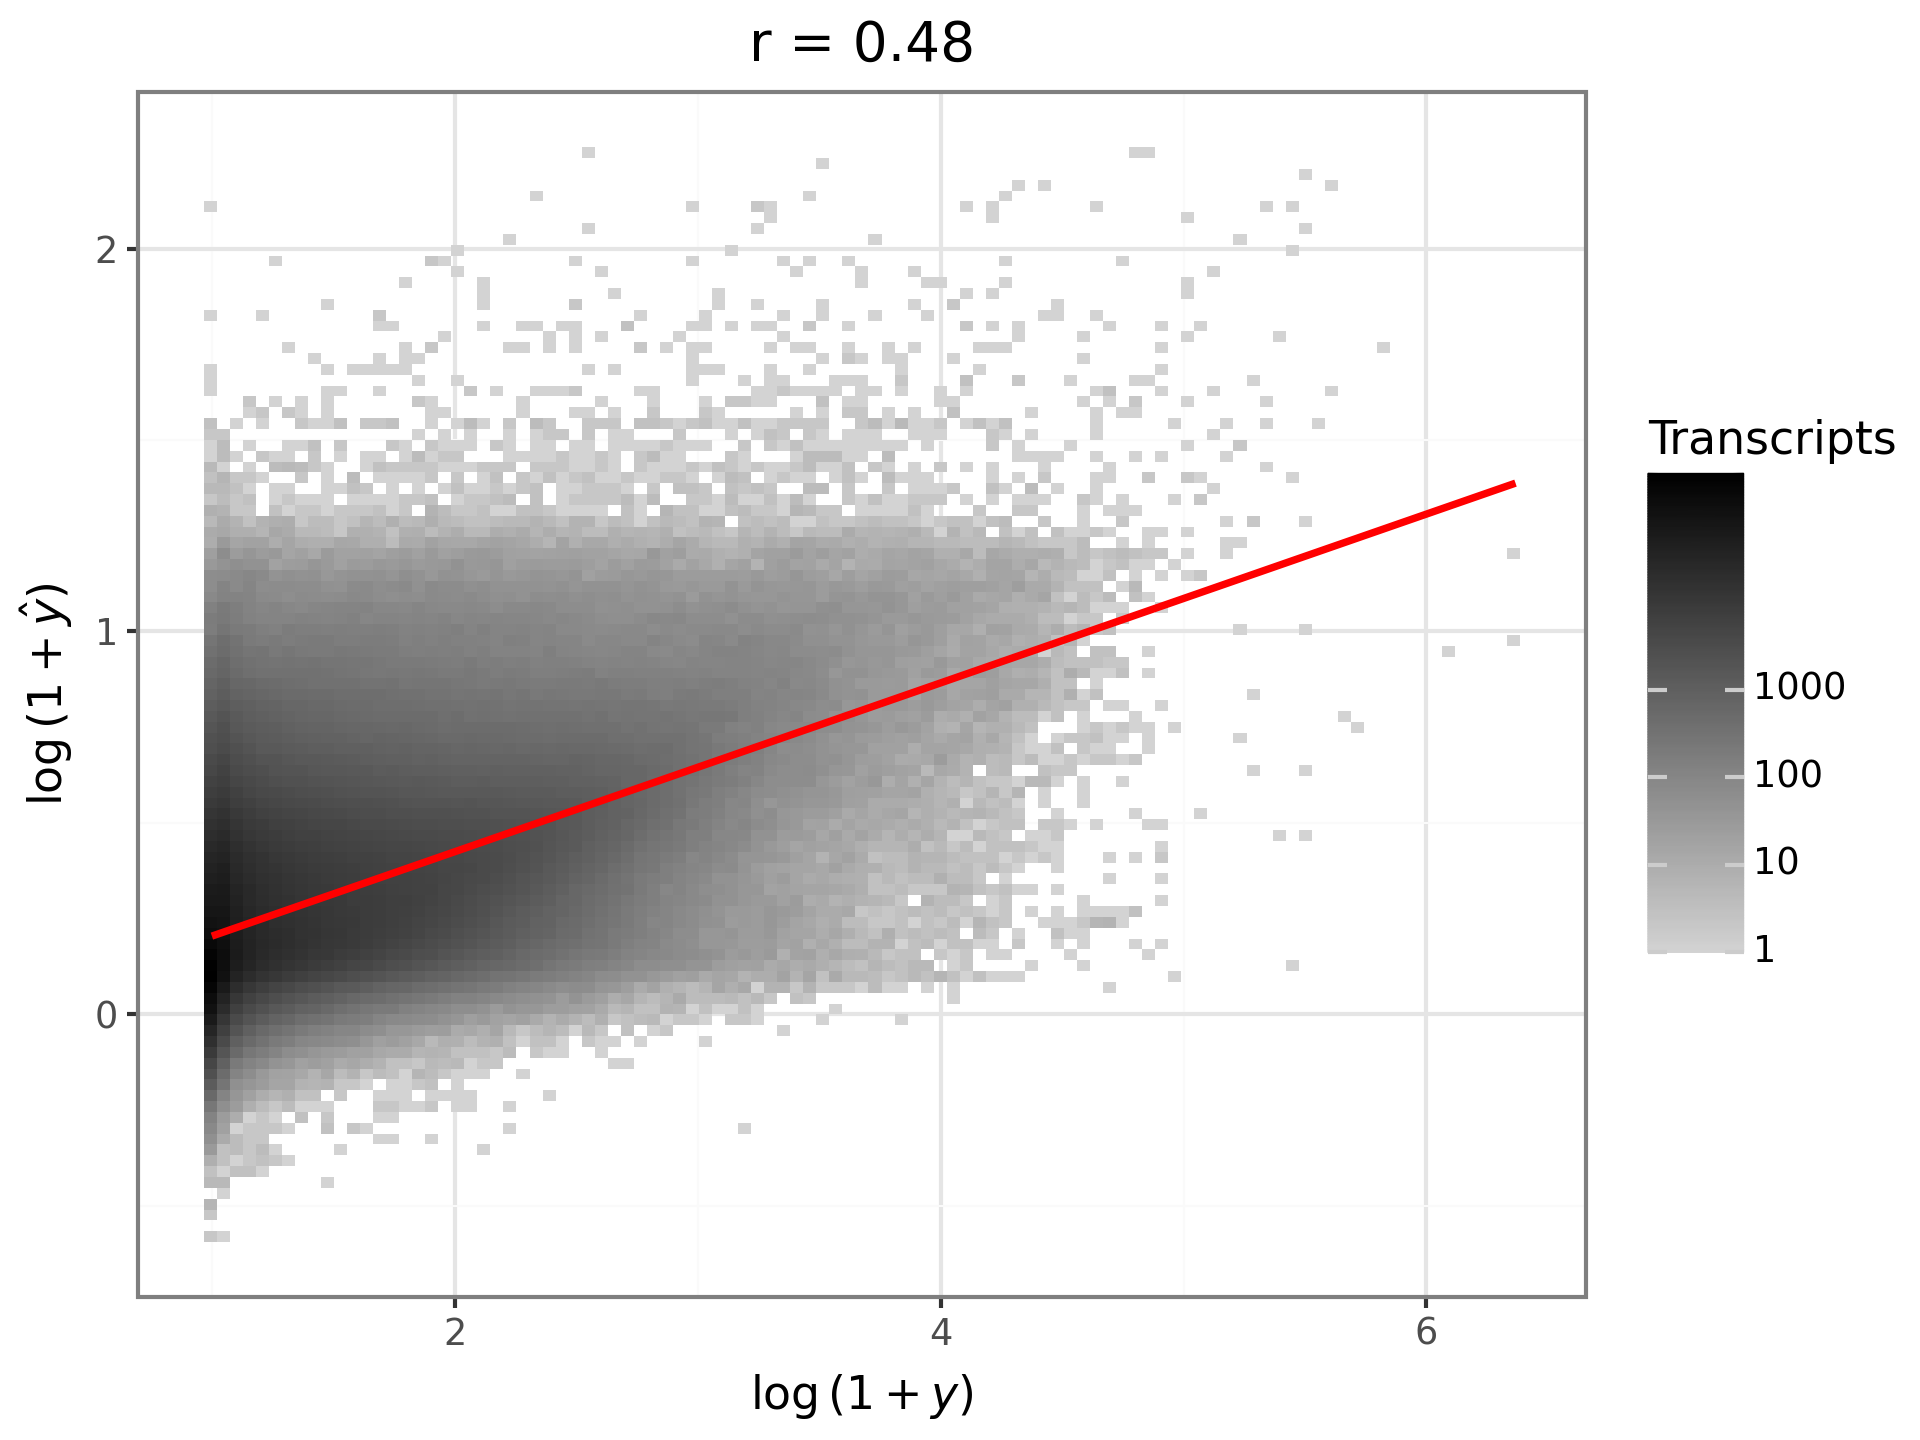

In [158]:
gg1

In [161]:
_df = merged_df.with_columns(tissue=pl.col('tissue').str.slice(0,15)  + '\nr = ' + 
                                   pl.col('tissue_pearsonr').map_elements(lambda x: f"{x:,.2f}", return_dtype=pl.String))

gg2 = (pn.ggplot(_df, pn.aes(x='logtpm', y='score')) + 
 pn.facet_wrap('tissue', nrow=8) +
 pn.geom_bin2d(bins=100) + 
 pn.geom_smooth(method="lm", color="red") +
 pn.scale_fill_gradient(name = "Transcripts", trans = "log10", breaks=[1, 10, 100, 1000], low="lightgrey", high="black") +
 pn.theme(
    figure_size=(12, 8),
    dpi=150)
 + pn.labs(
     x="$\\log{(1 + y)}$", 
     y="$\\log{(1 + \\hat{y})}$",
     color="",
     fill="",
     title=f'r = {total_corr.statistic:,.2f}'
 )
)

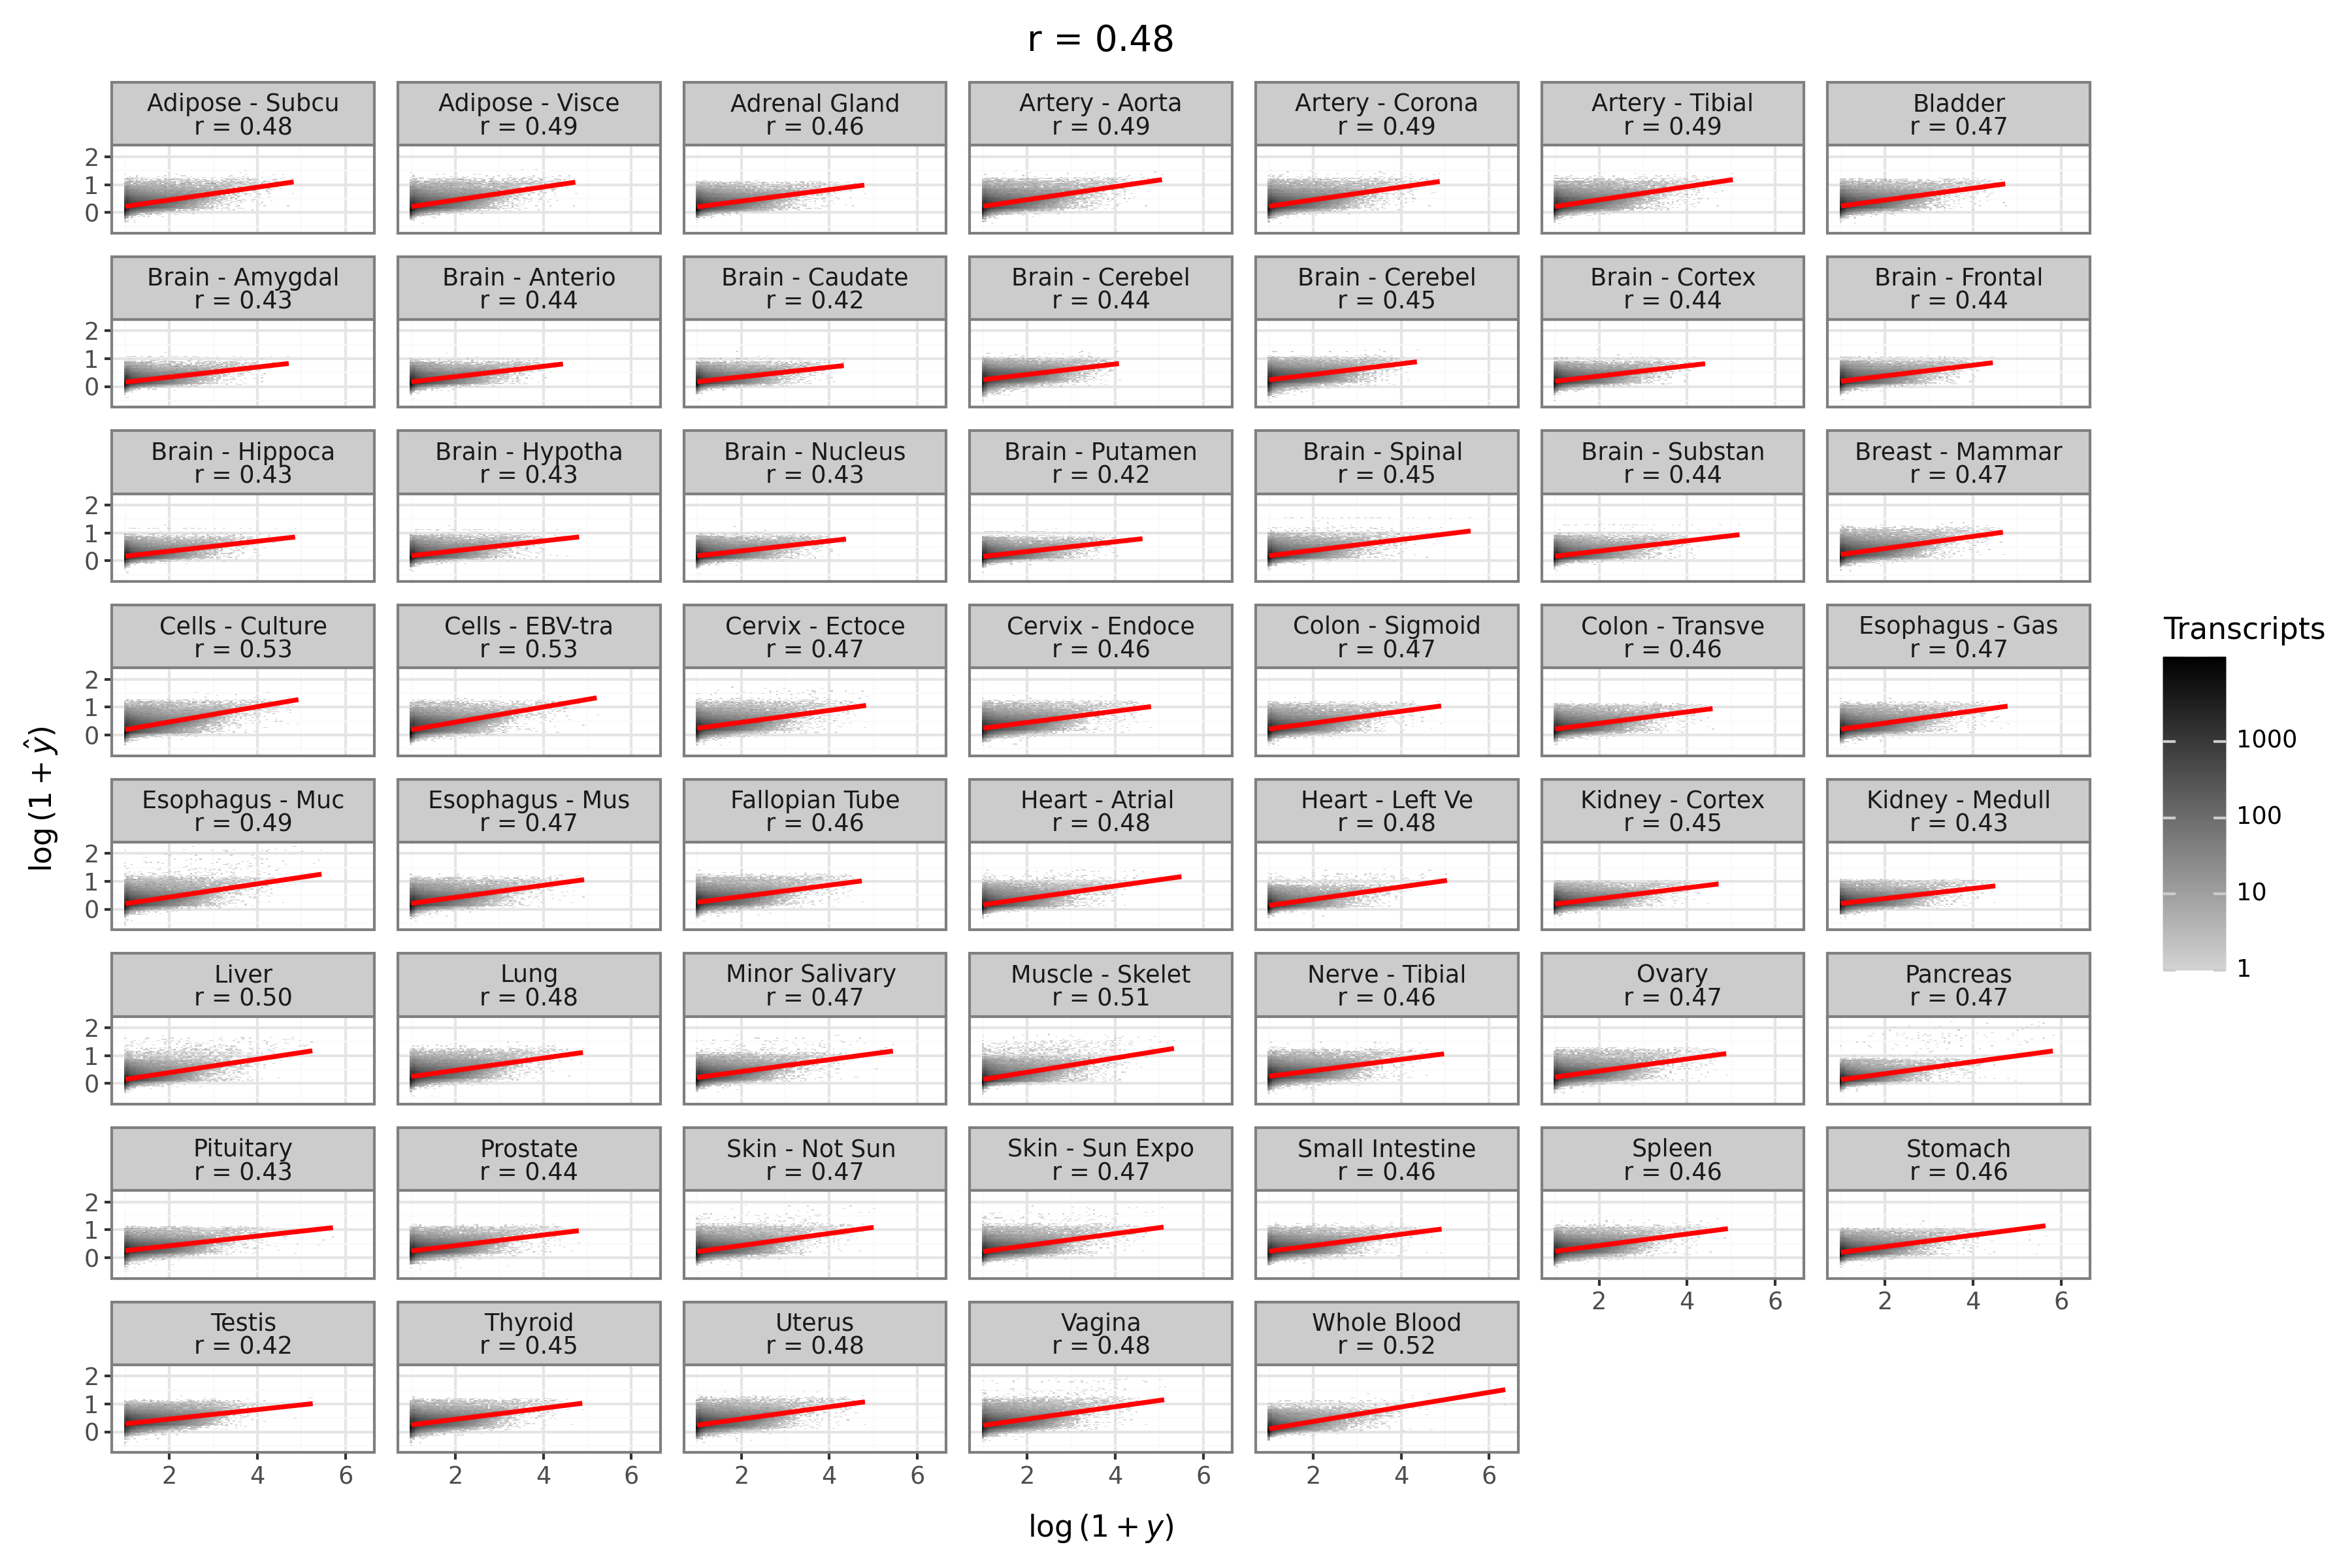

In [162]:
gg2

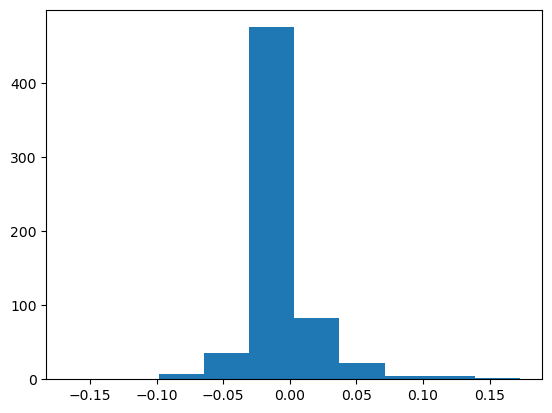

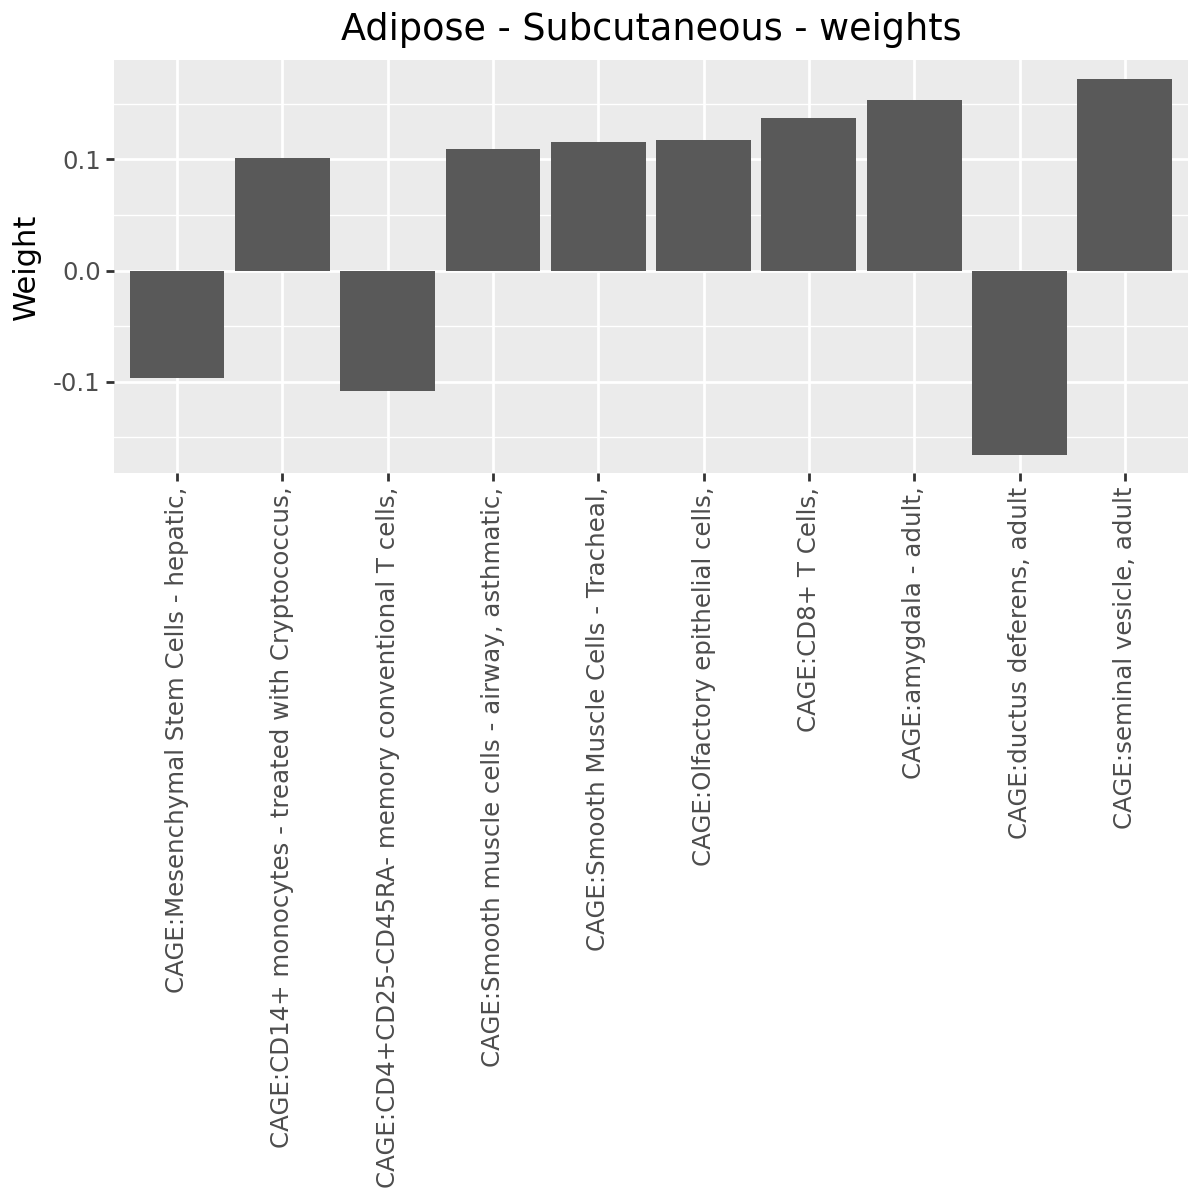

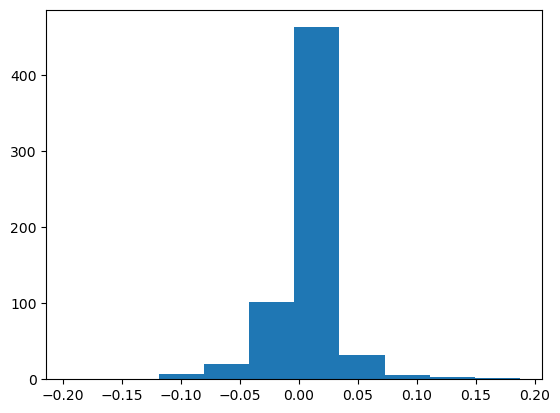

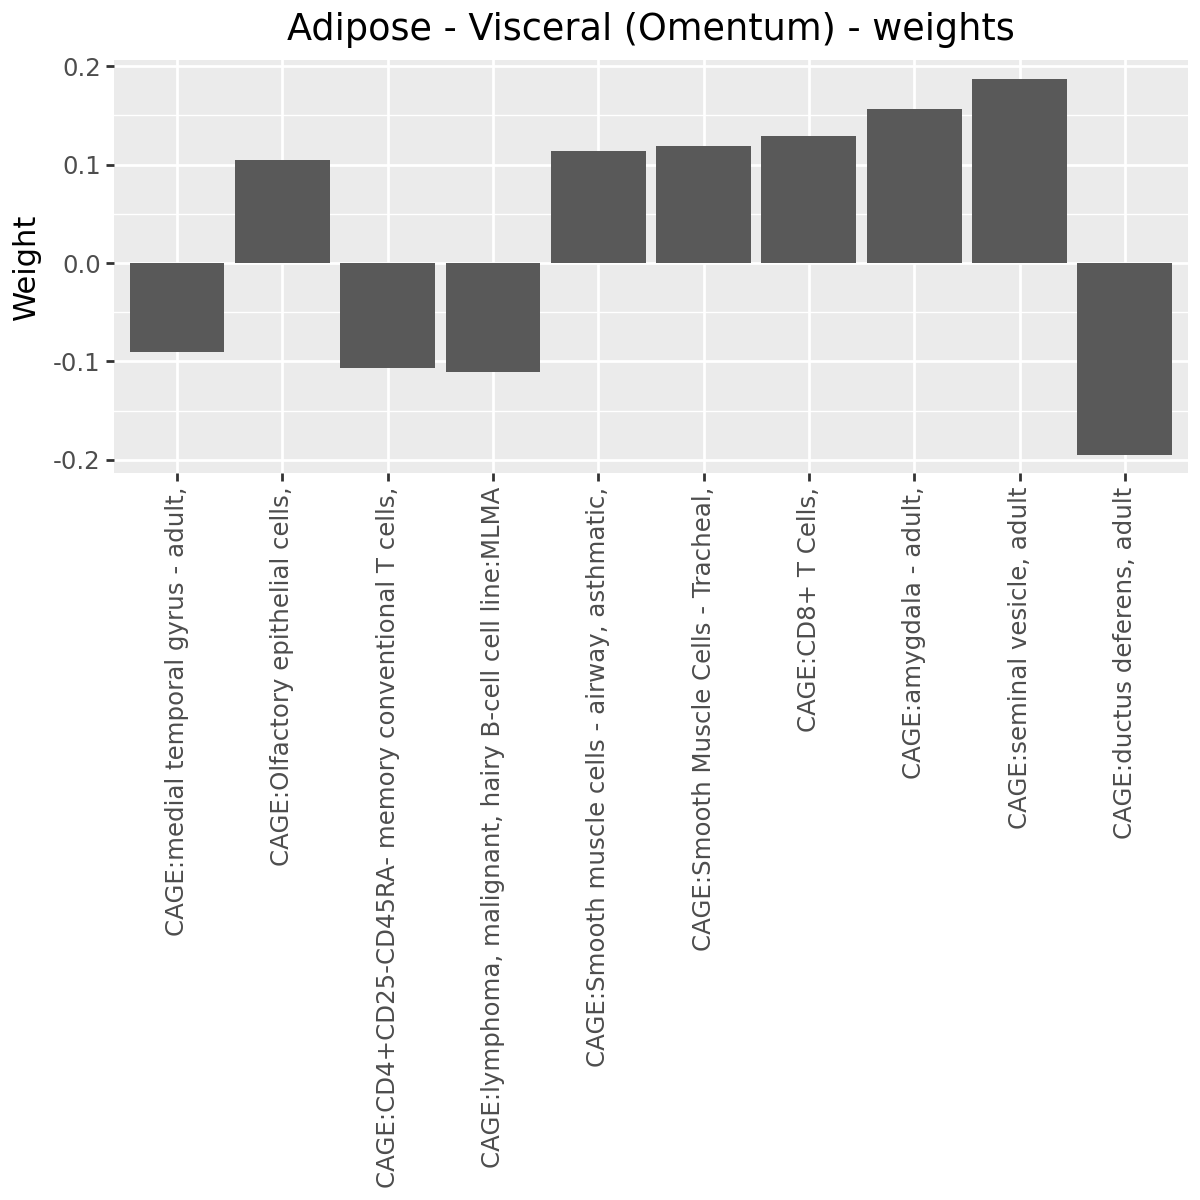

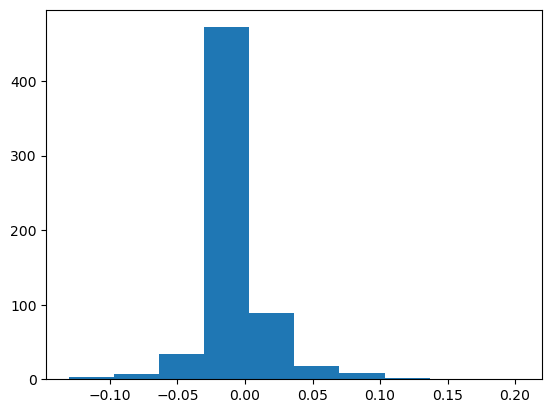

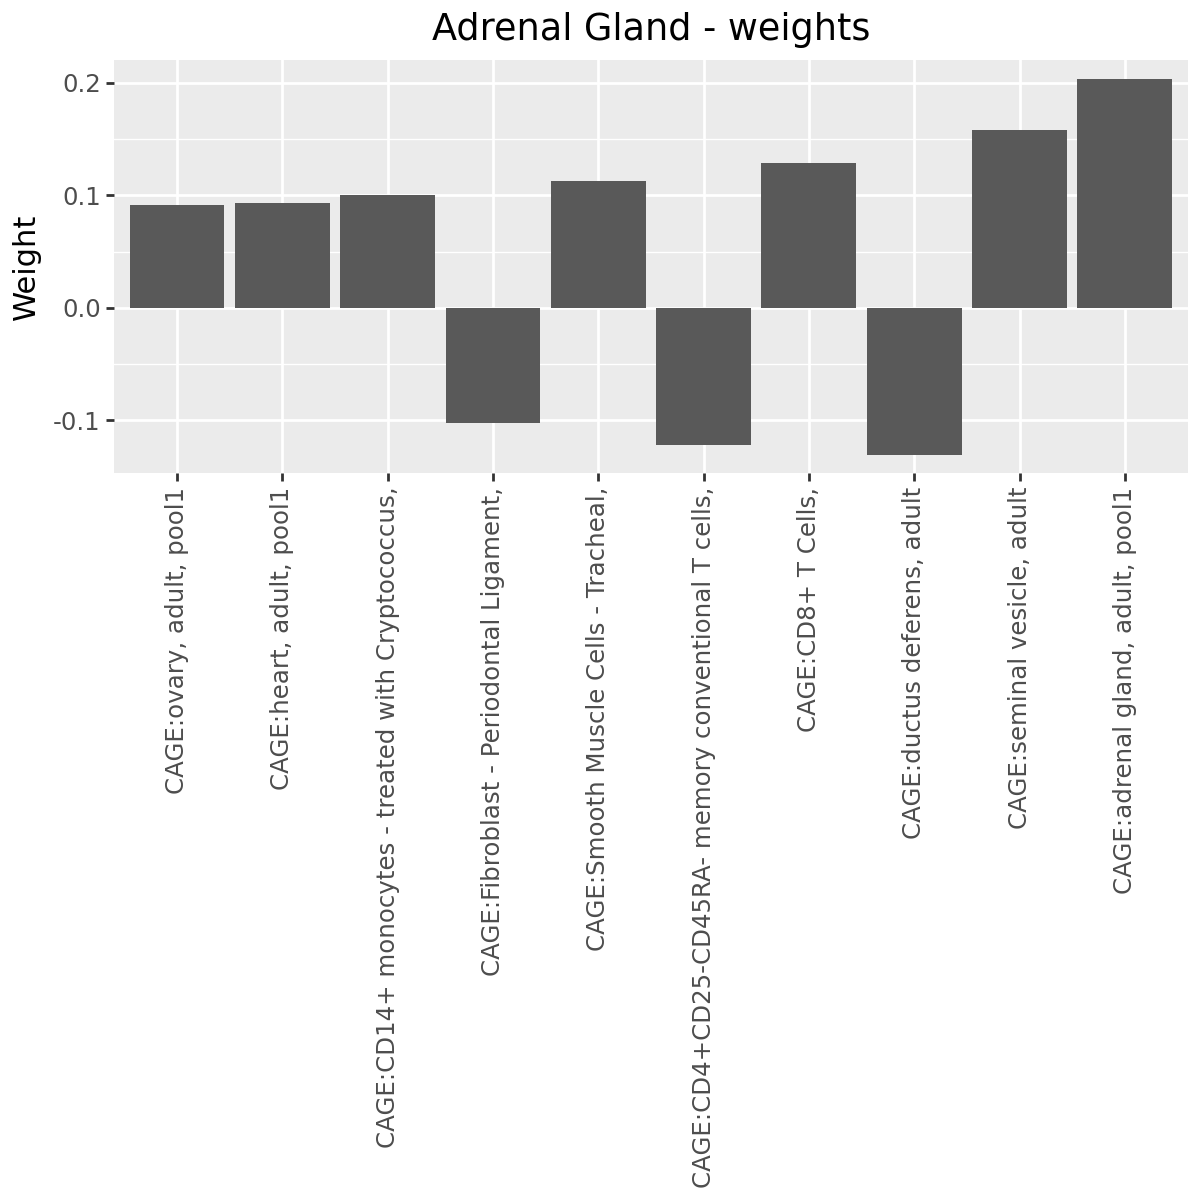

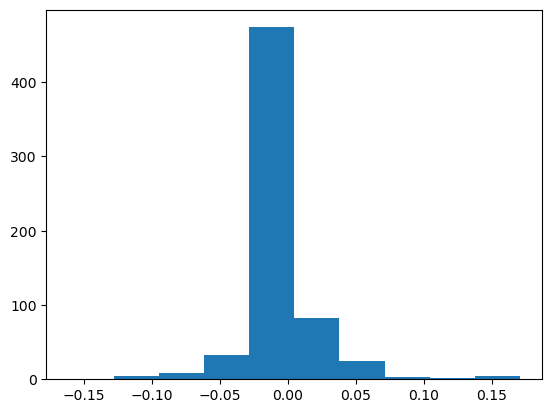

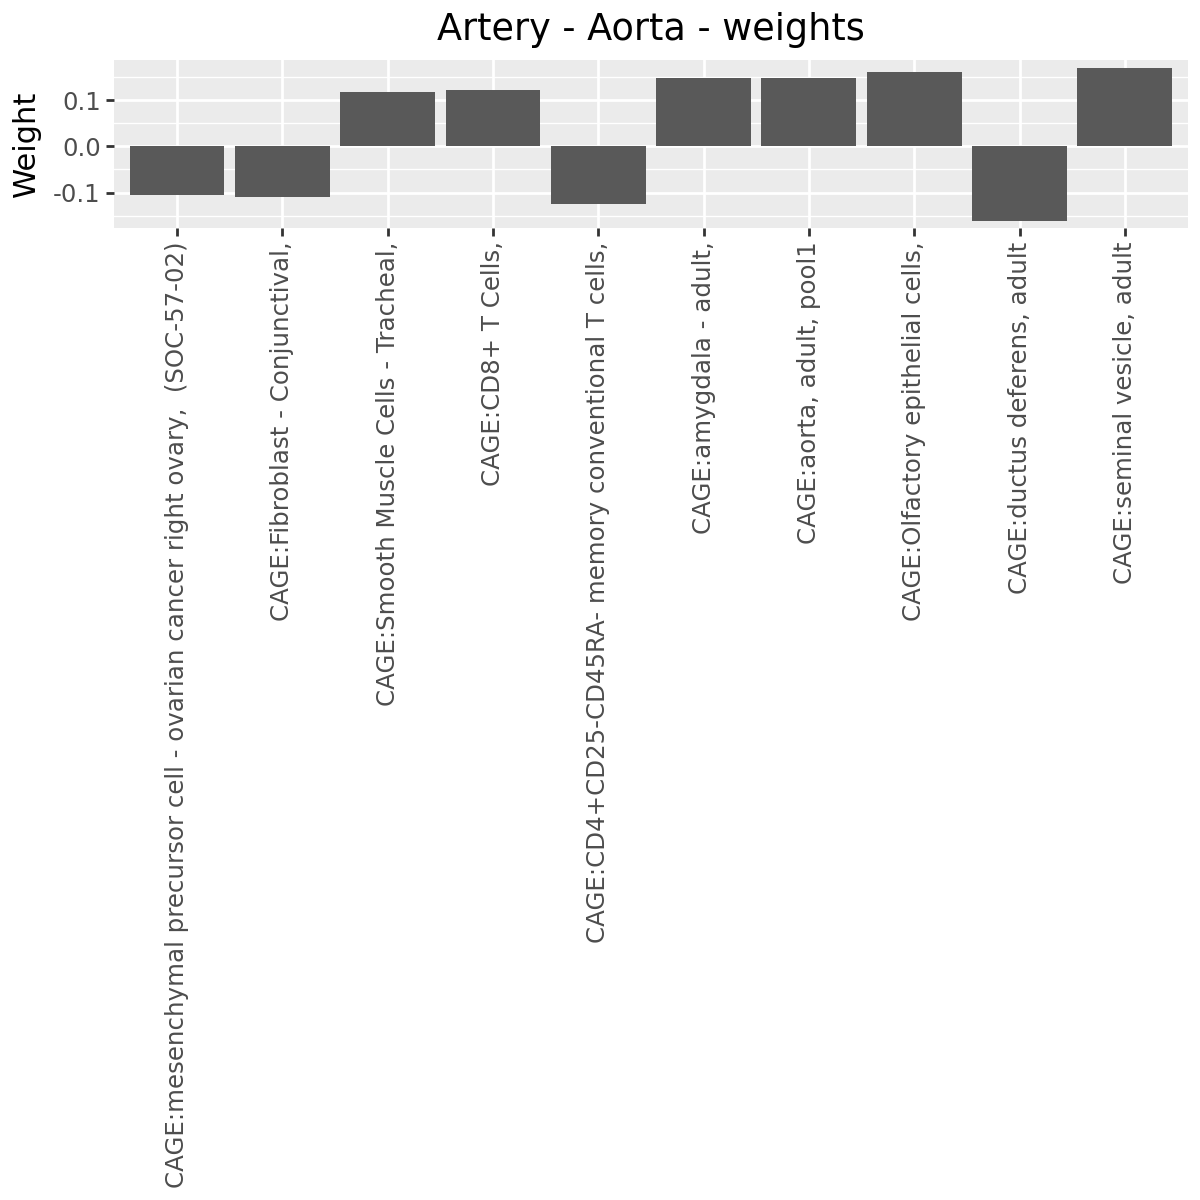

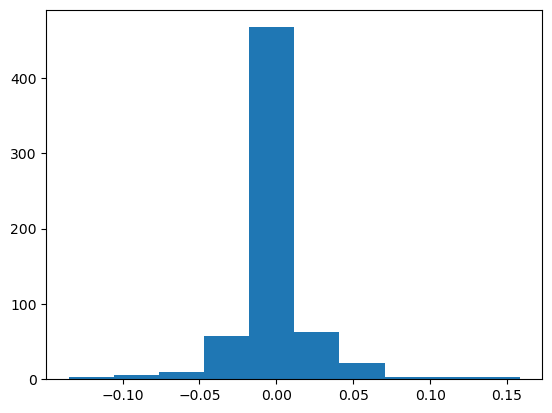

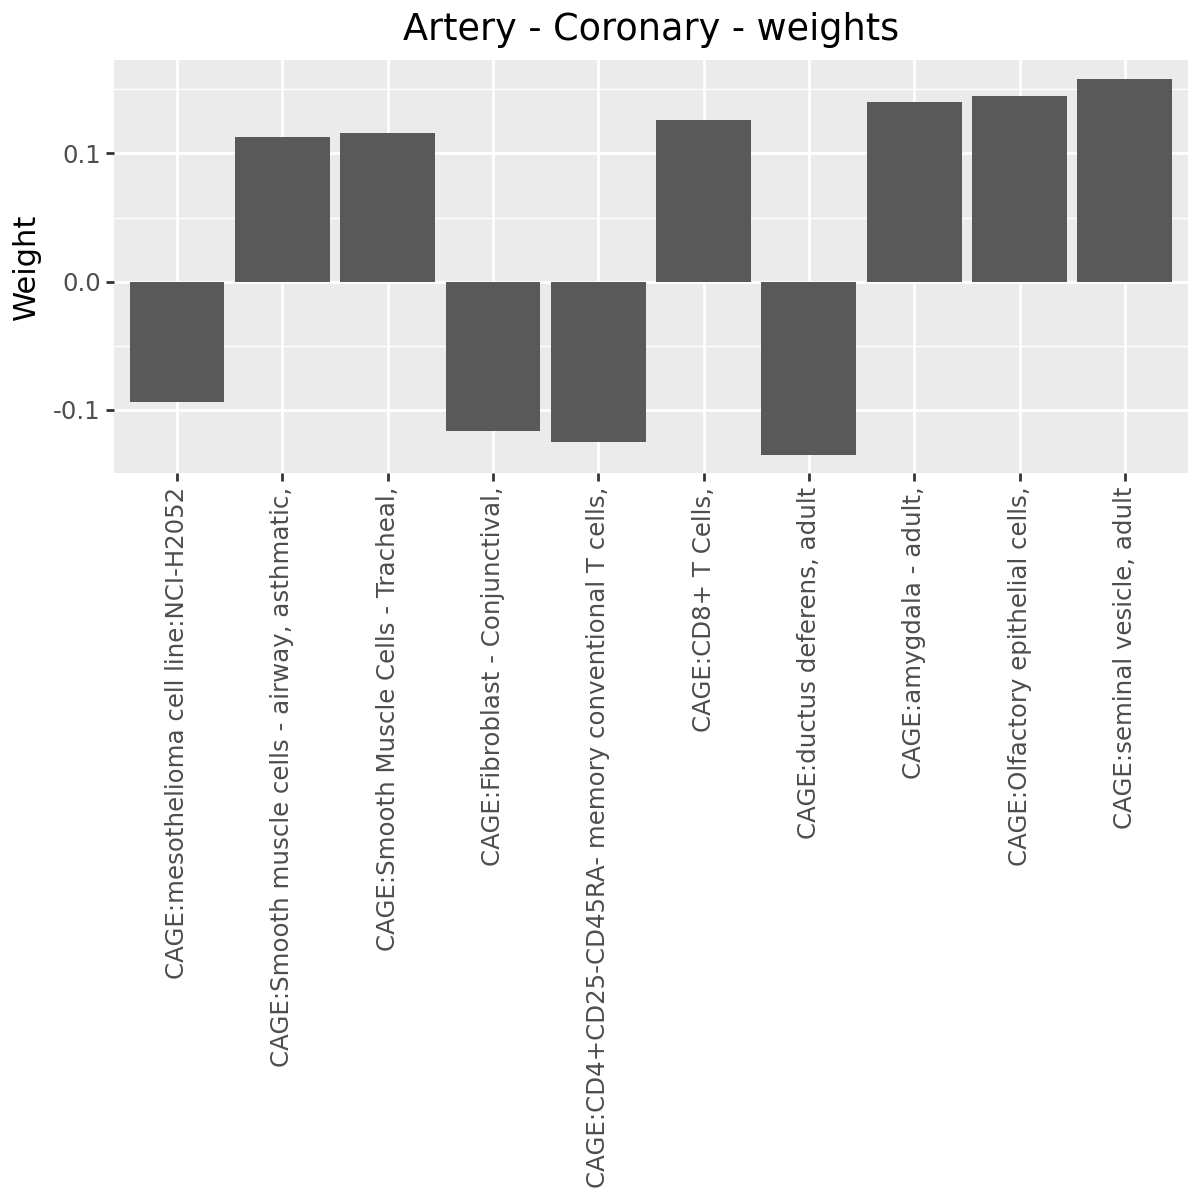

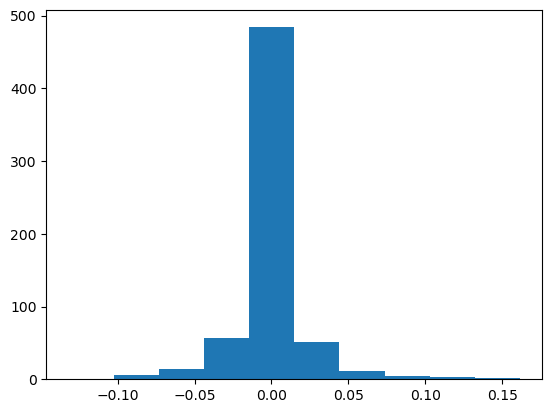

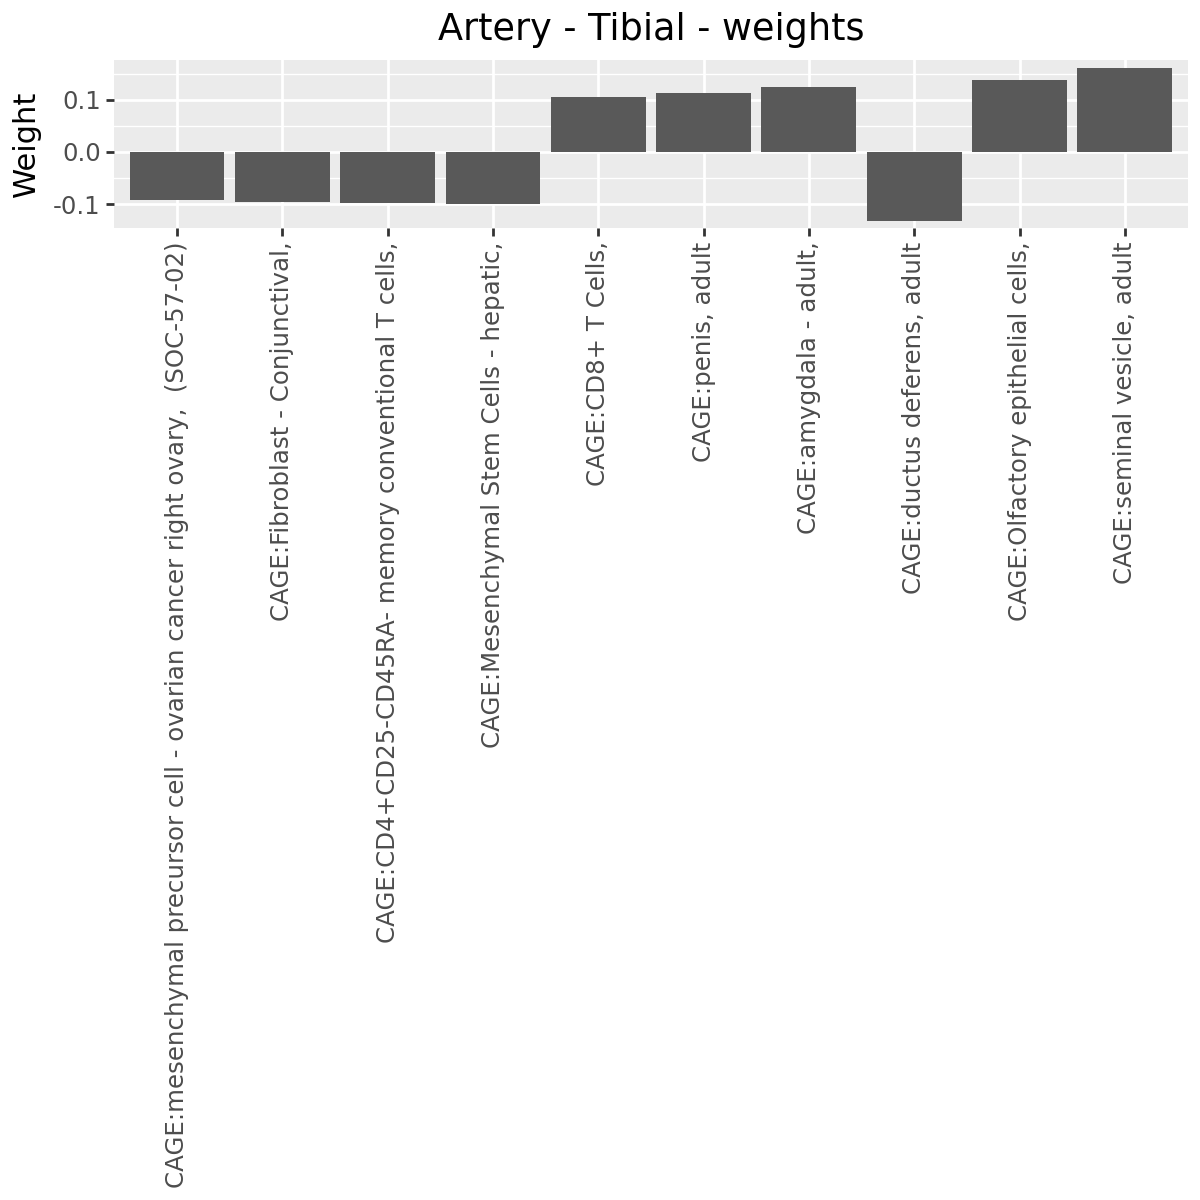

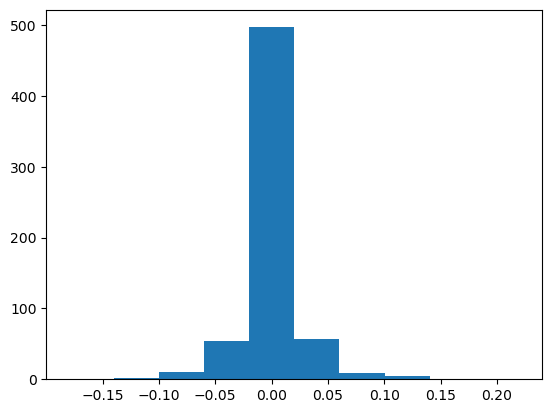

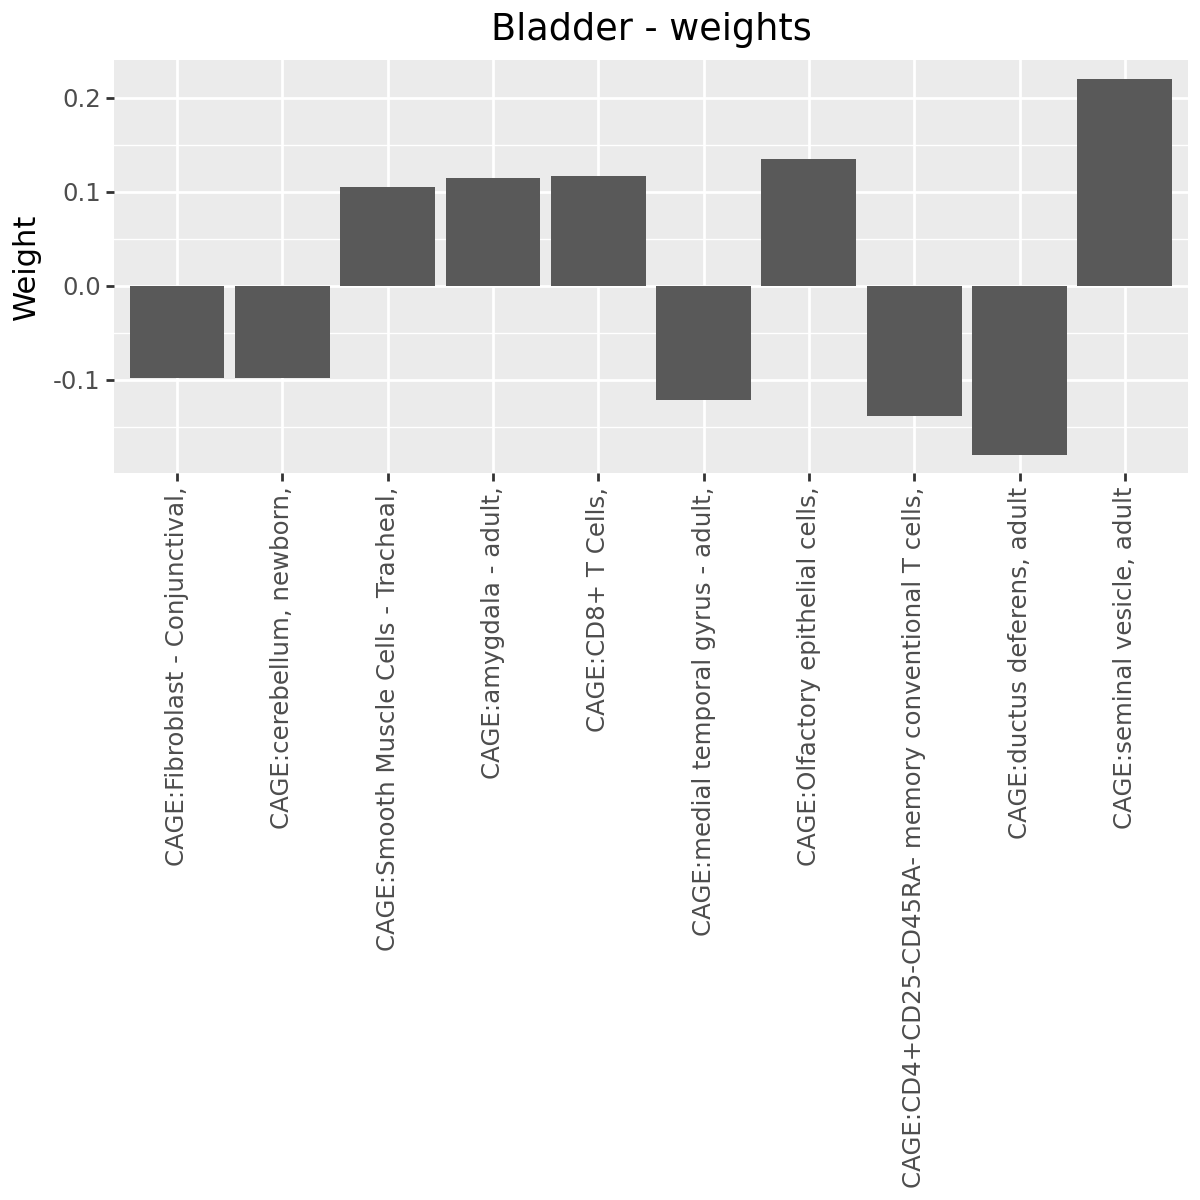

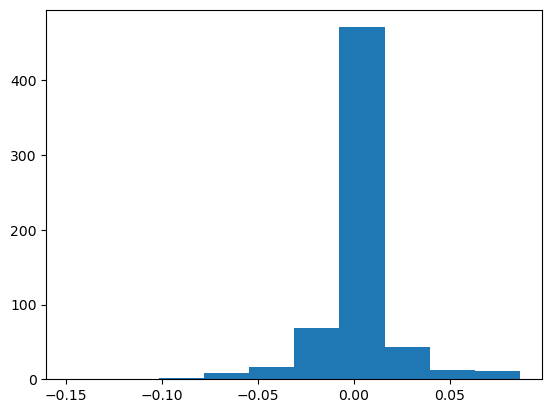

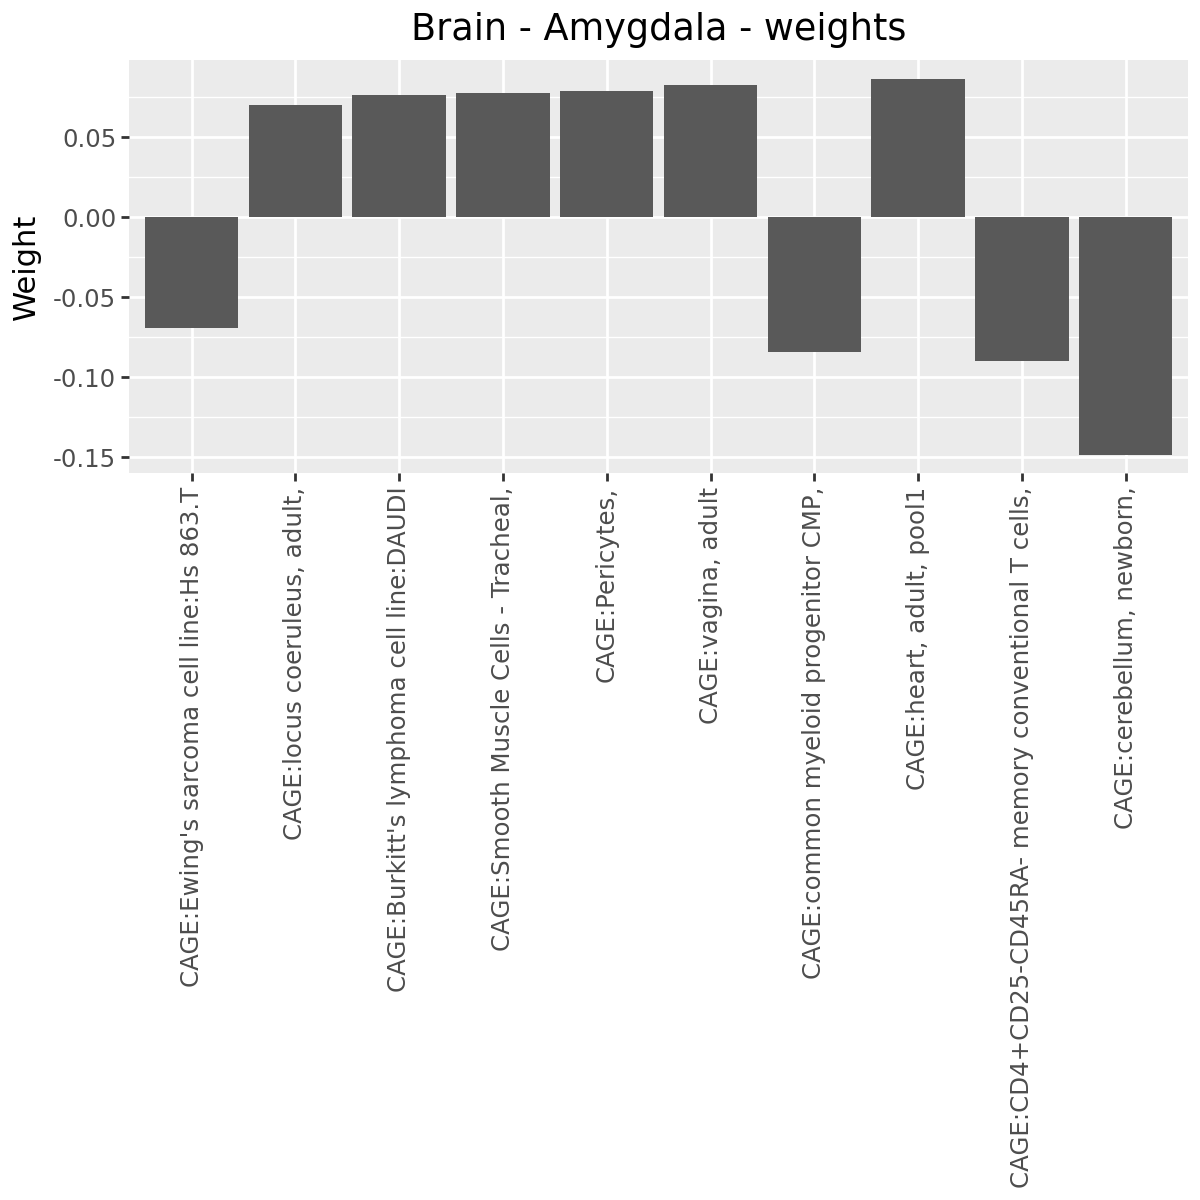

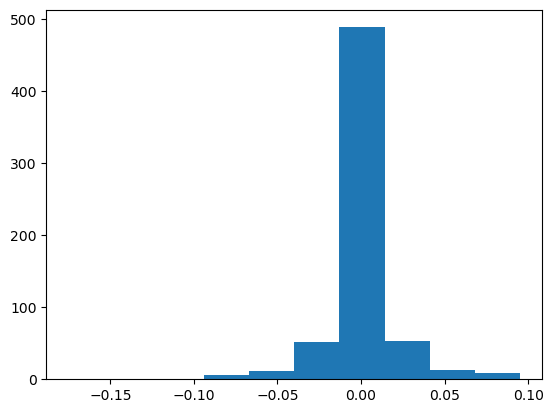

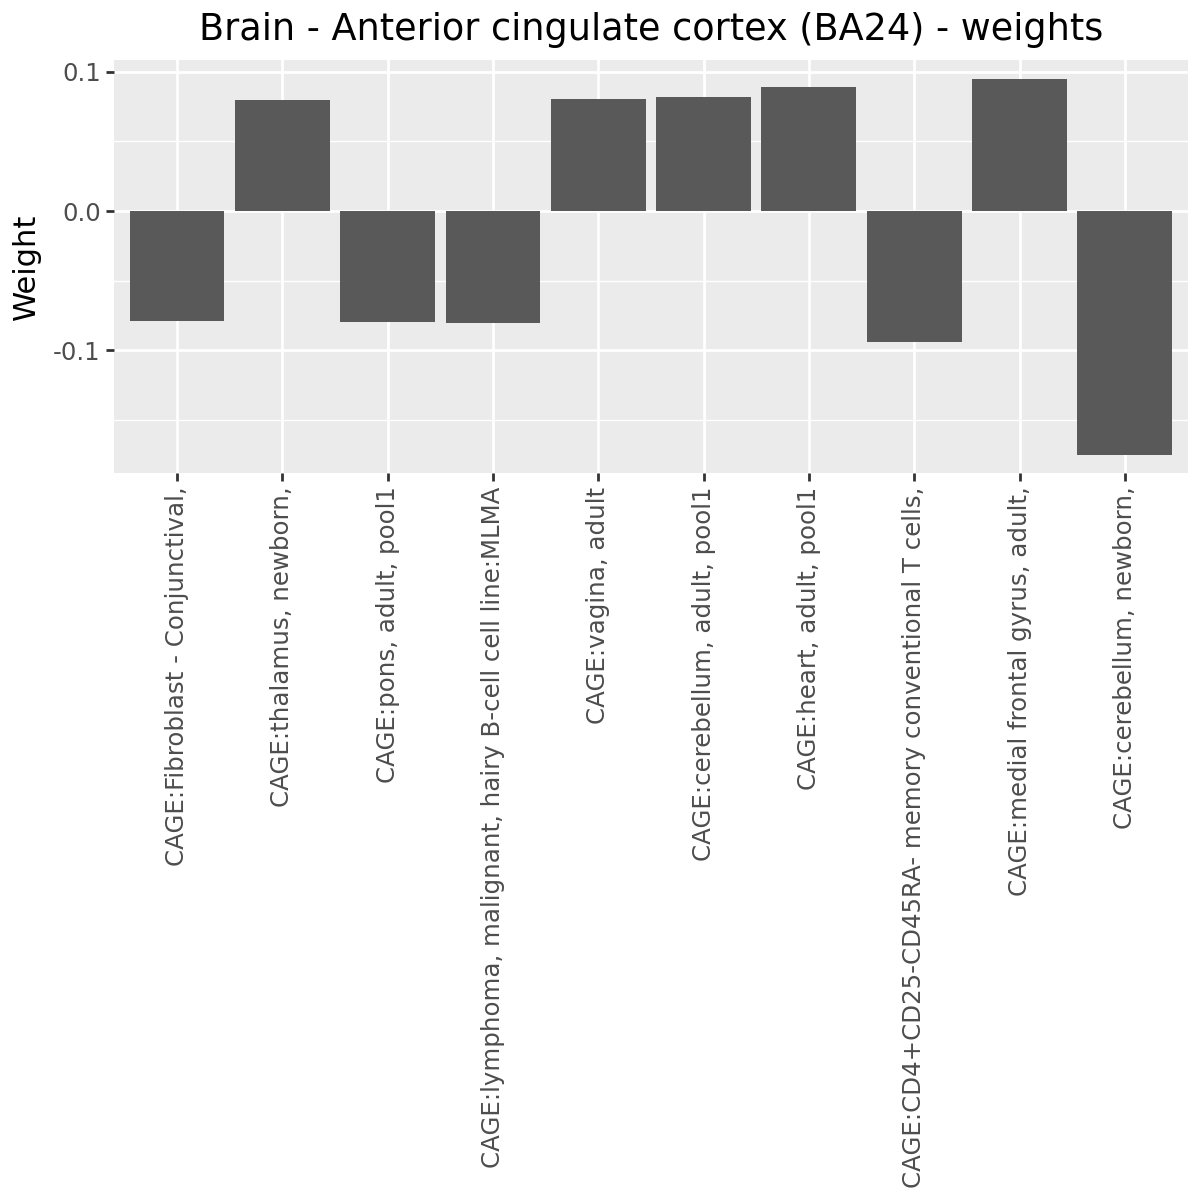

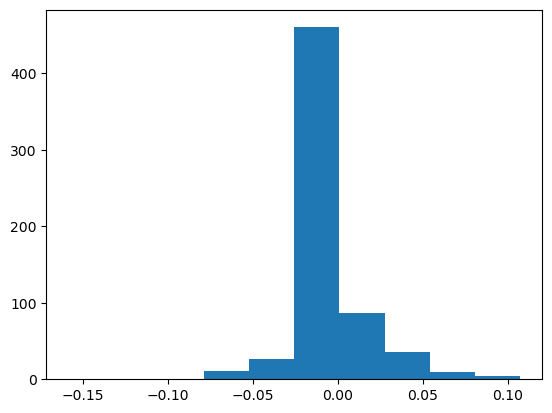

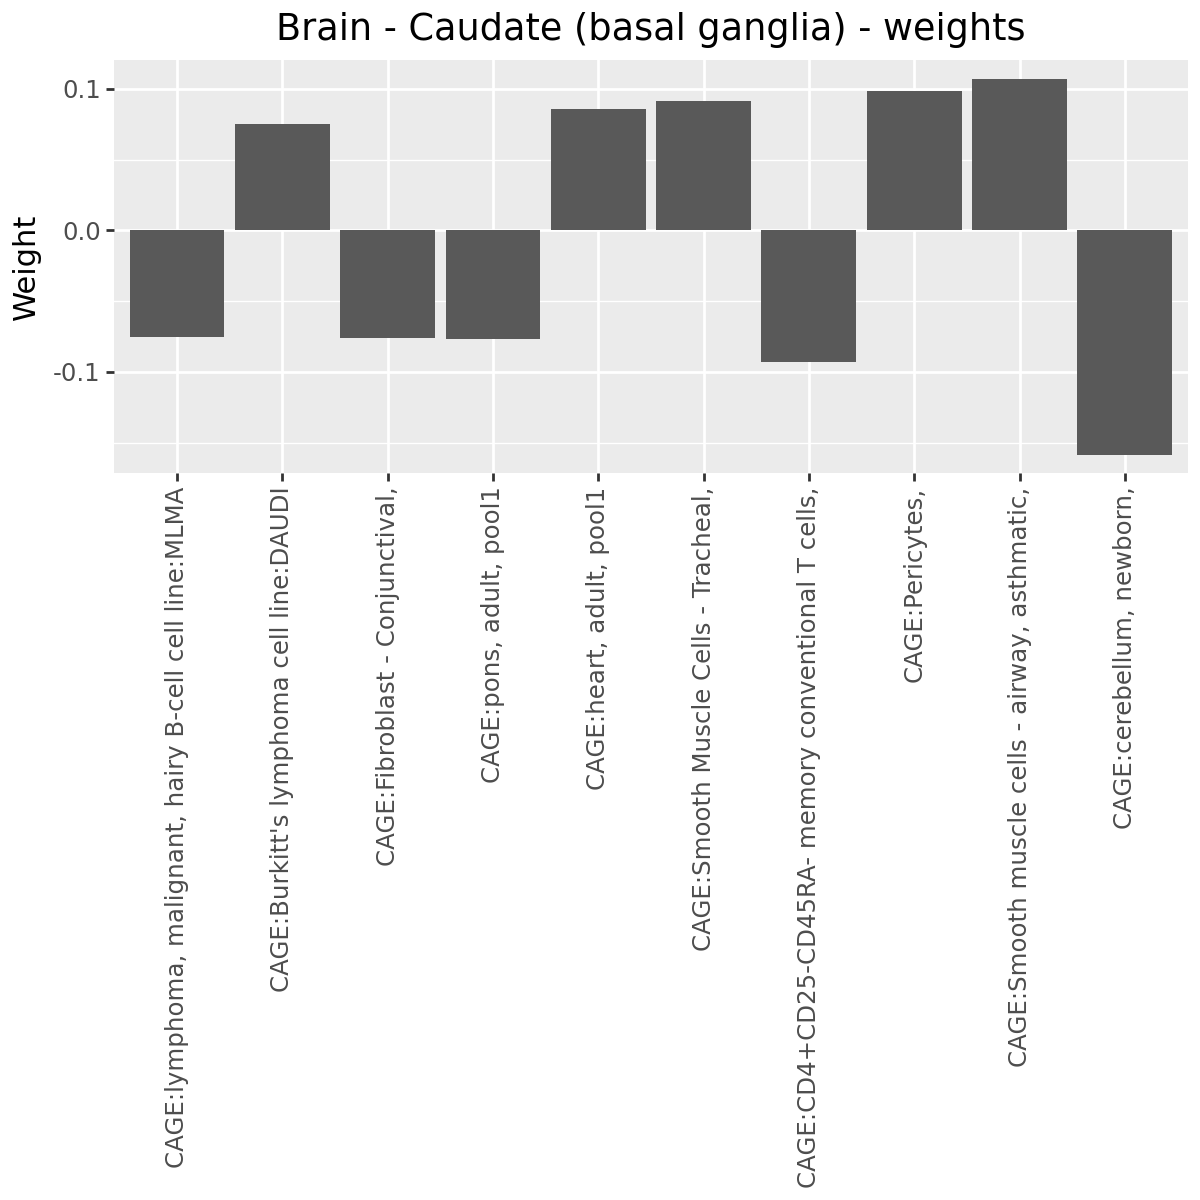

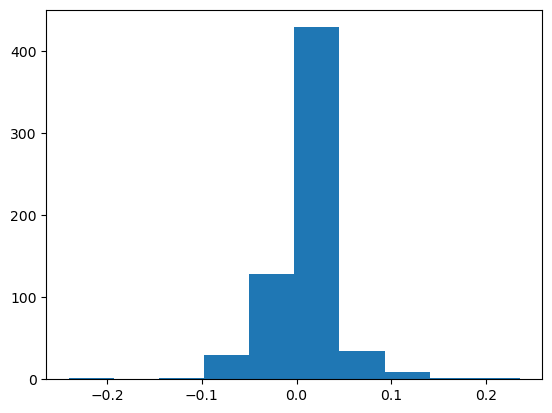

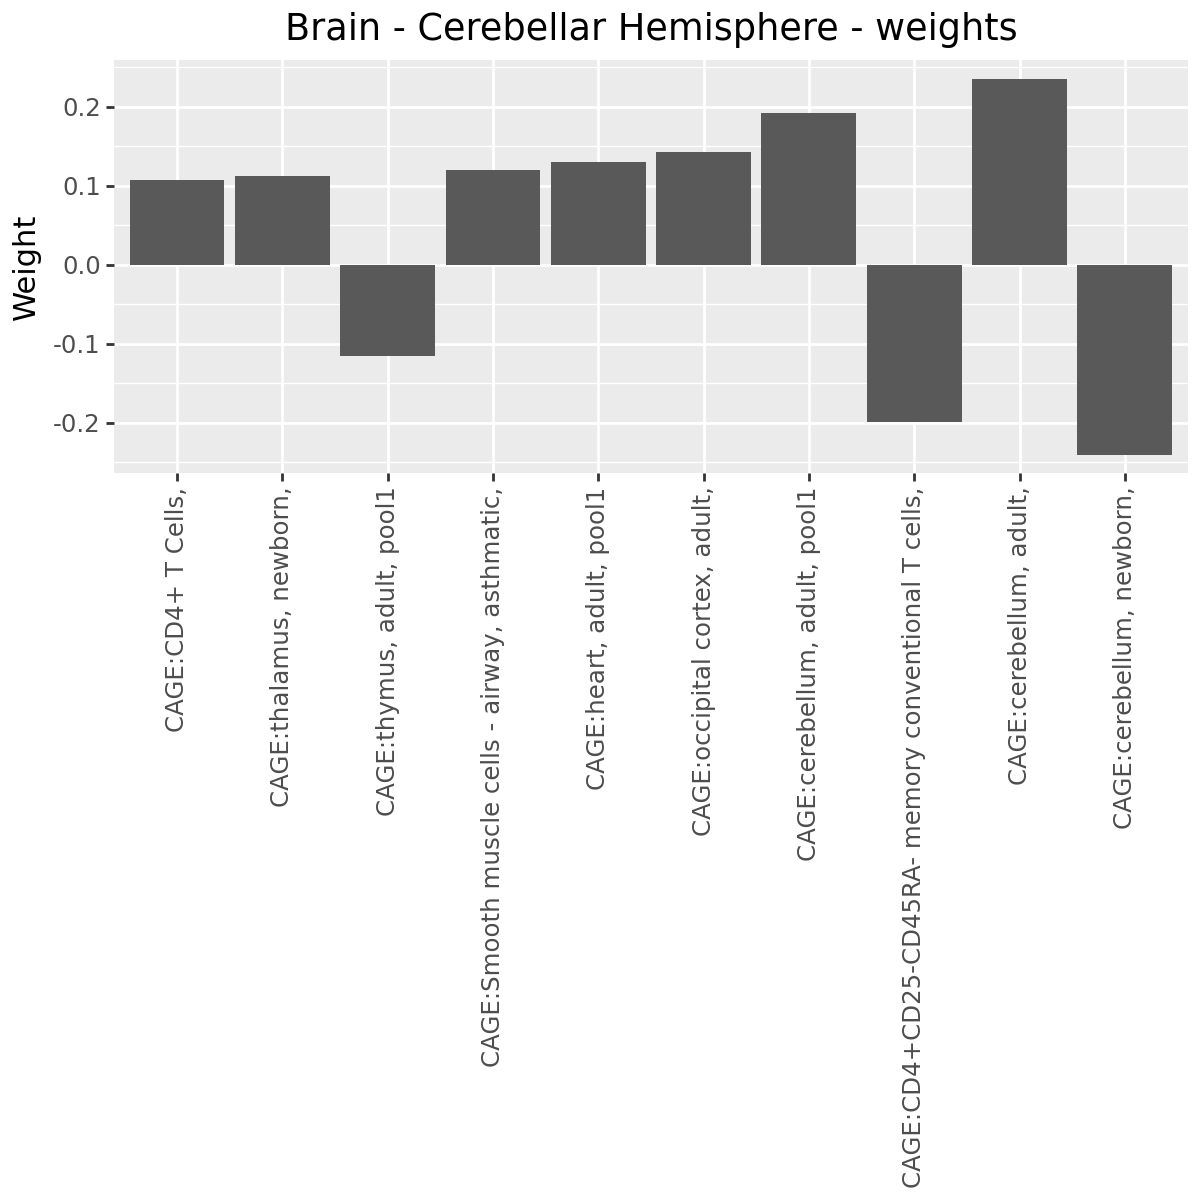

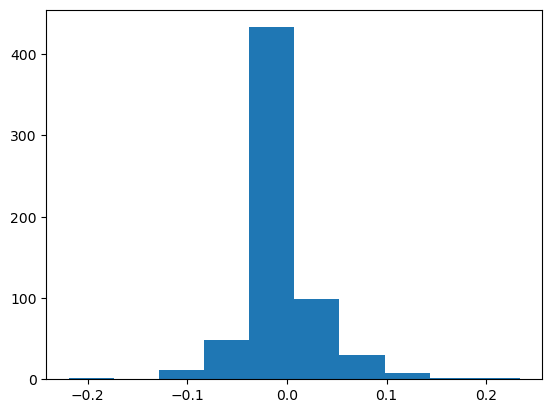

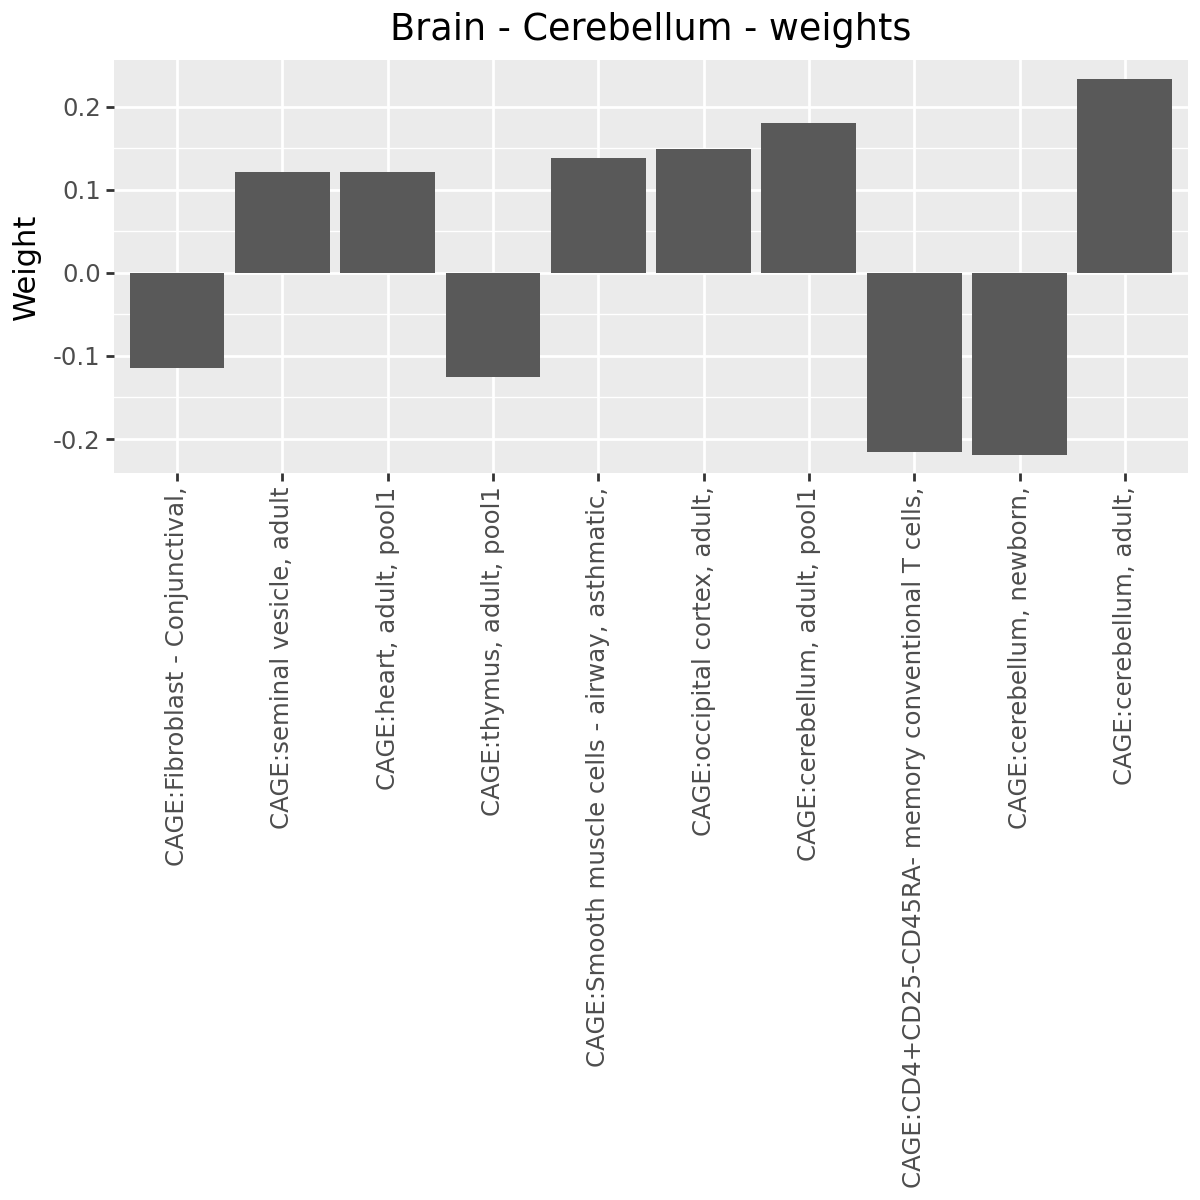

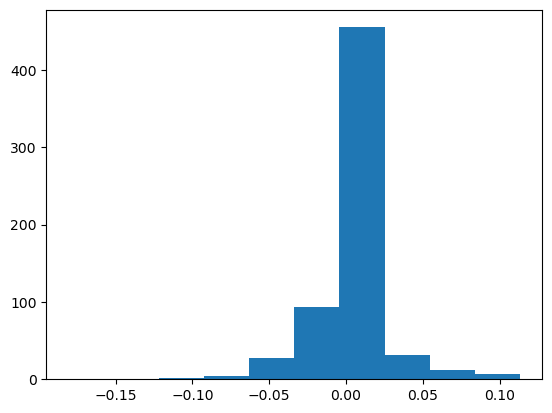

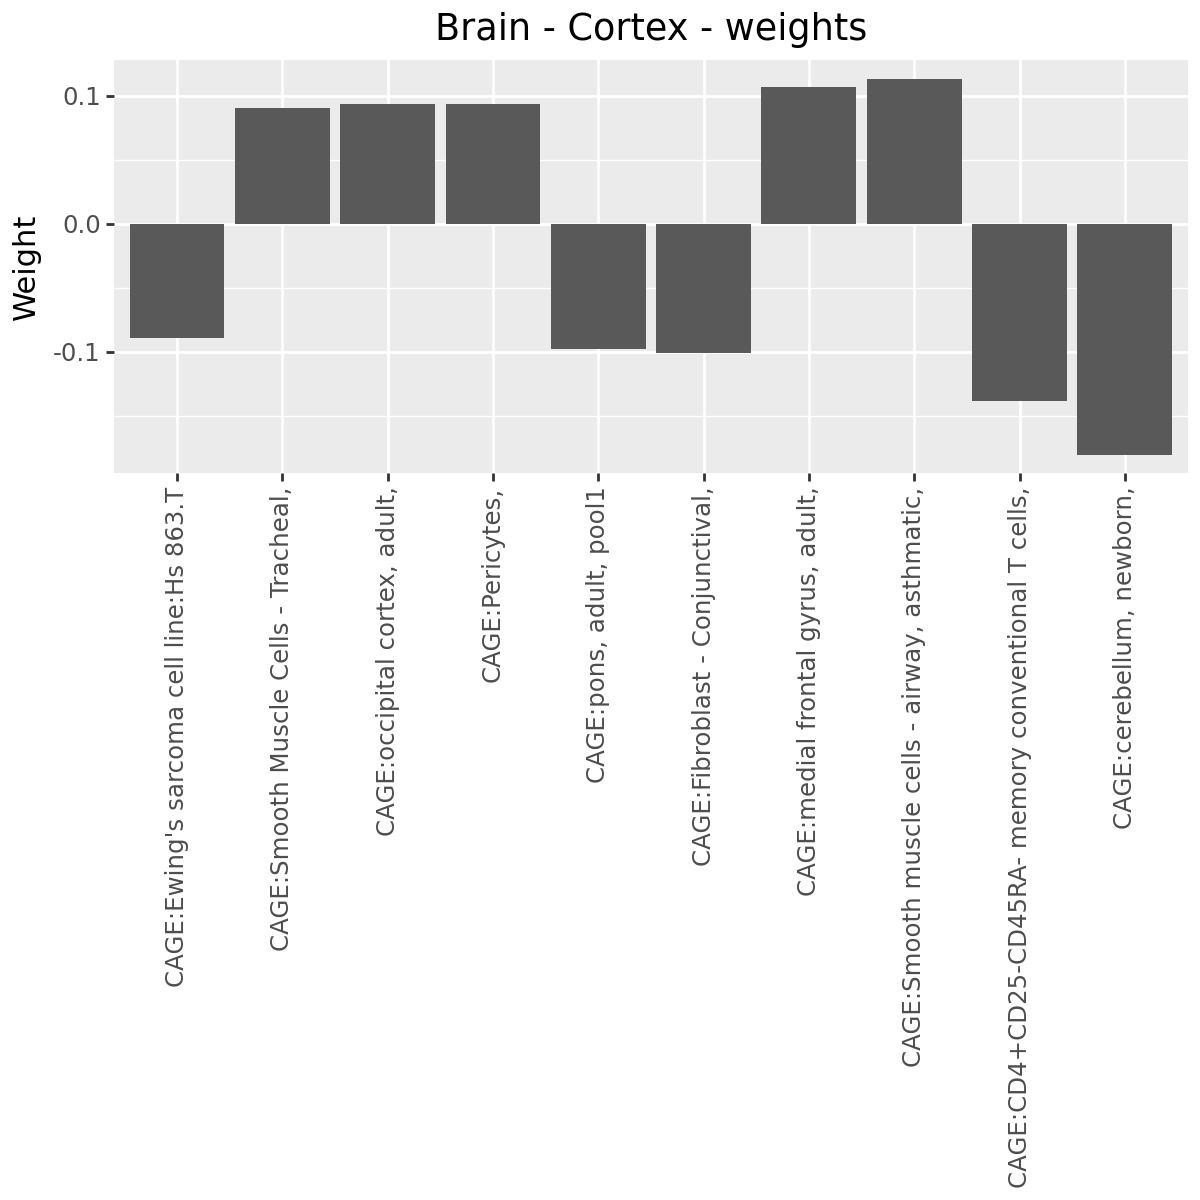

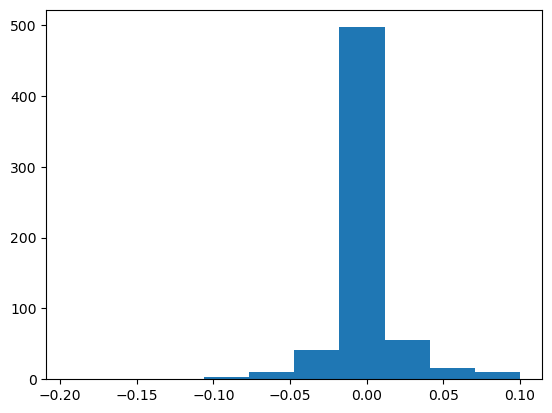

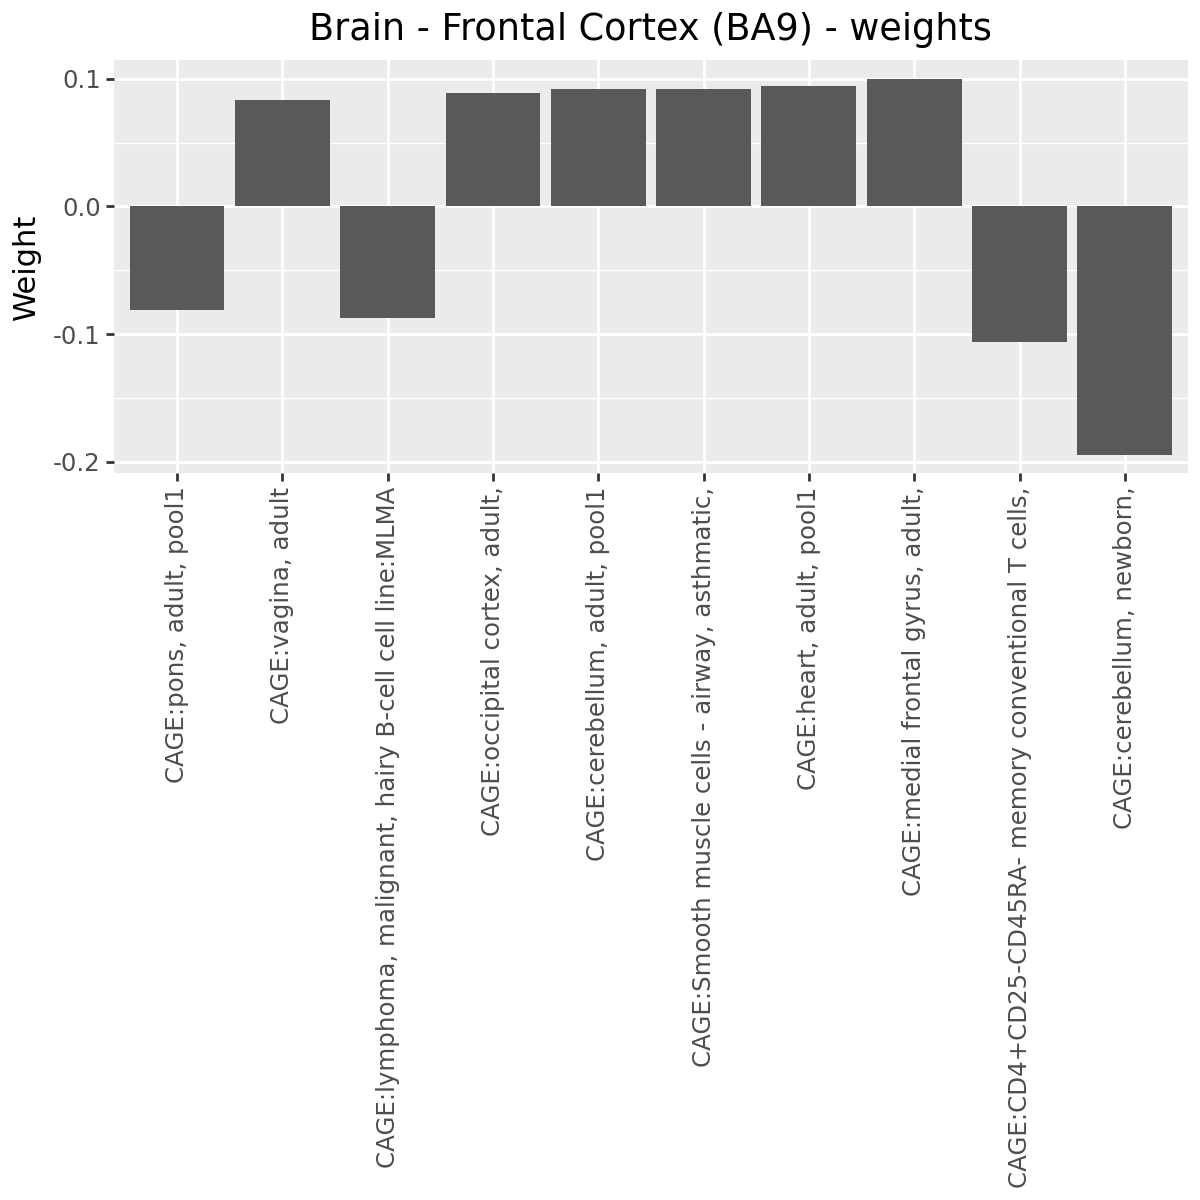

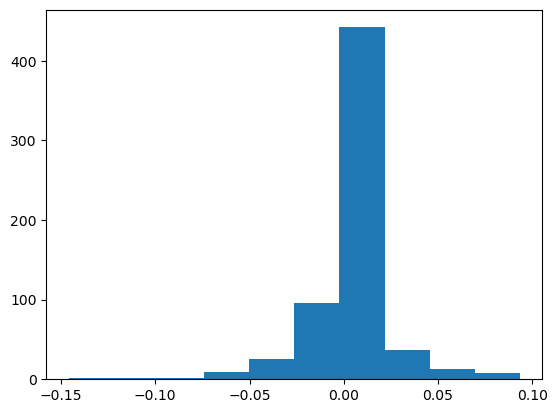

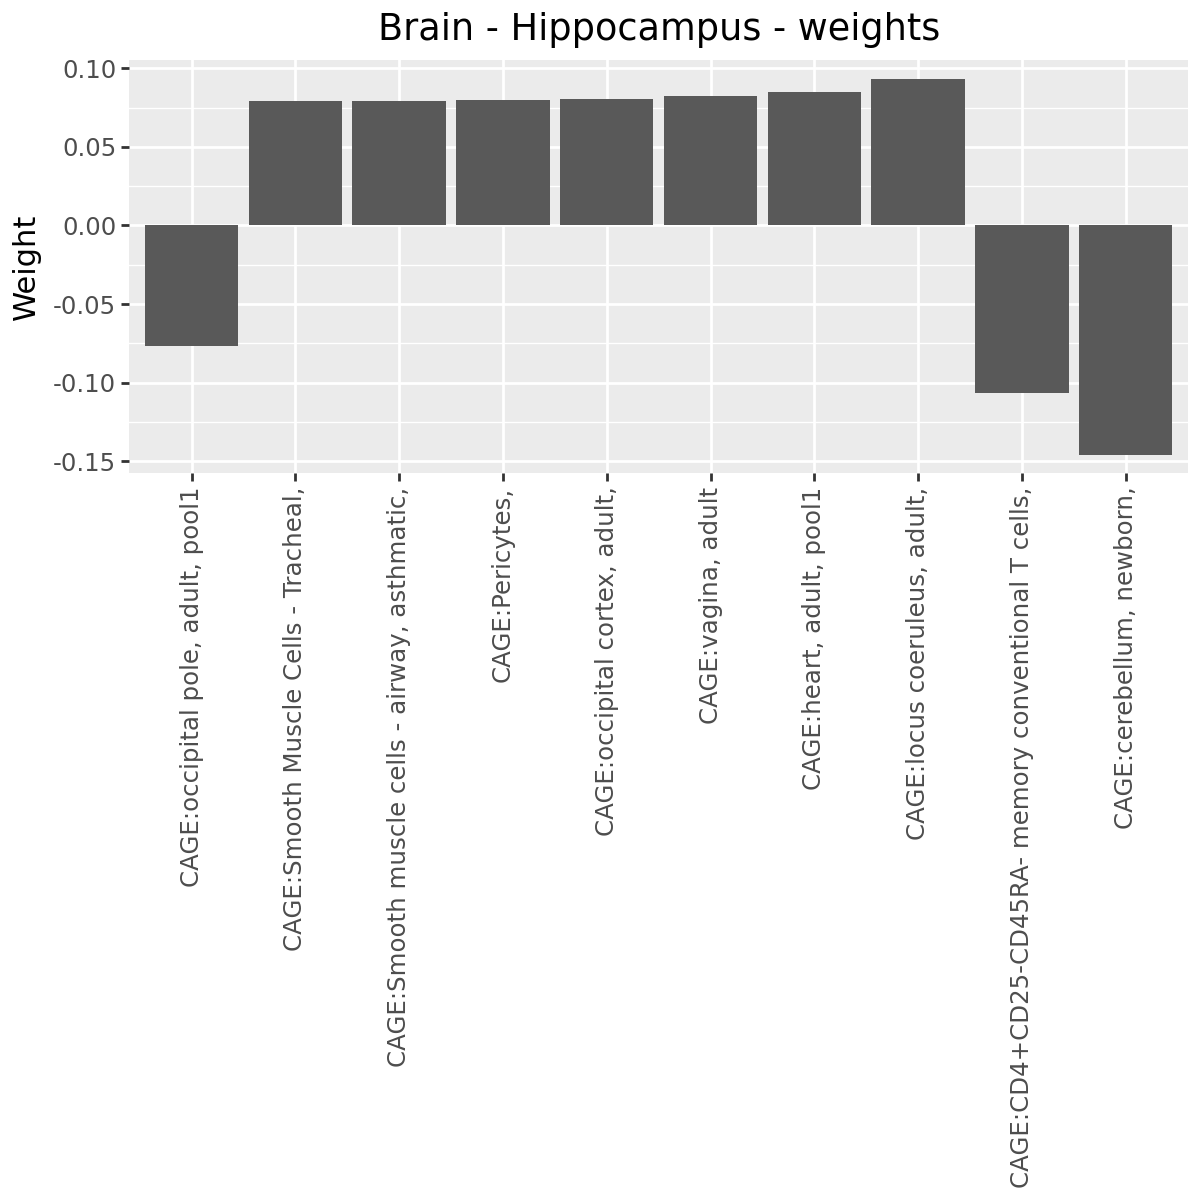

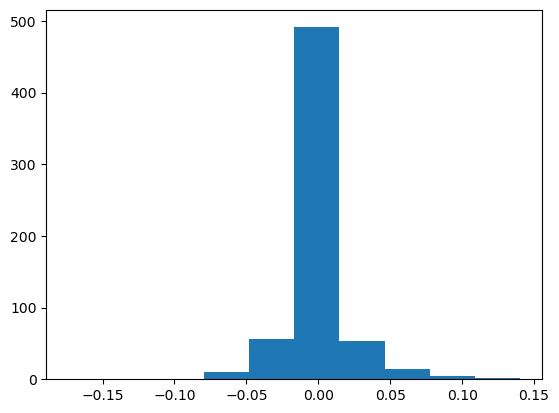

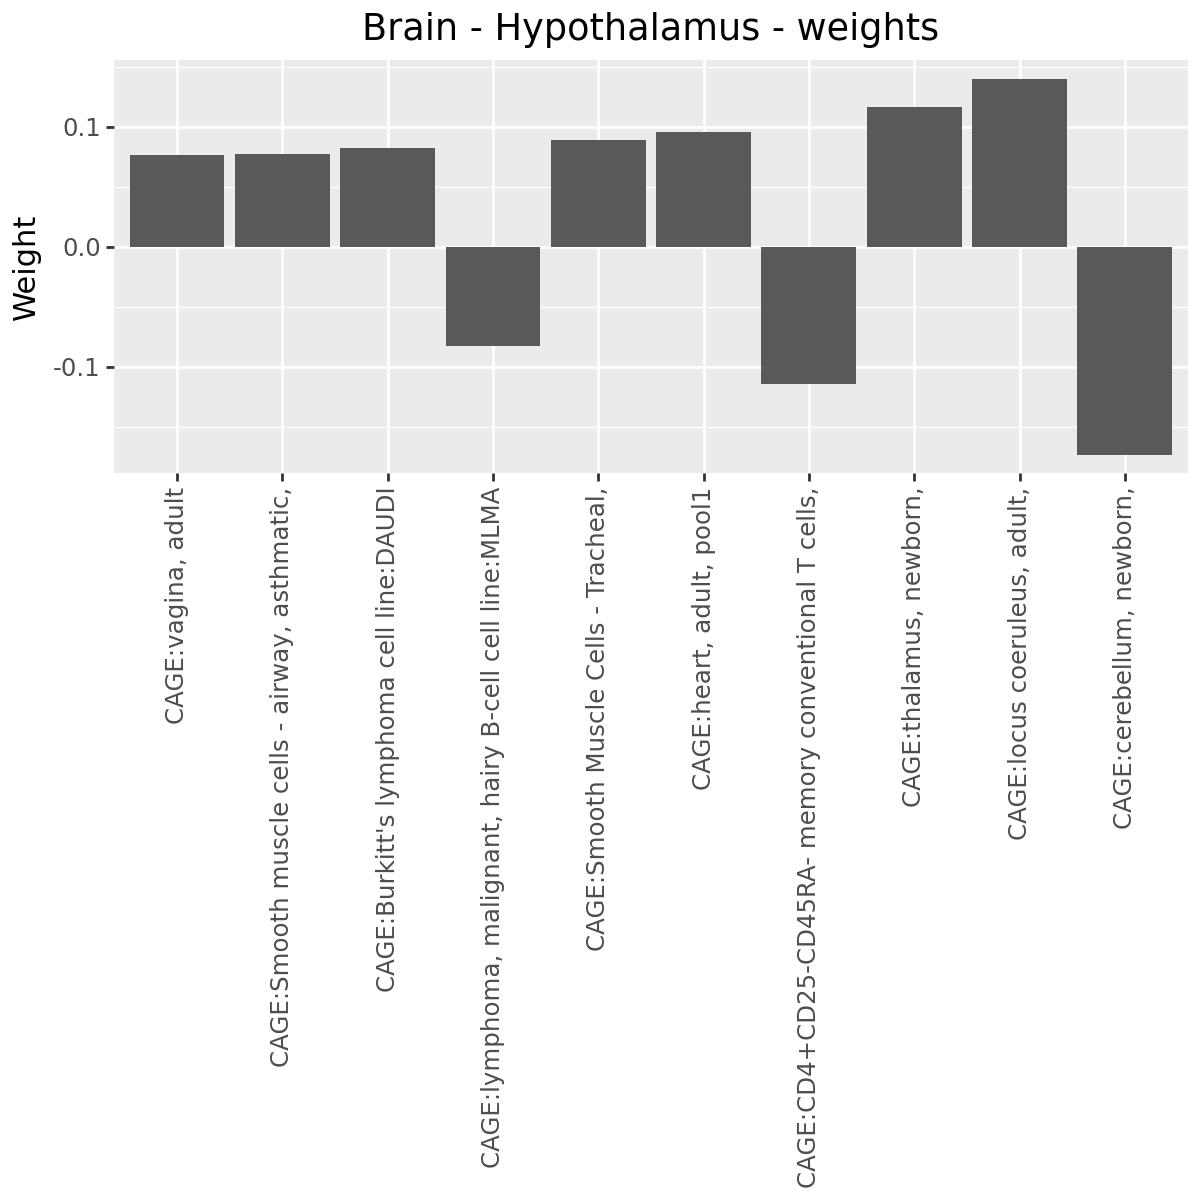

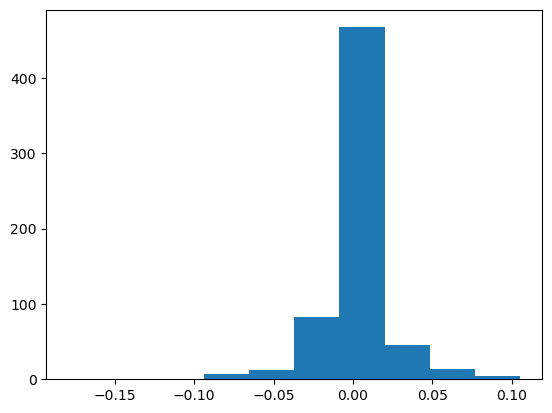

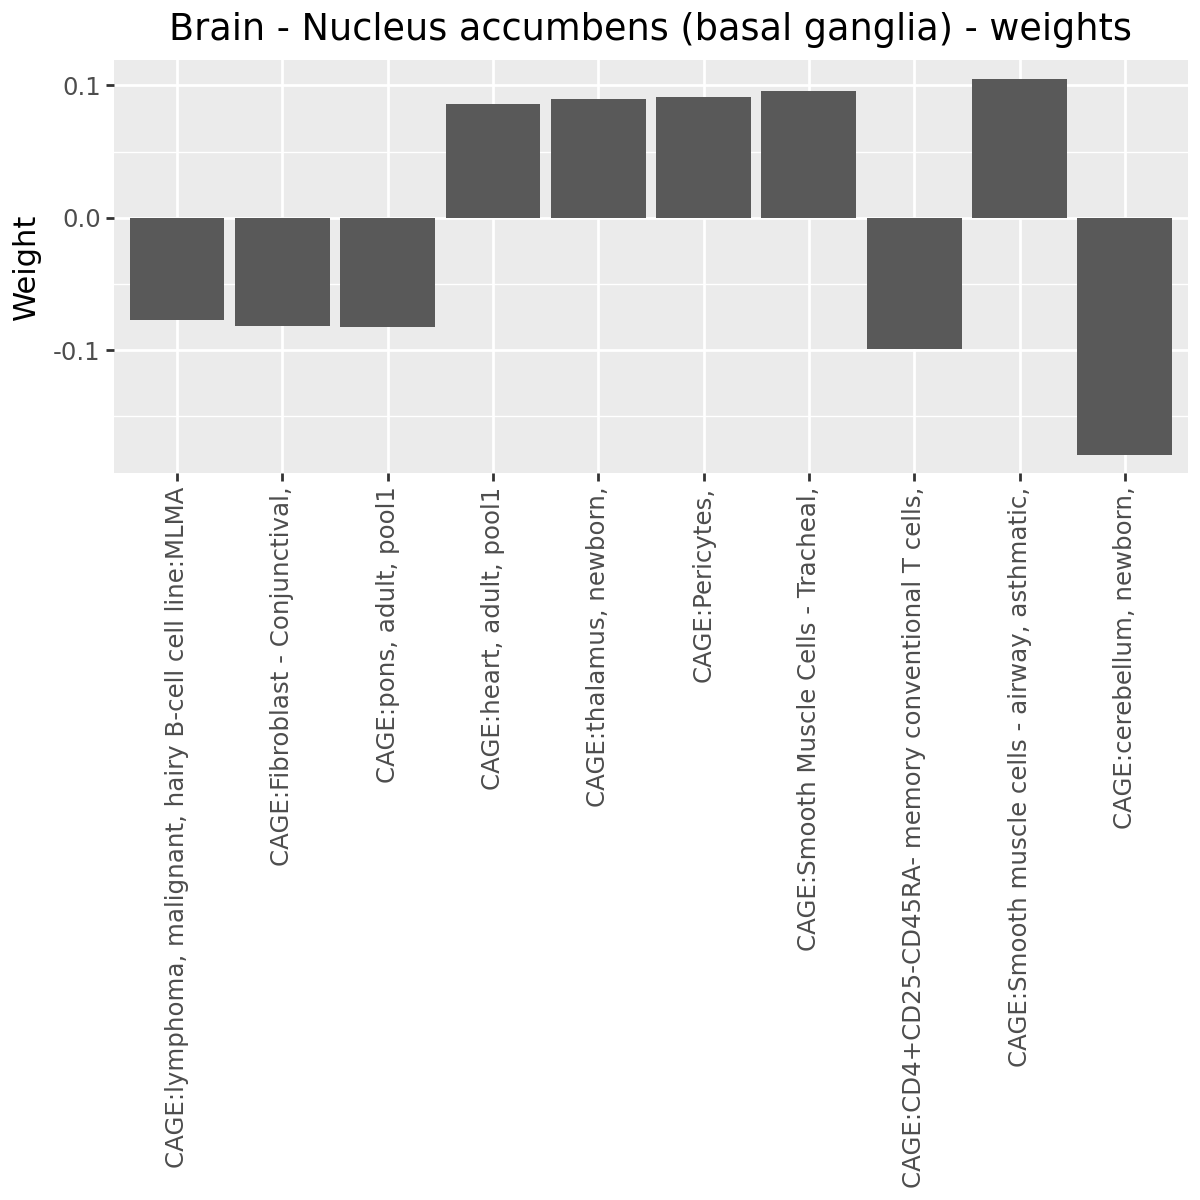

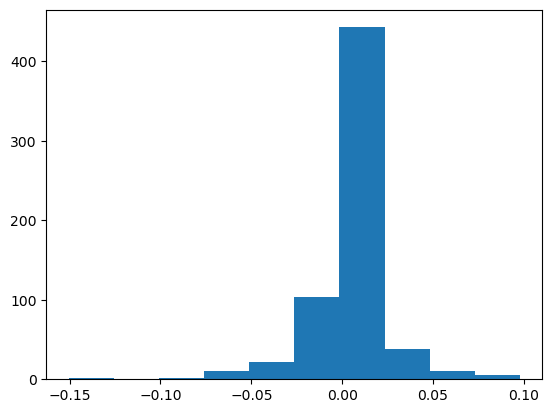

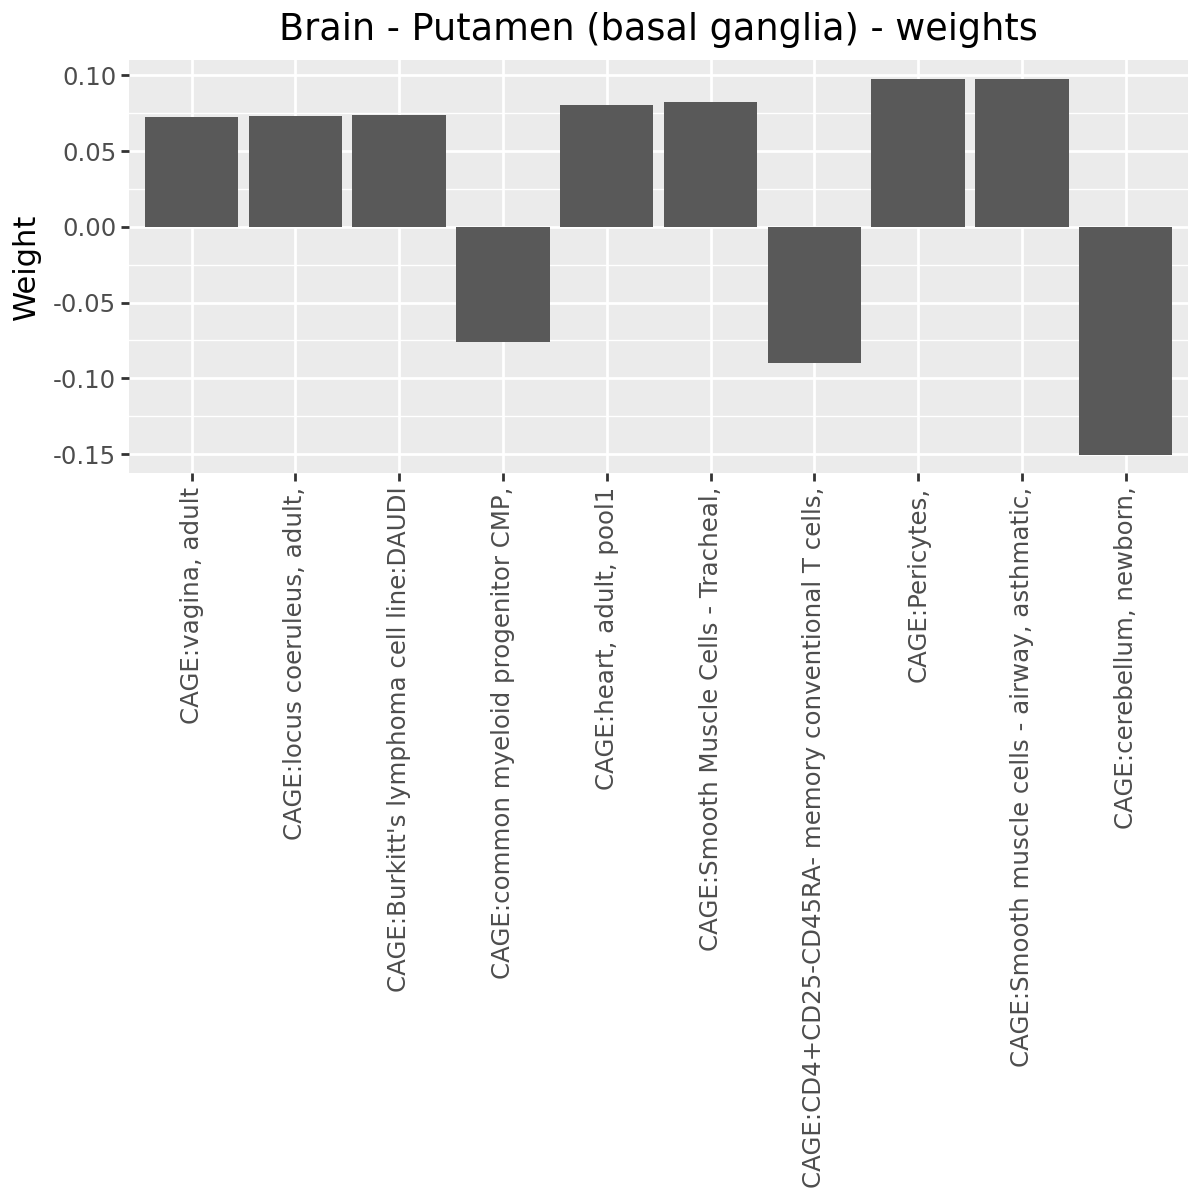

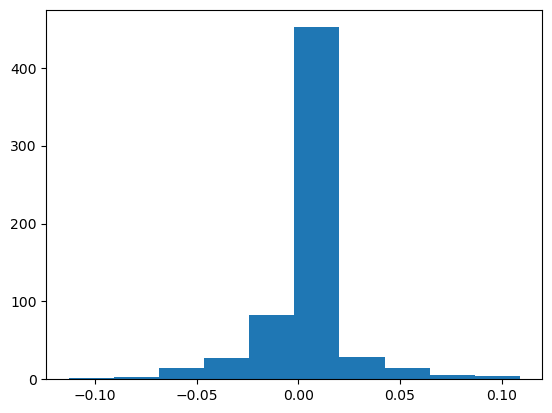

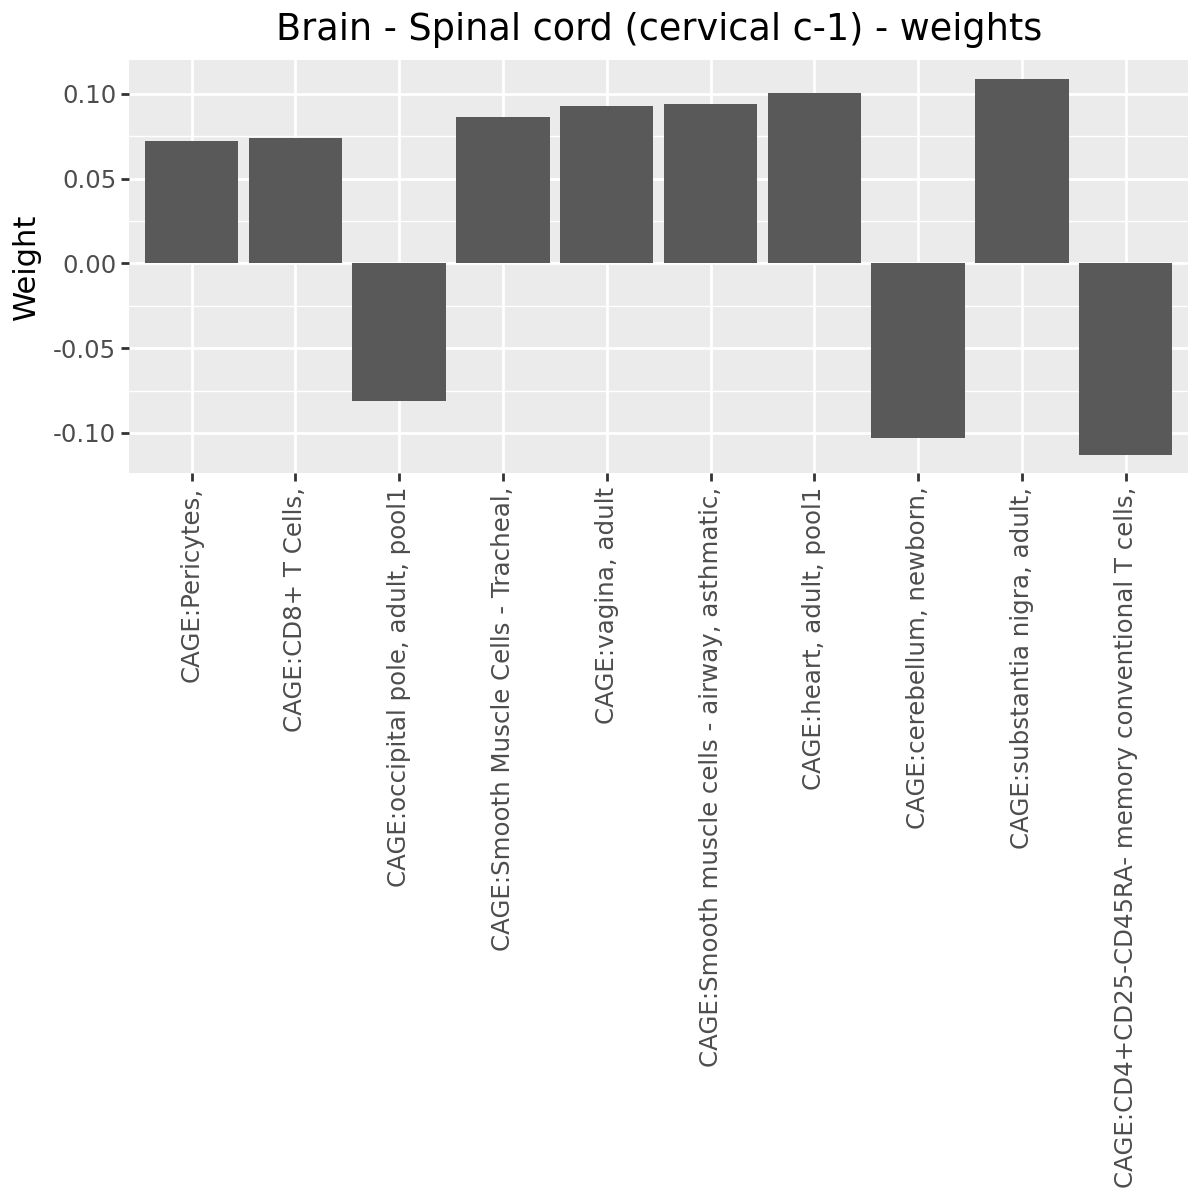

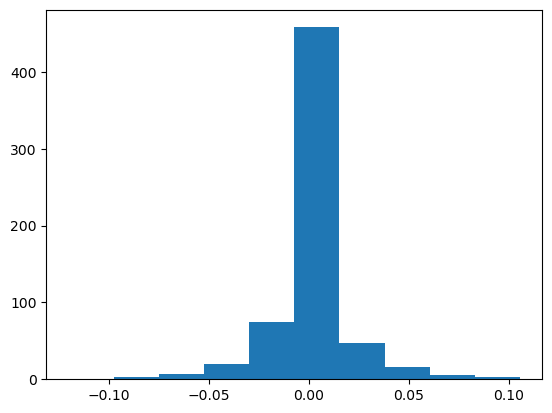

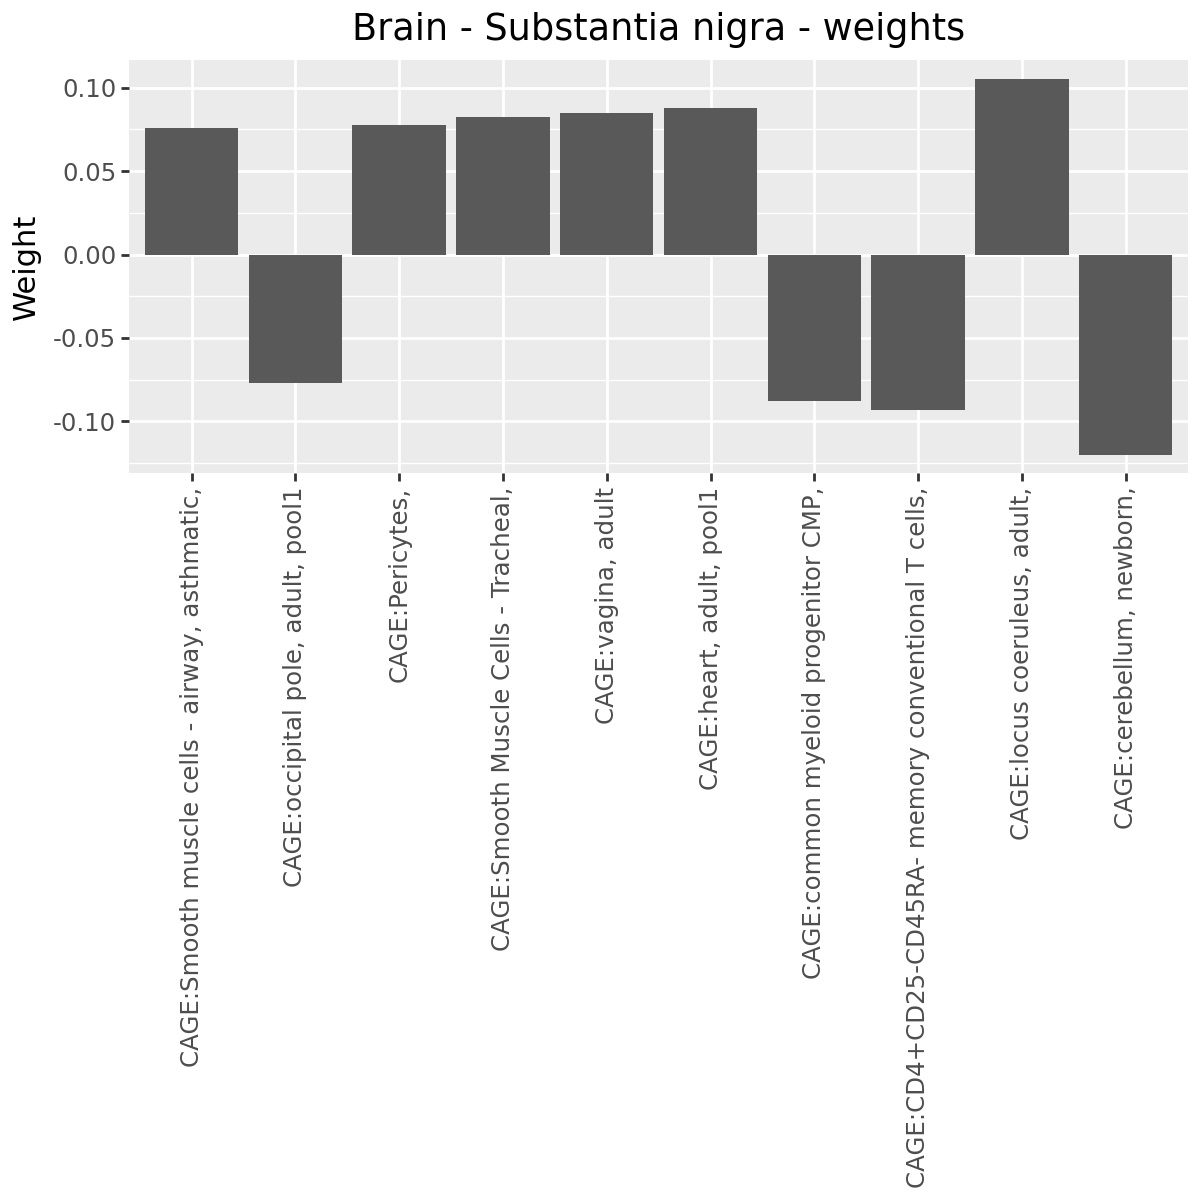

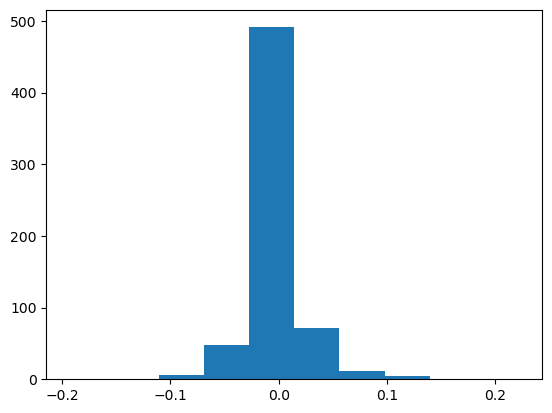

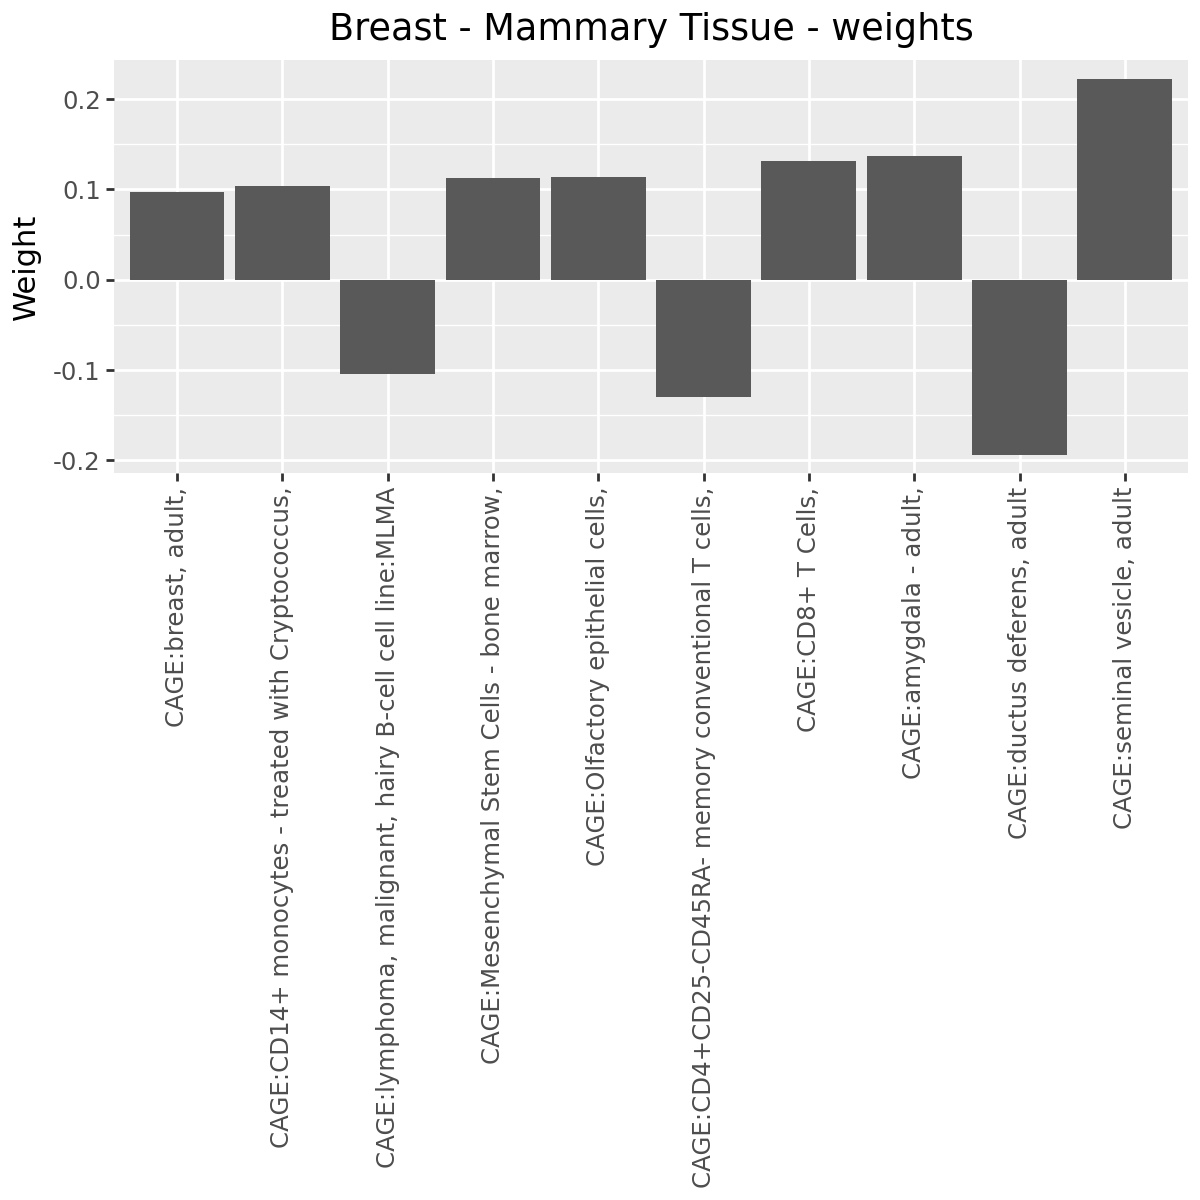

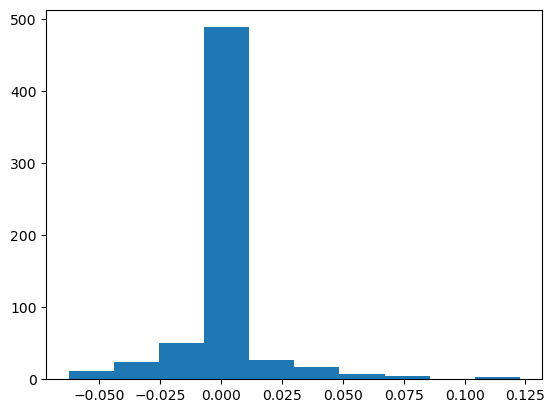

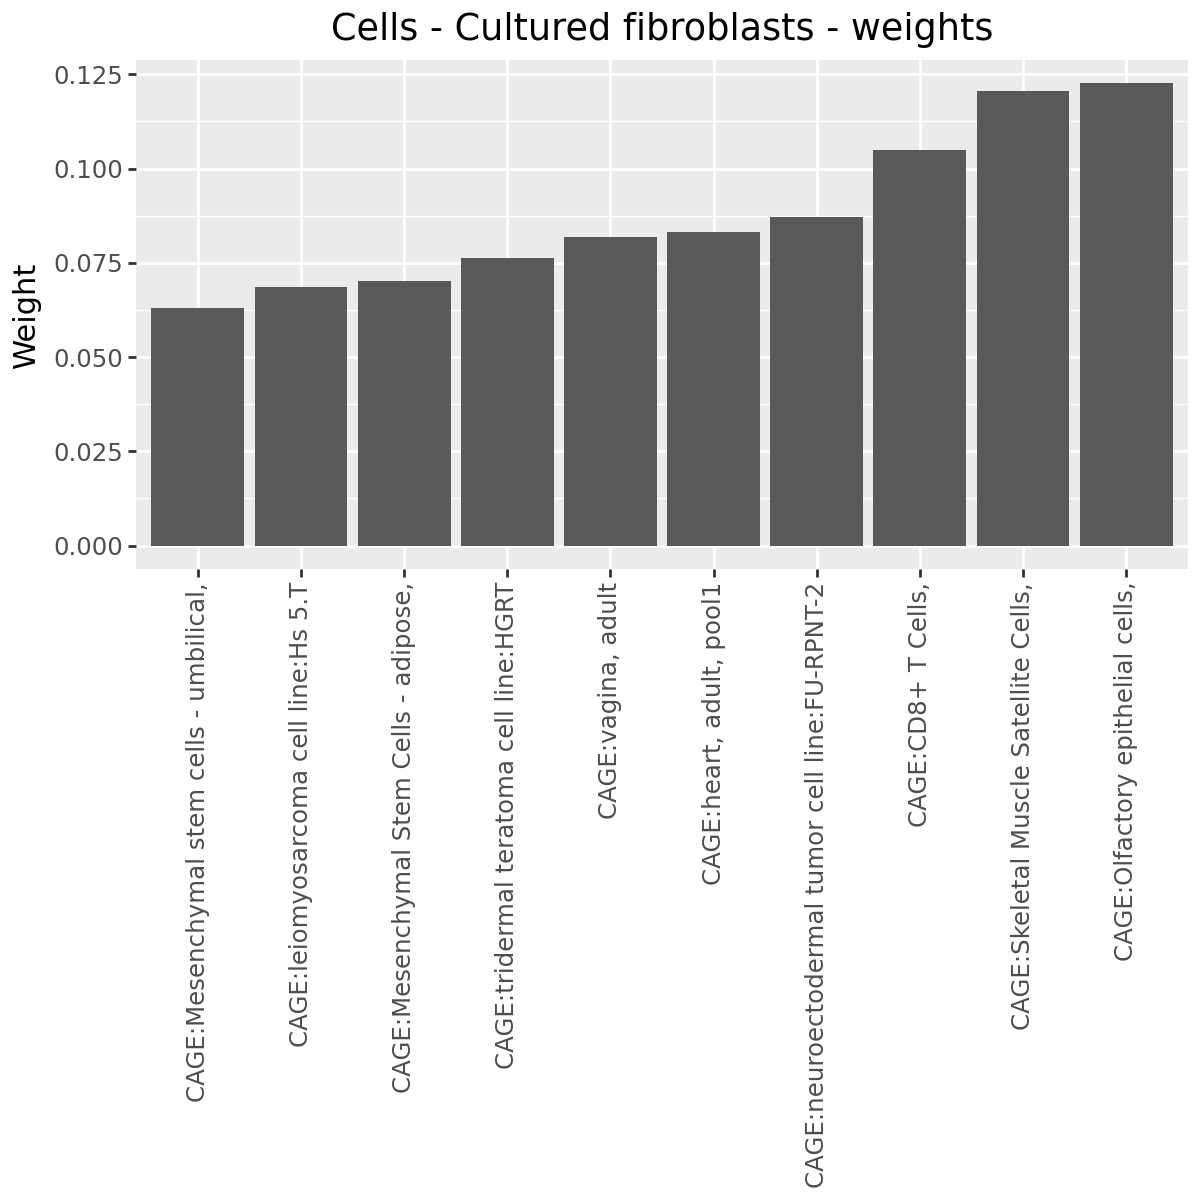

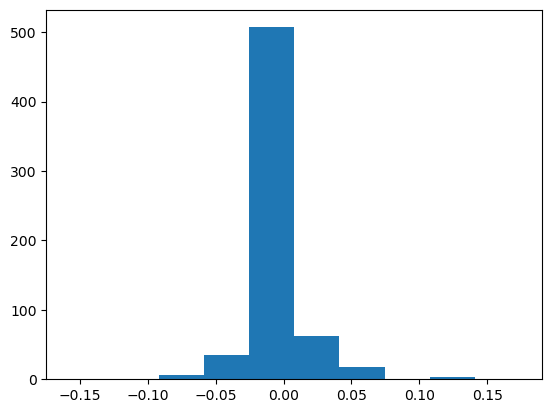

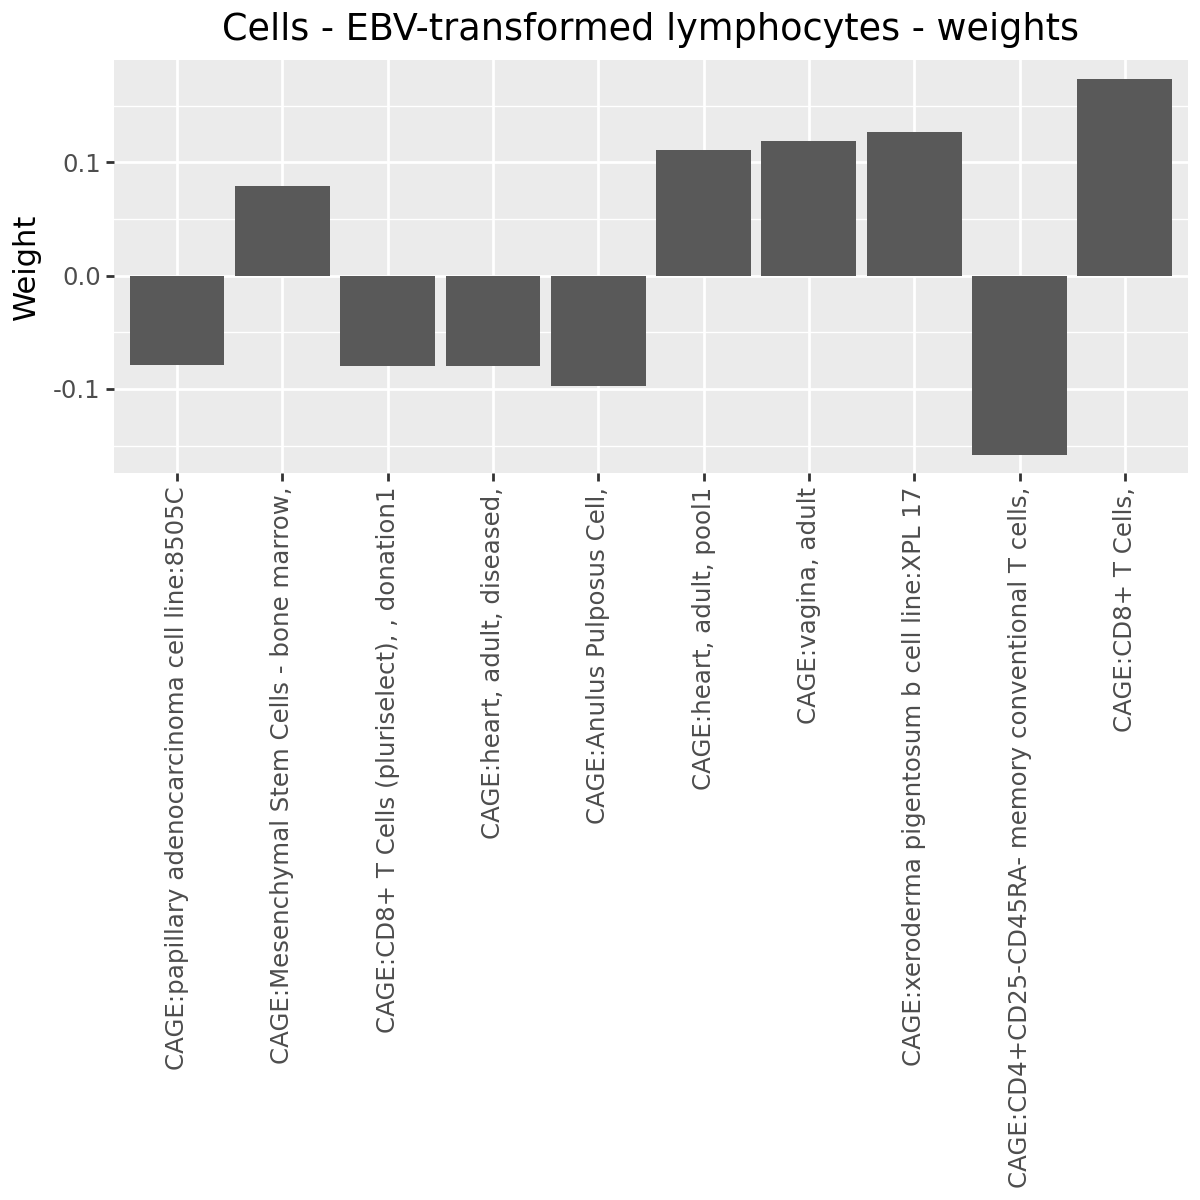

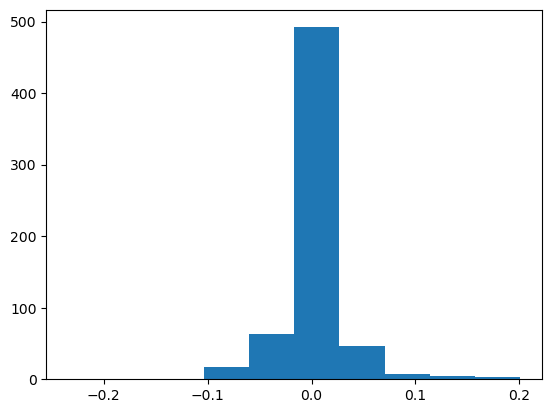

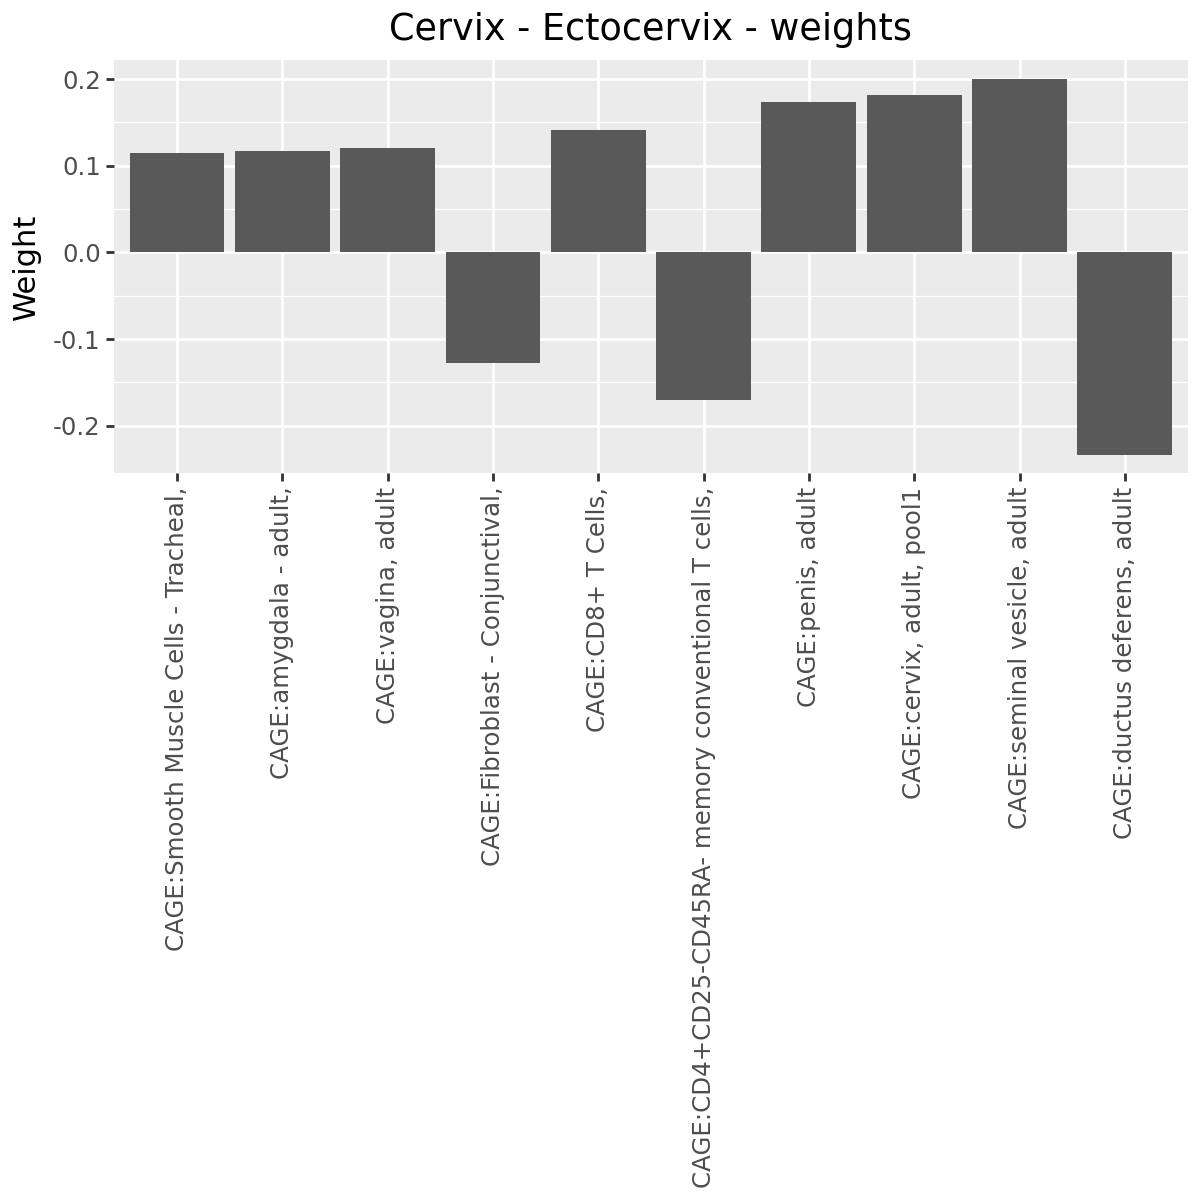

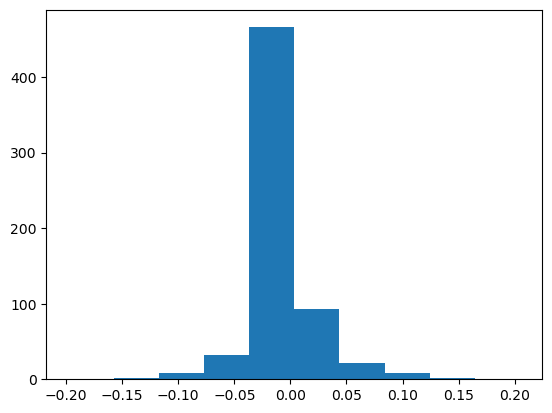

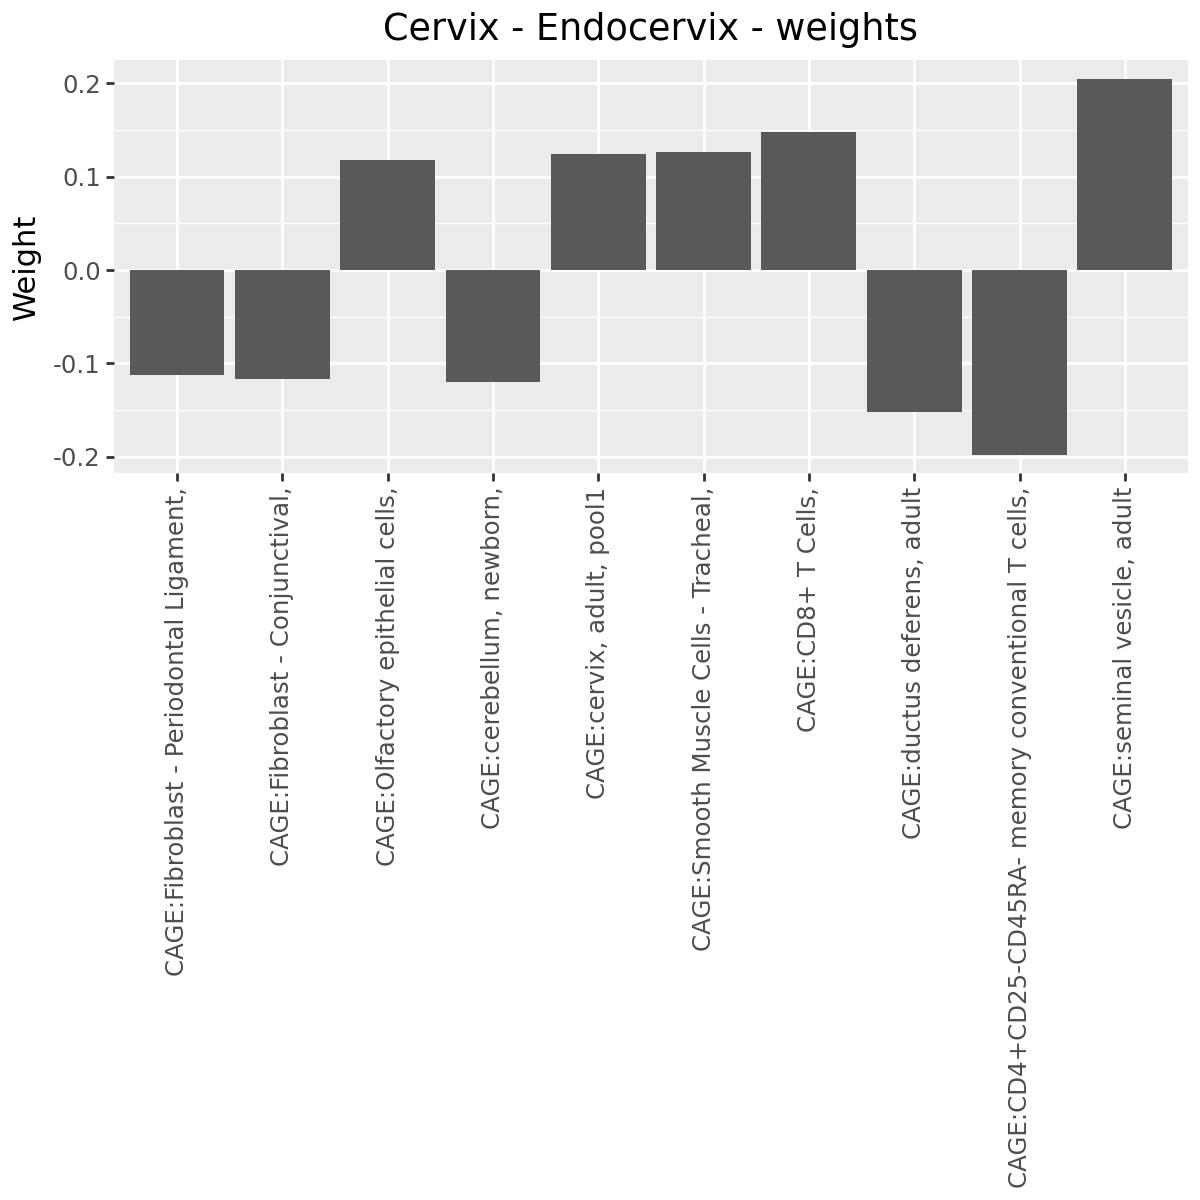

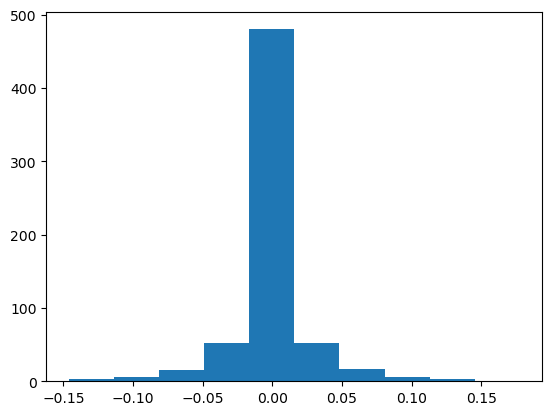

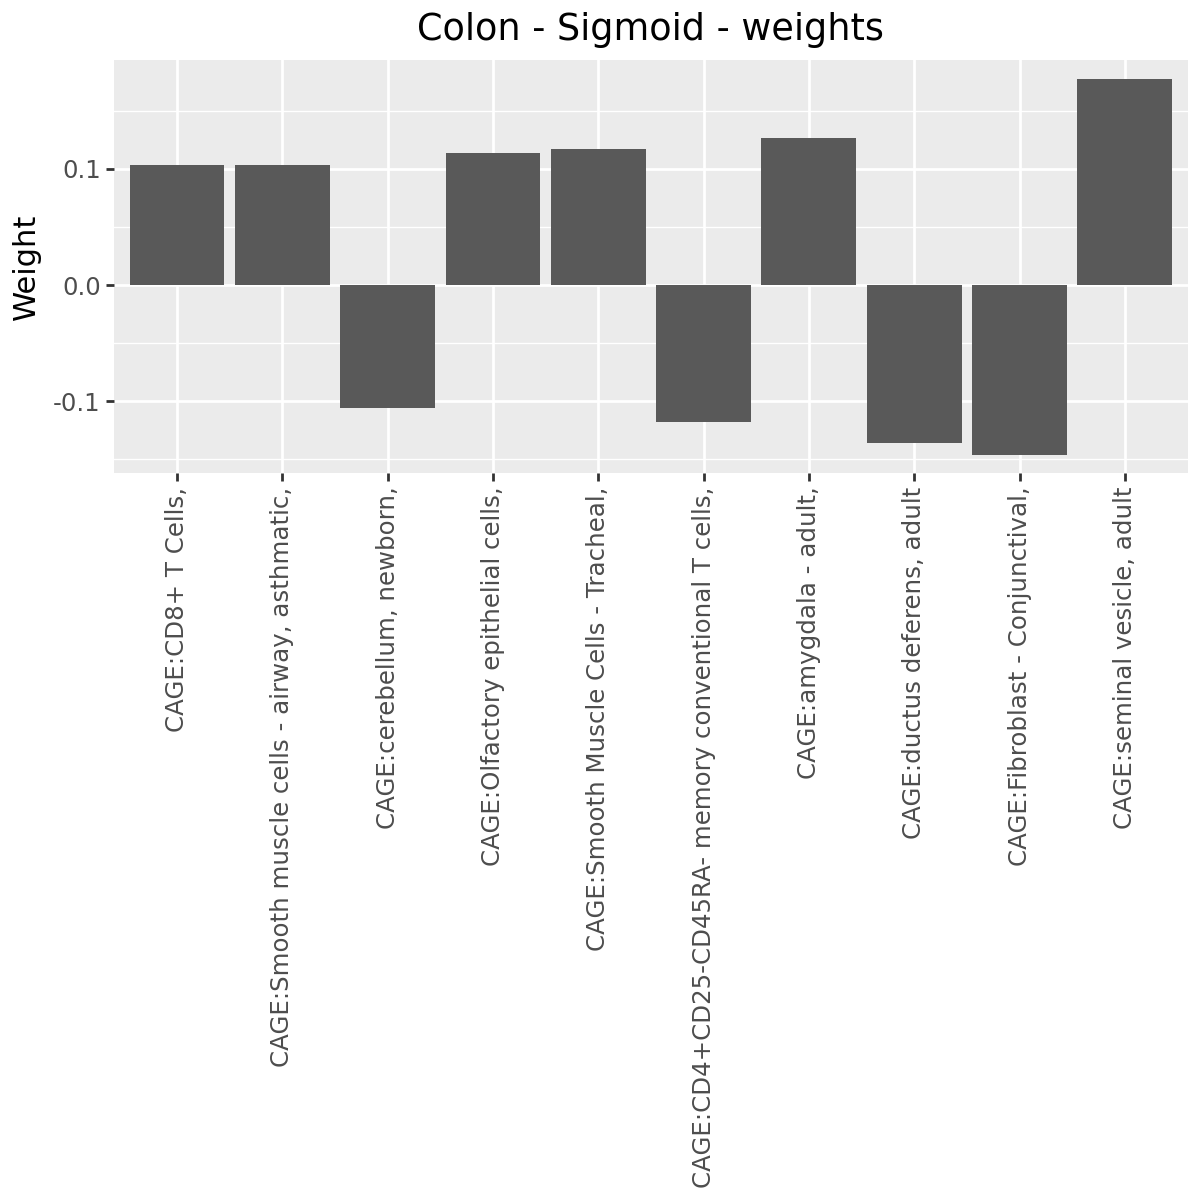

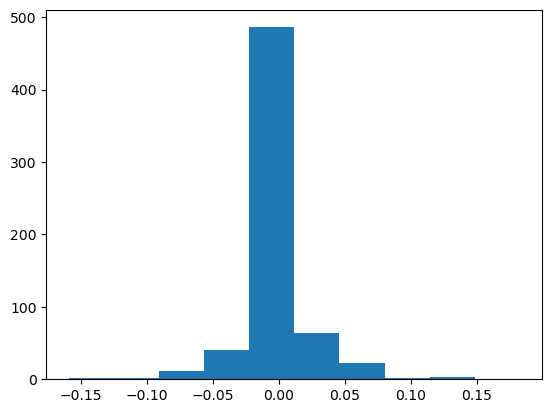

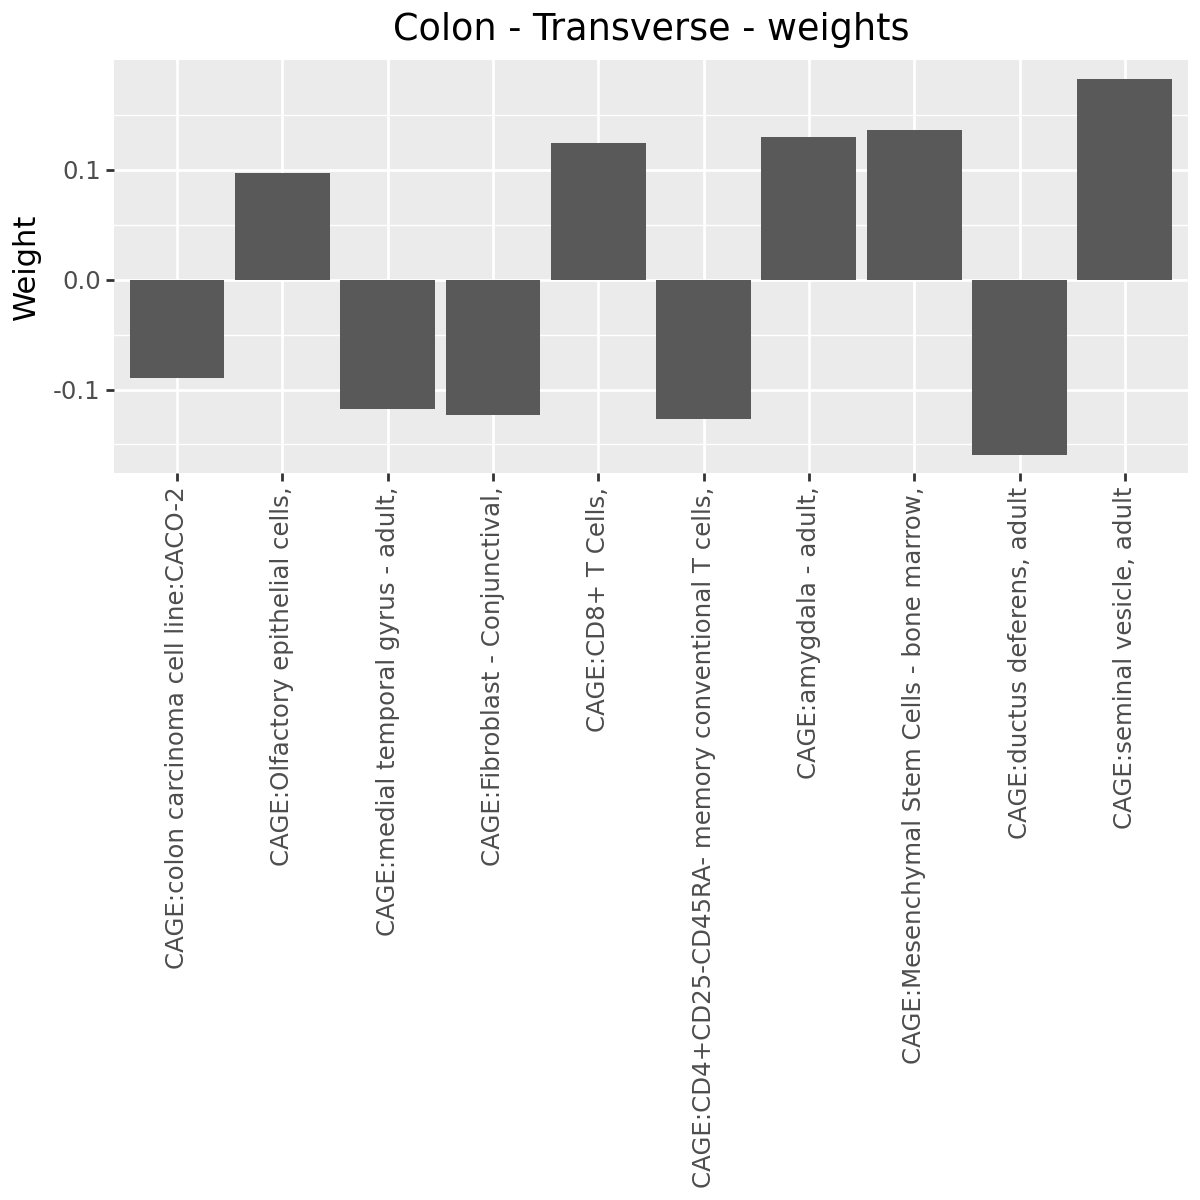

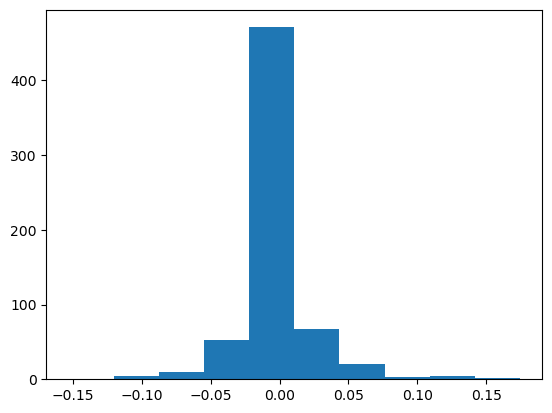

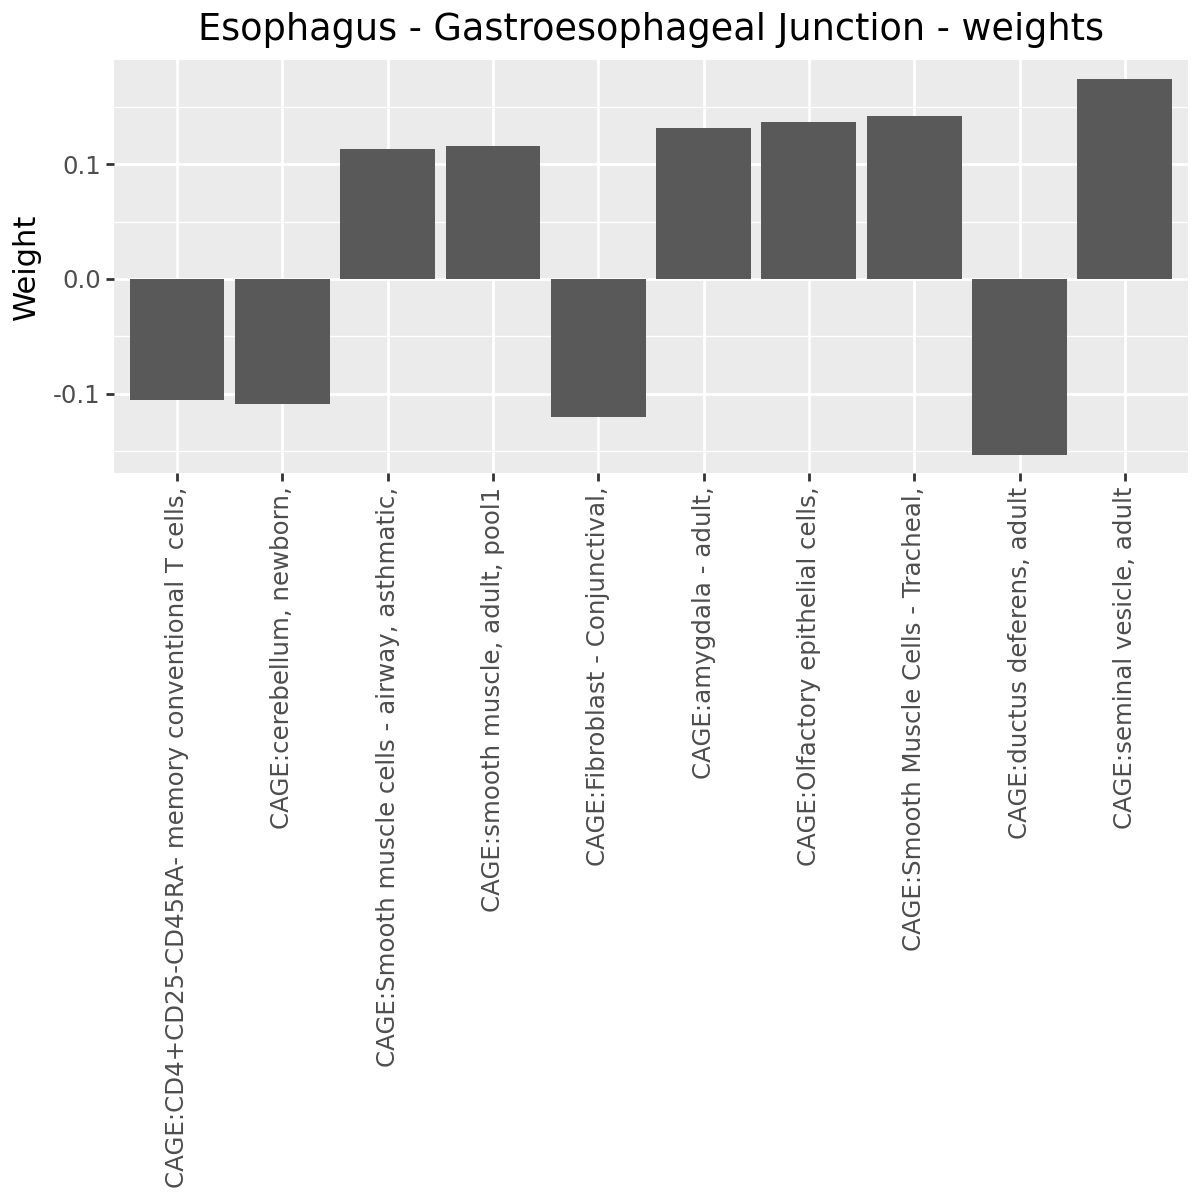

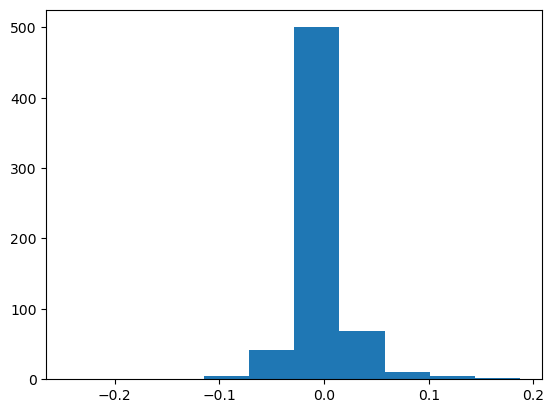

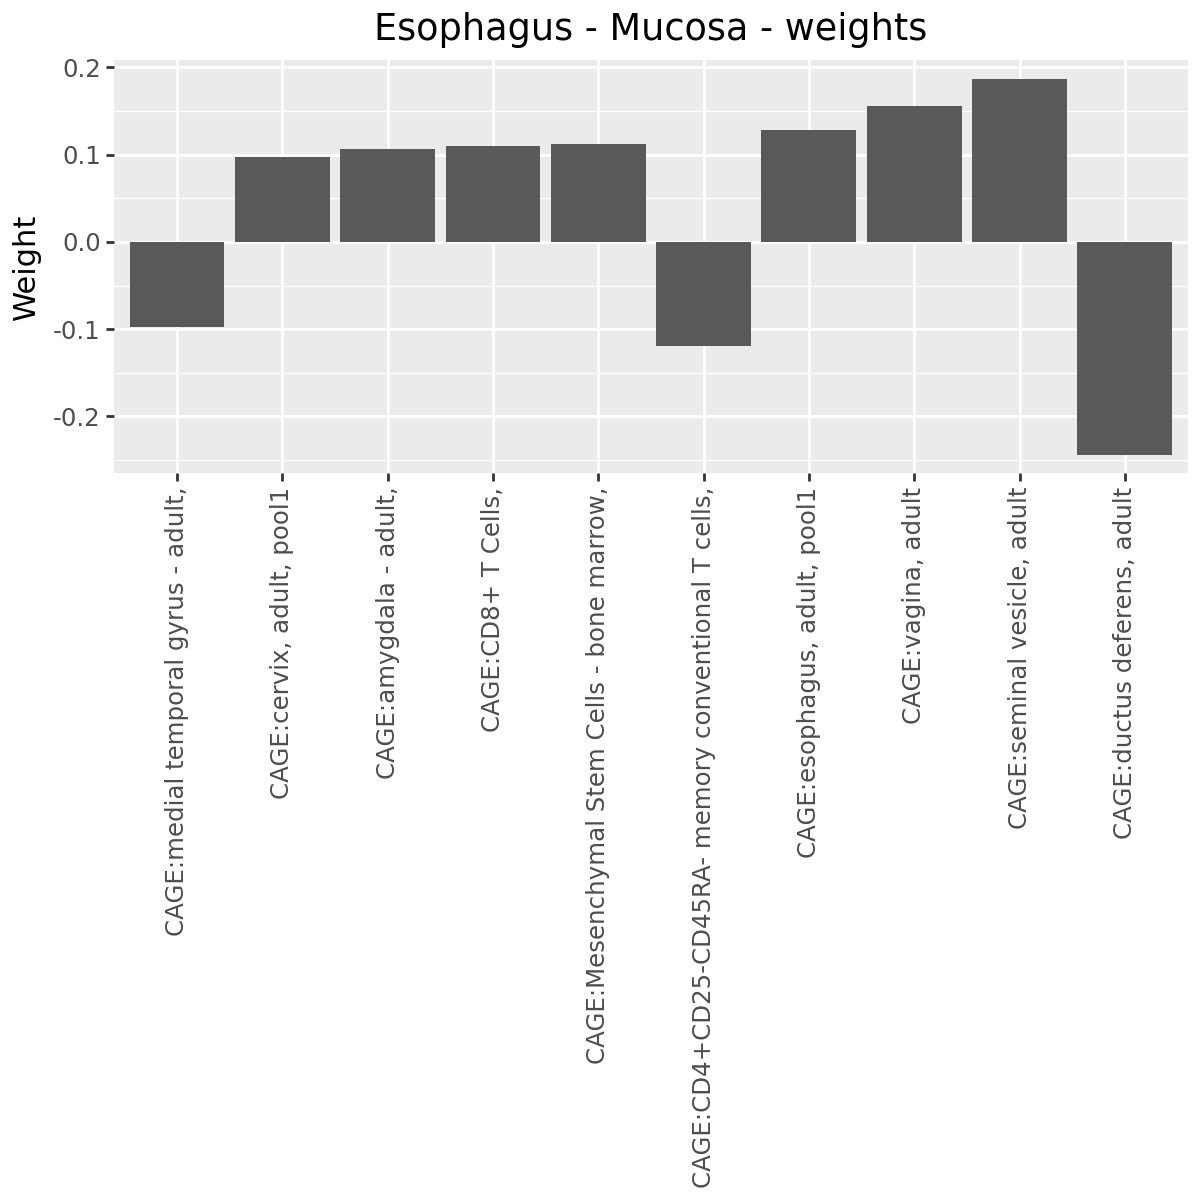

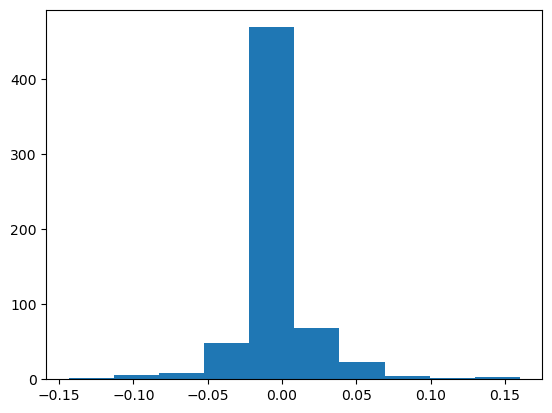

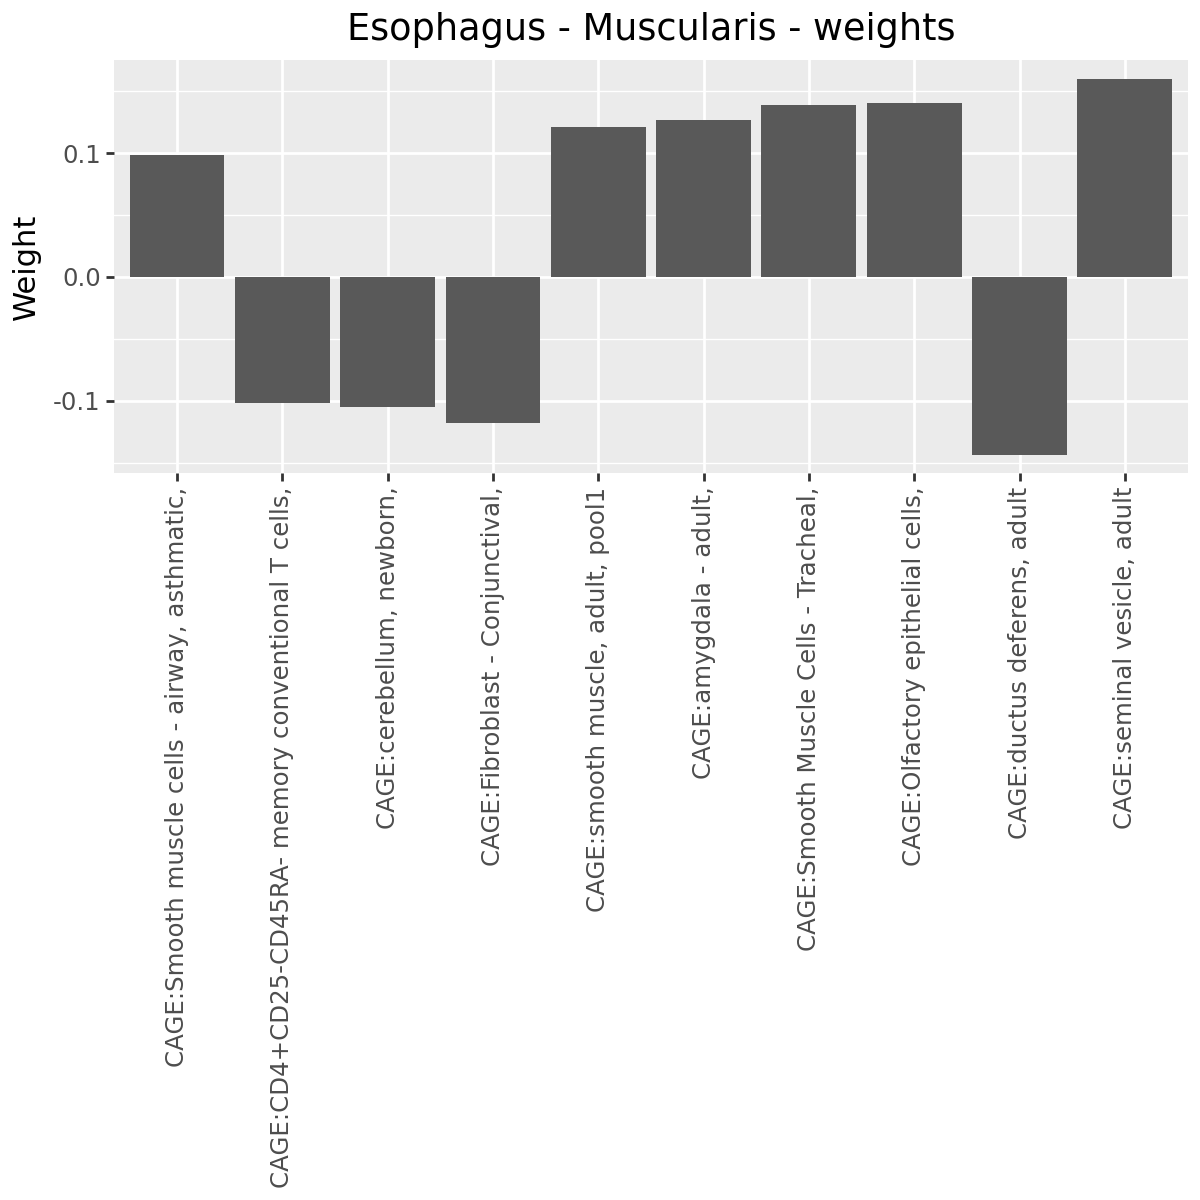

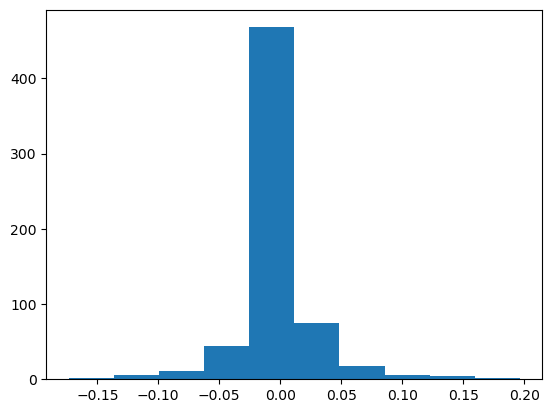

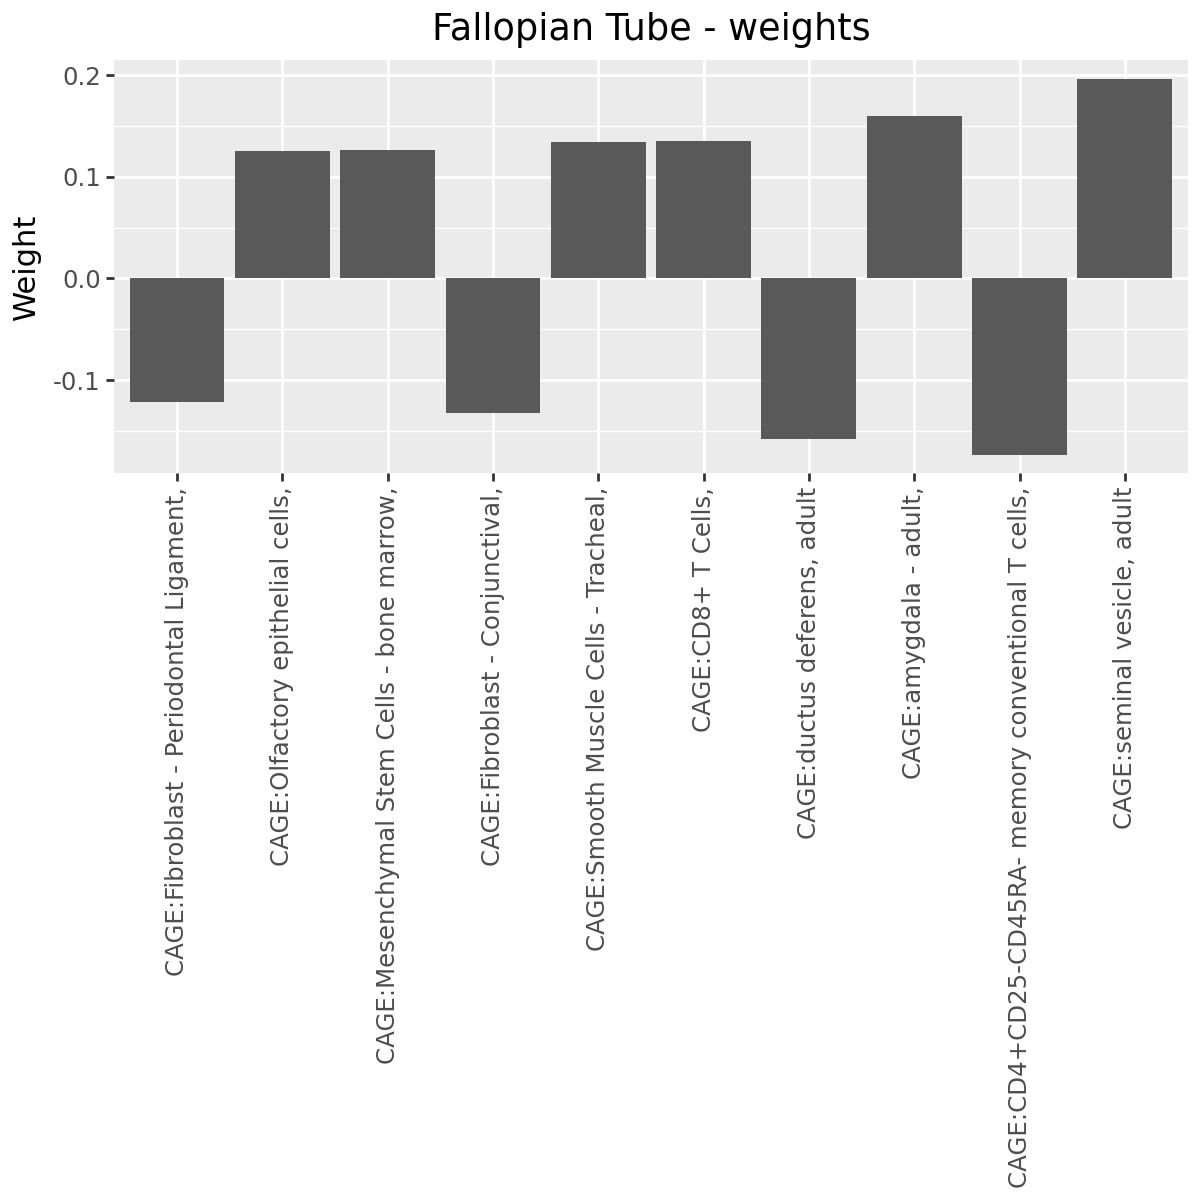

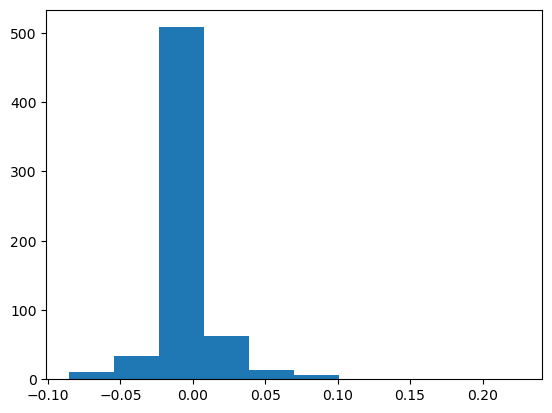

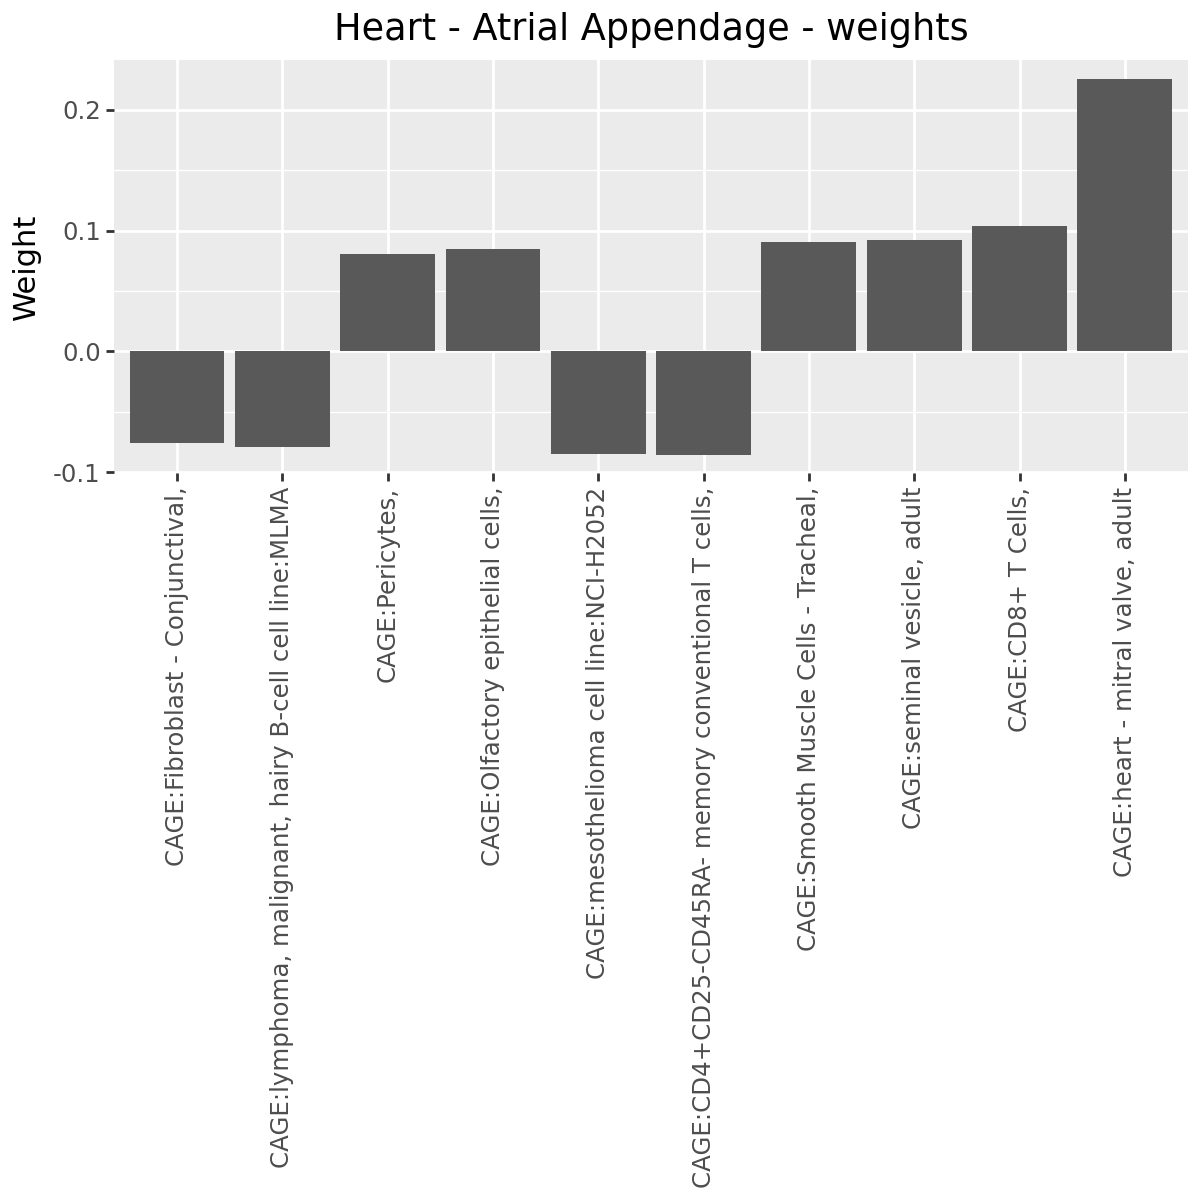

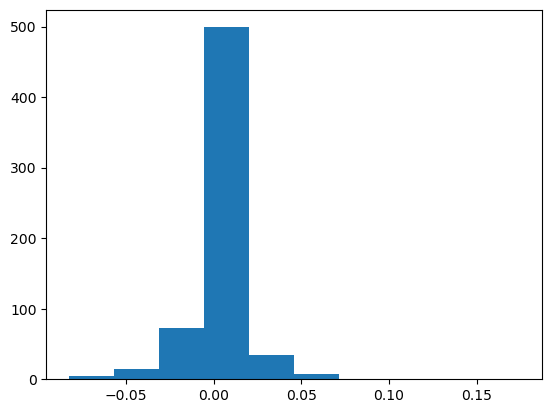

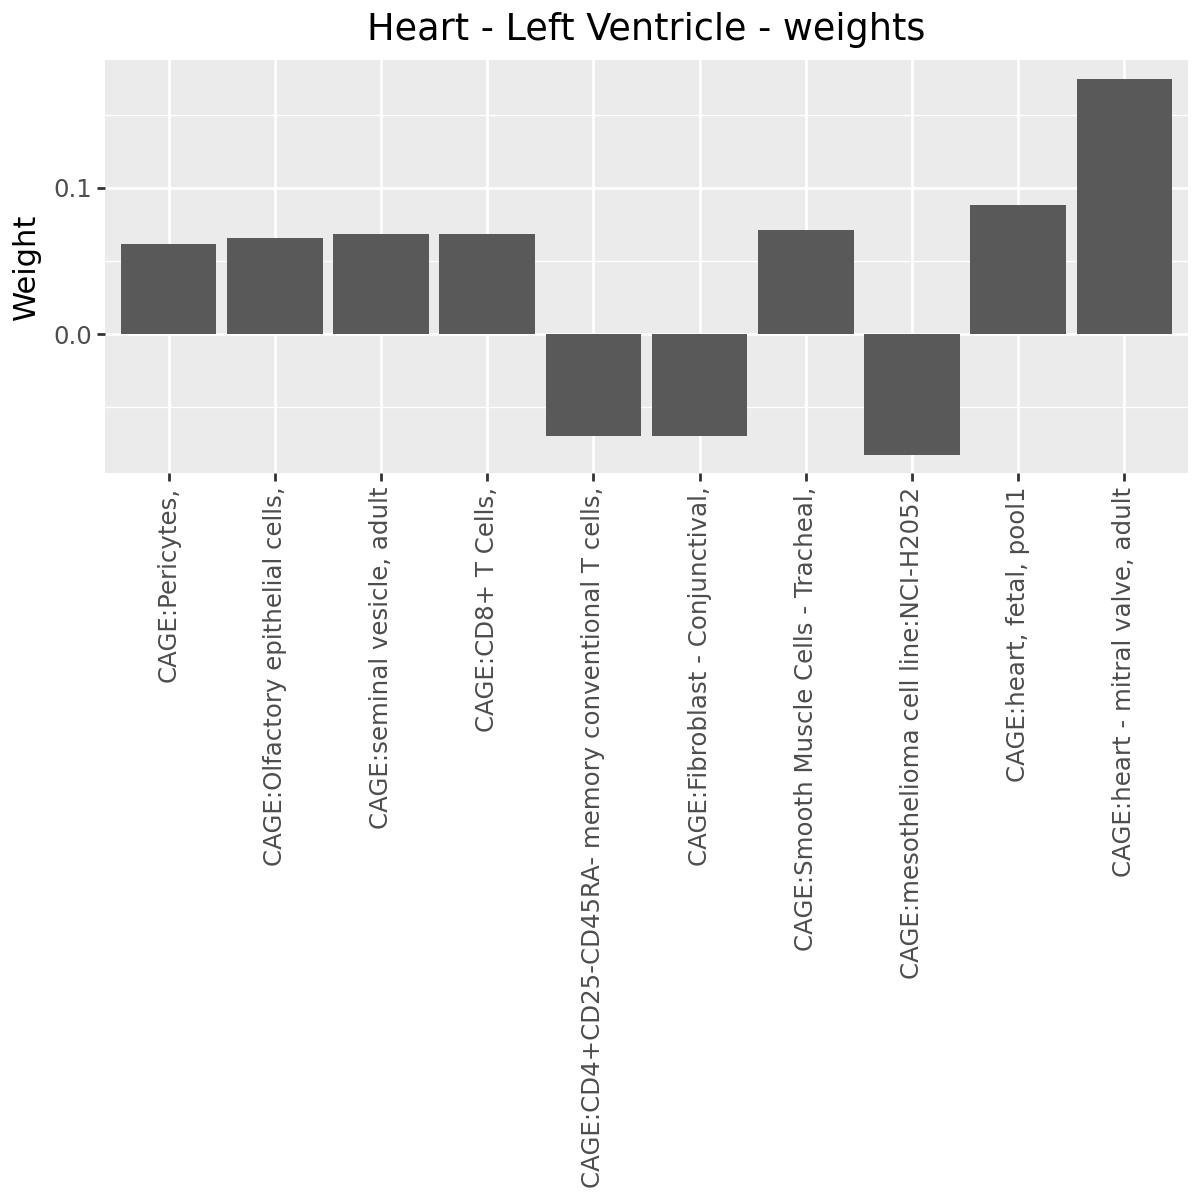

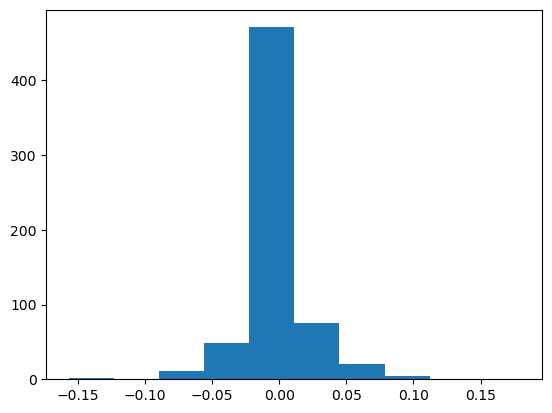

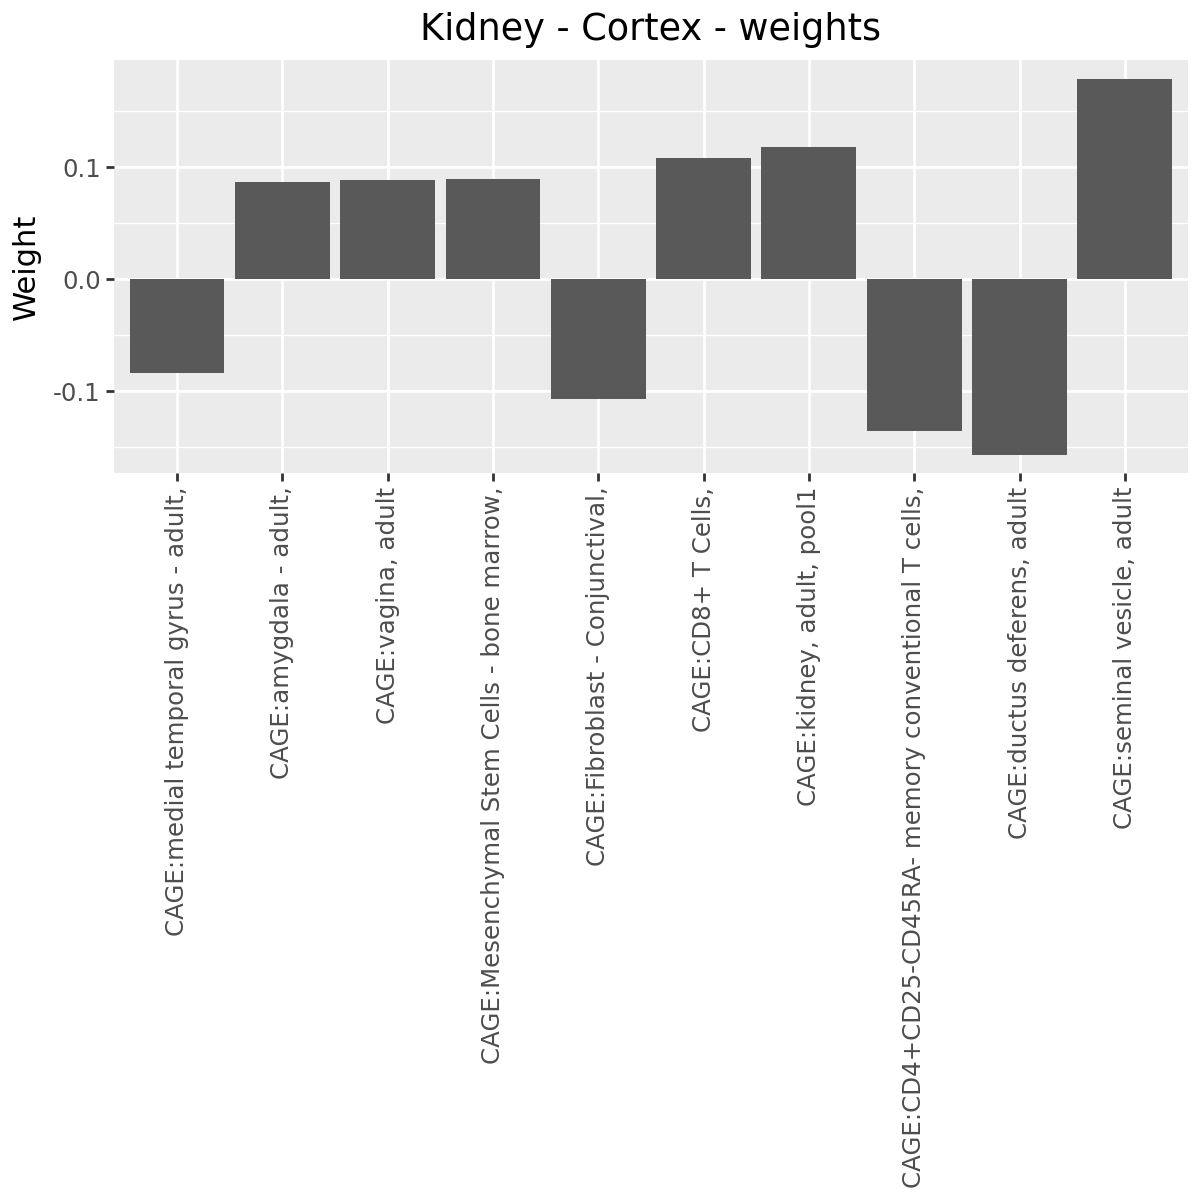

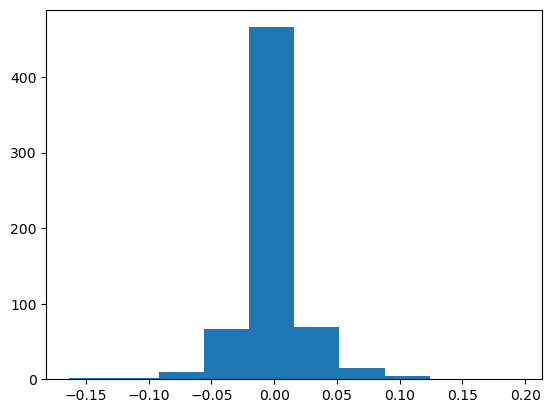

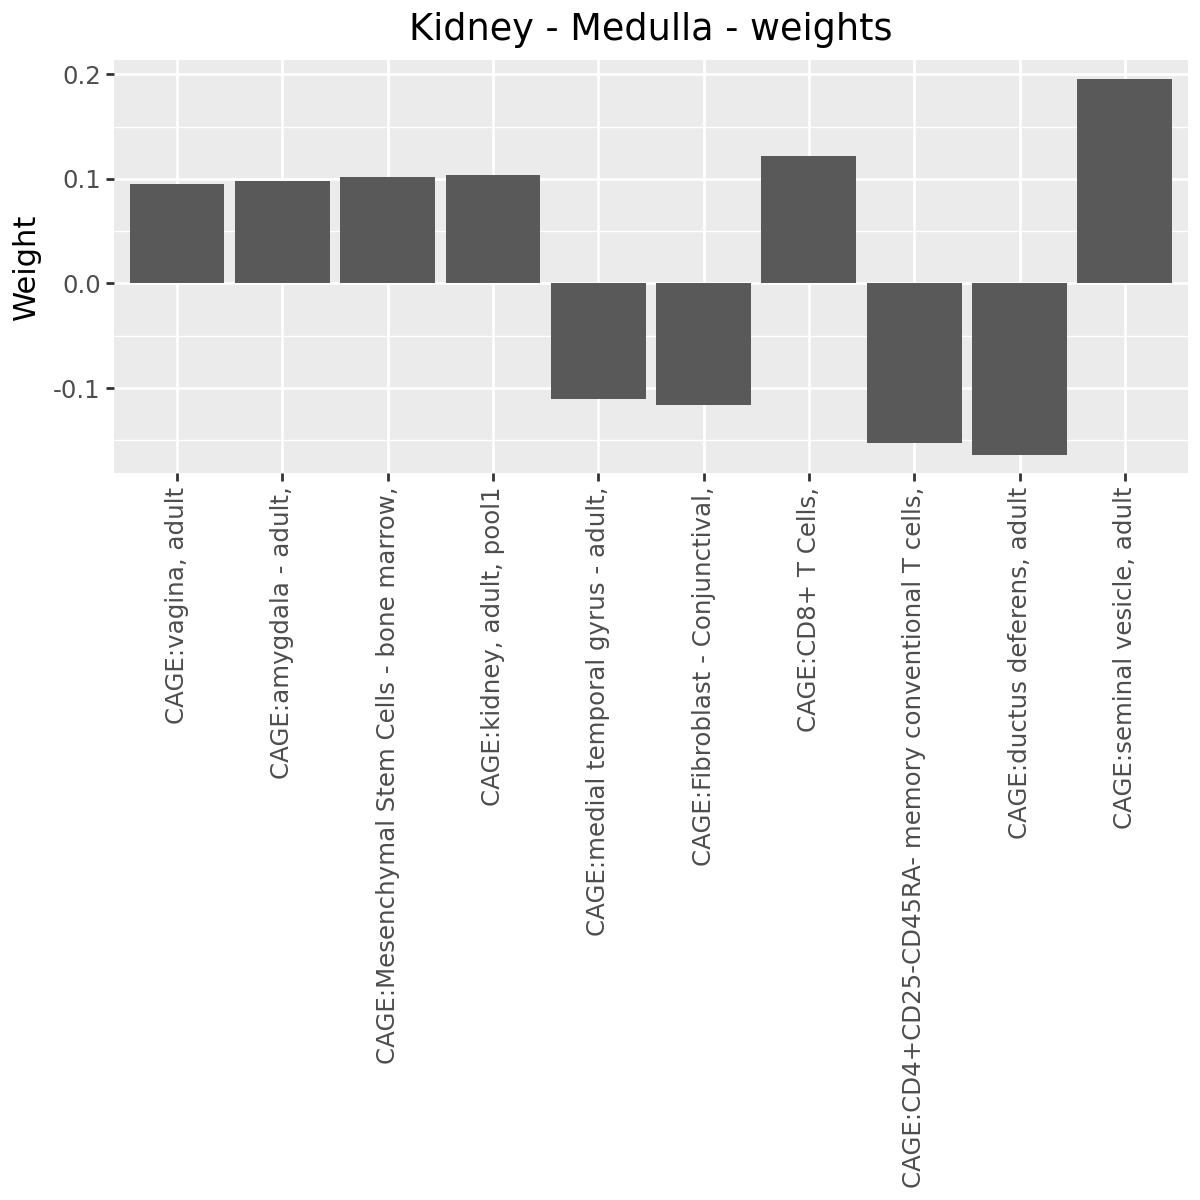

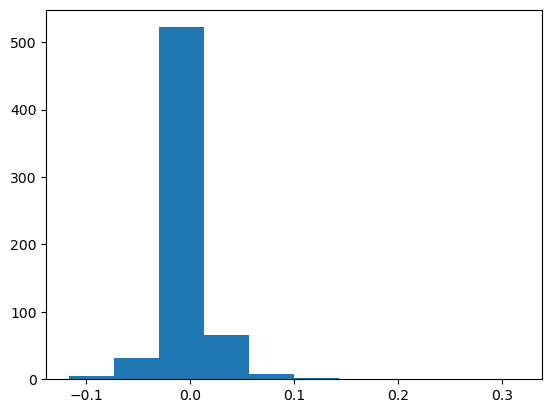

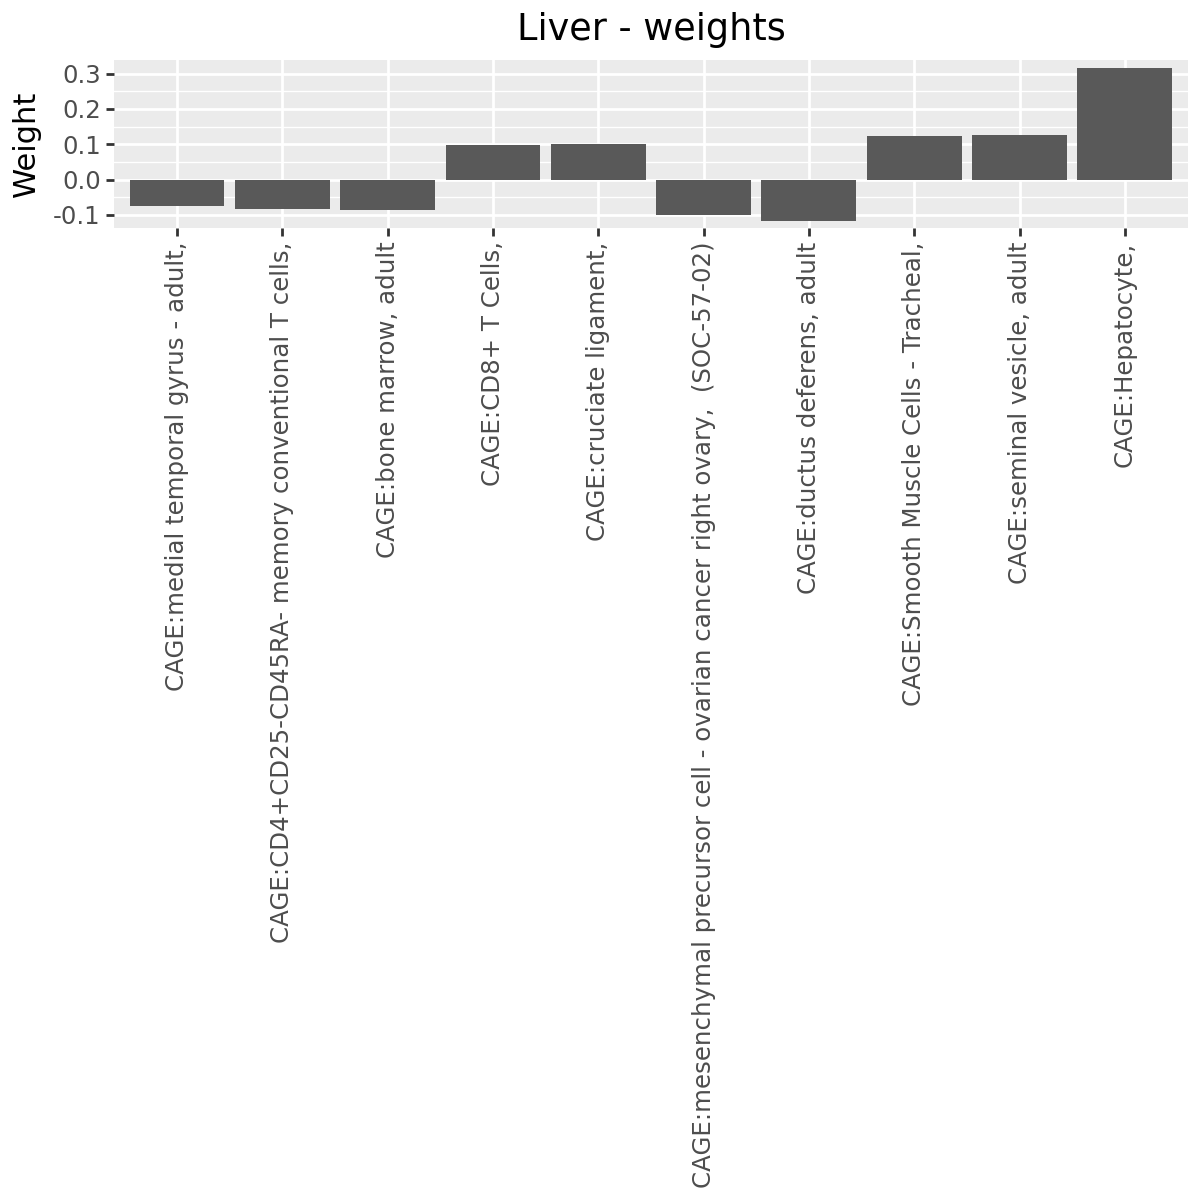

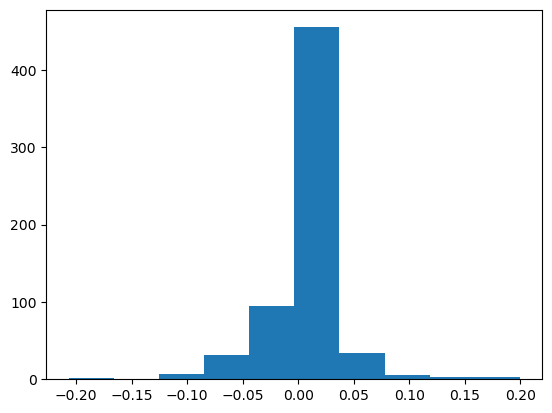

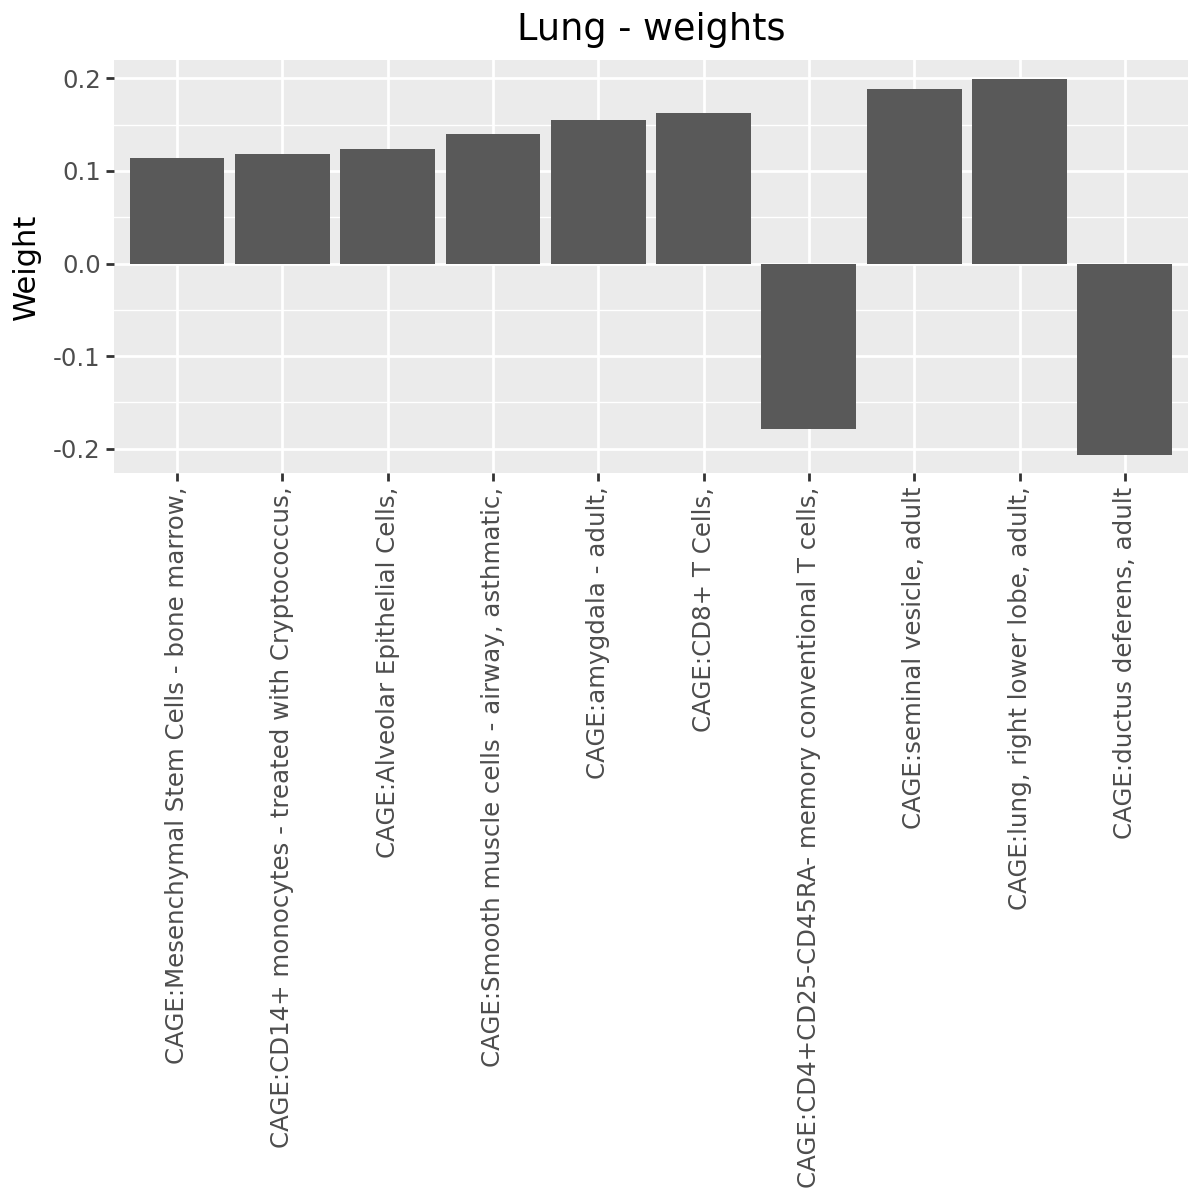

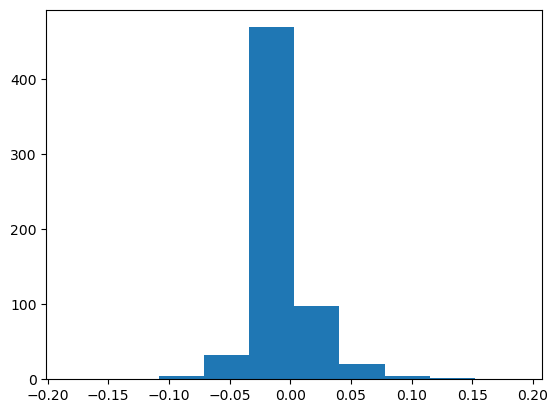

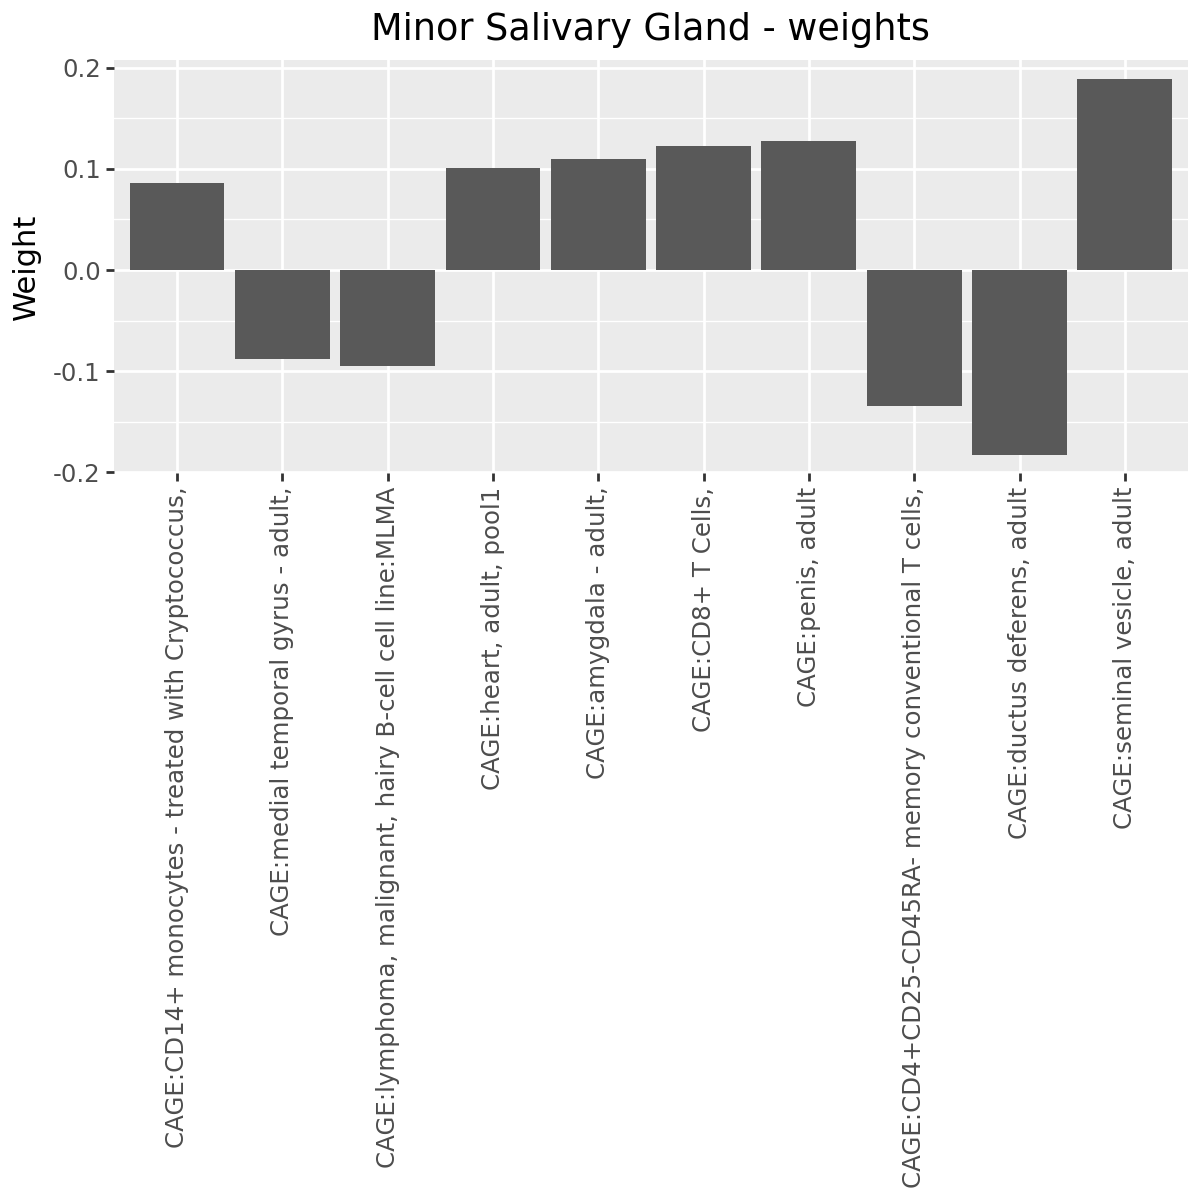

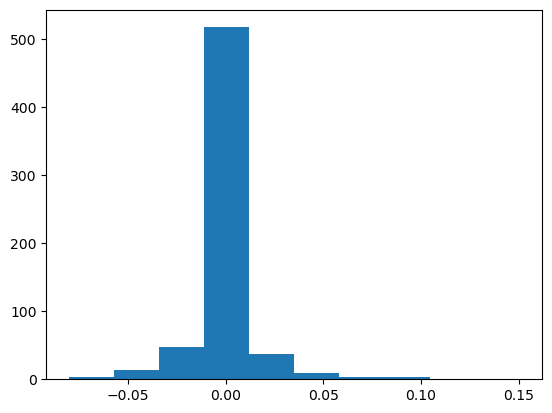

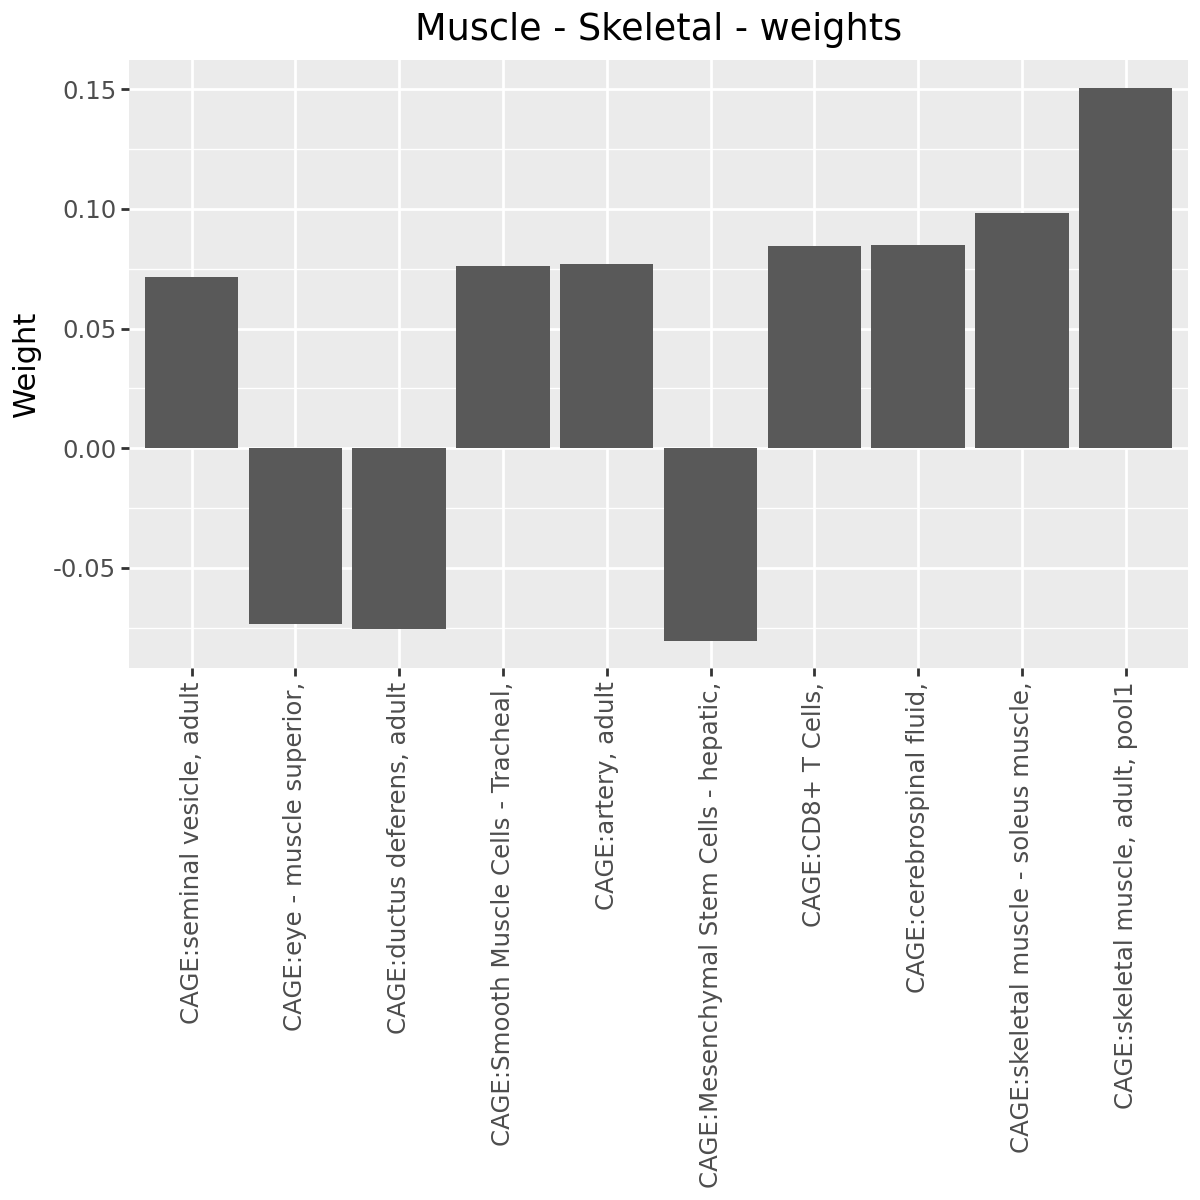

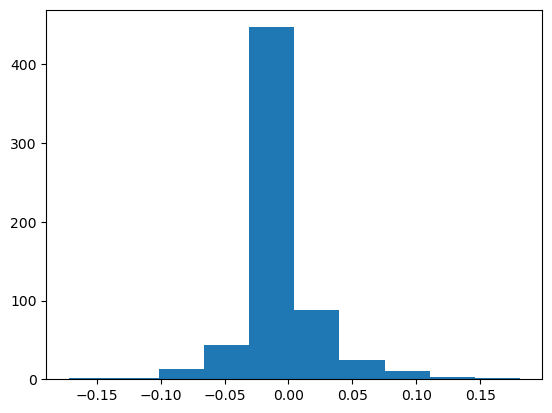

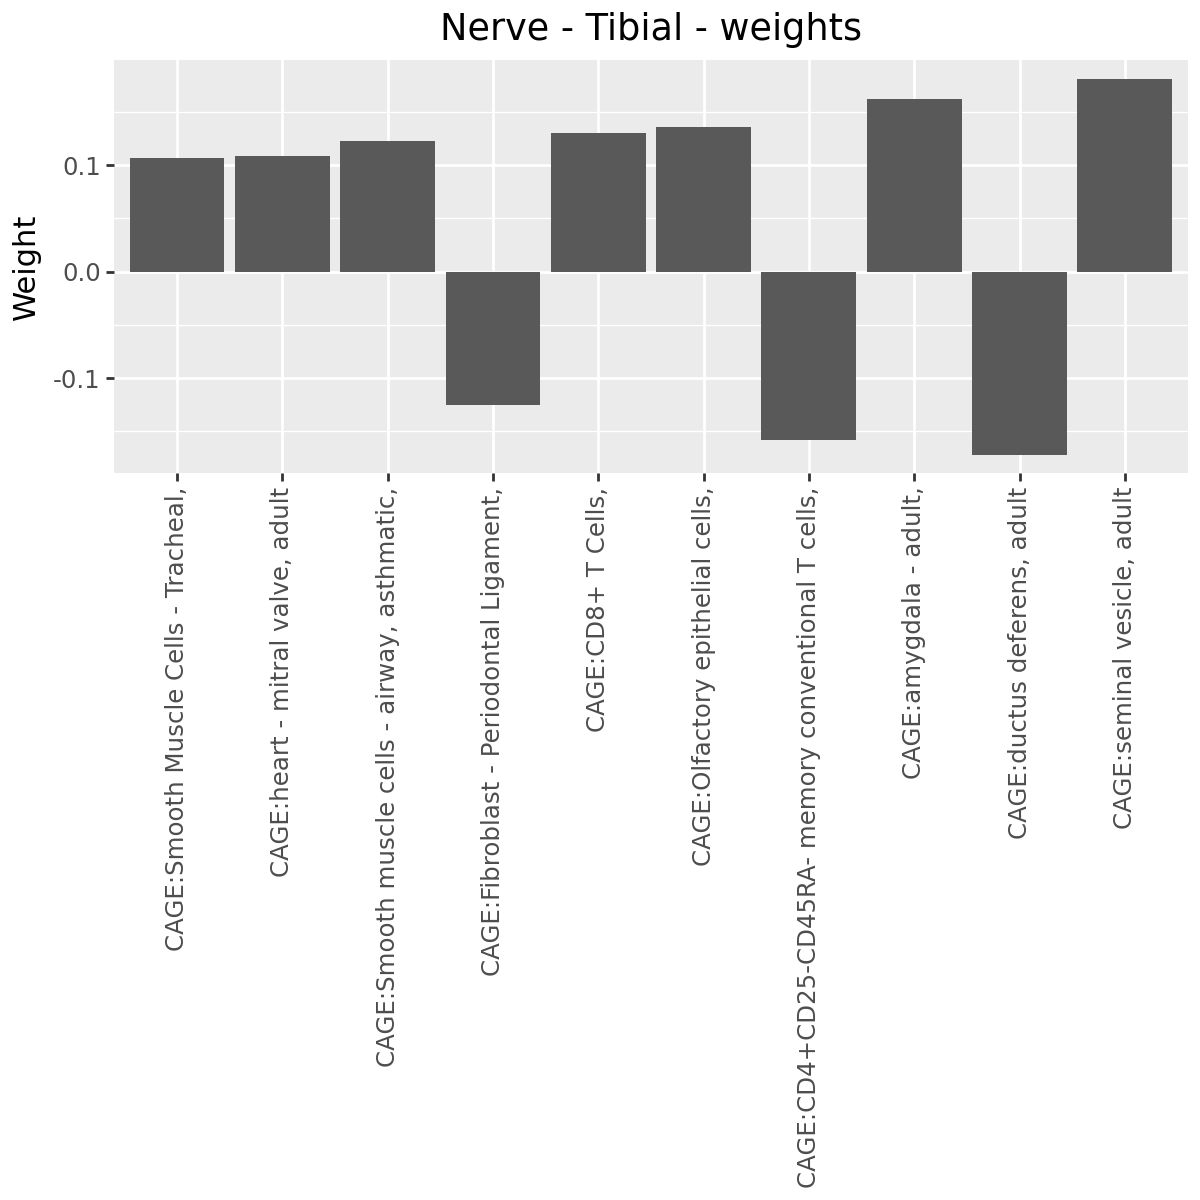

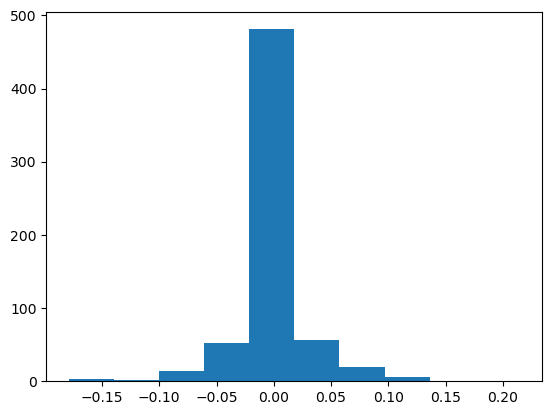

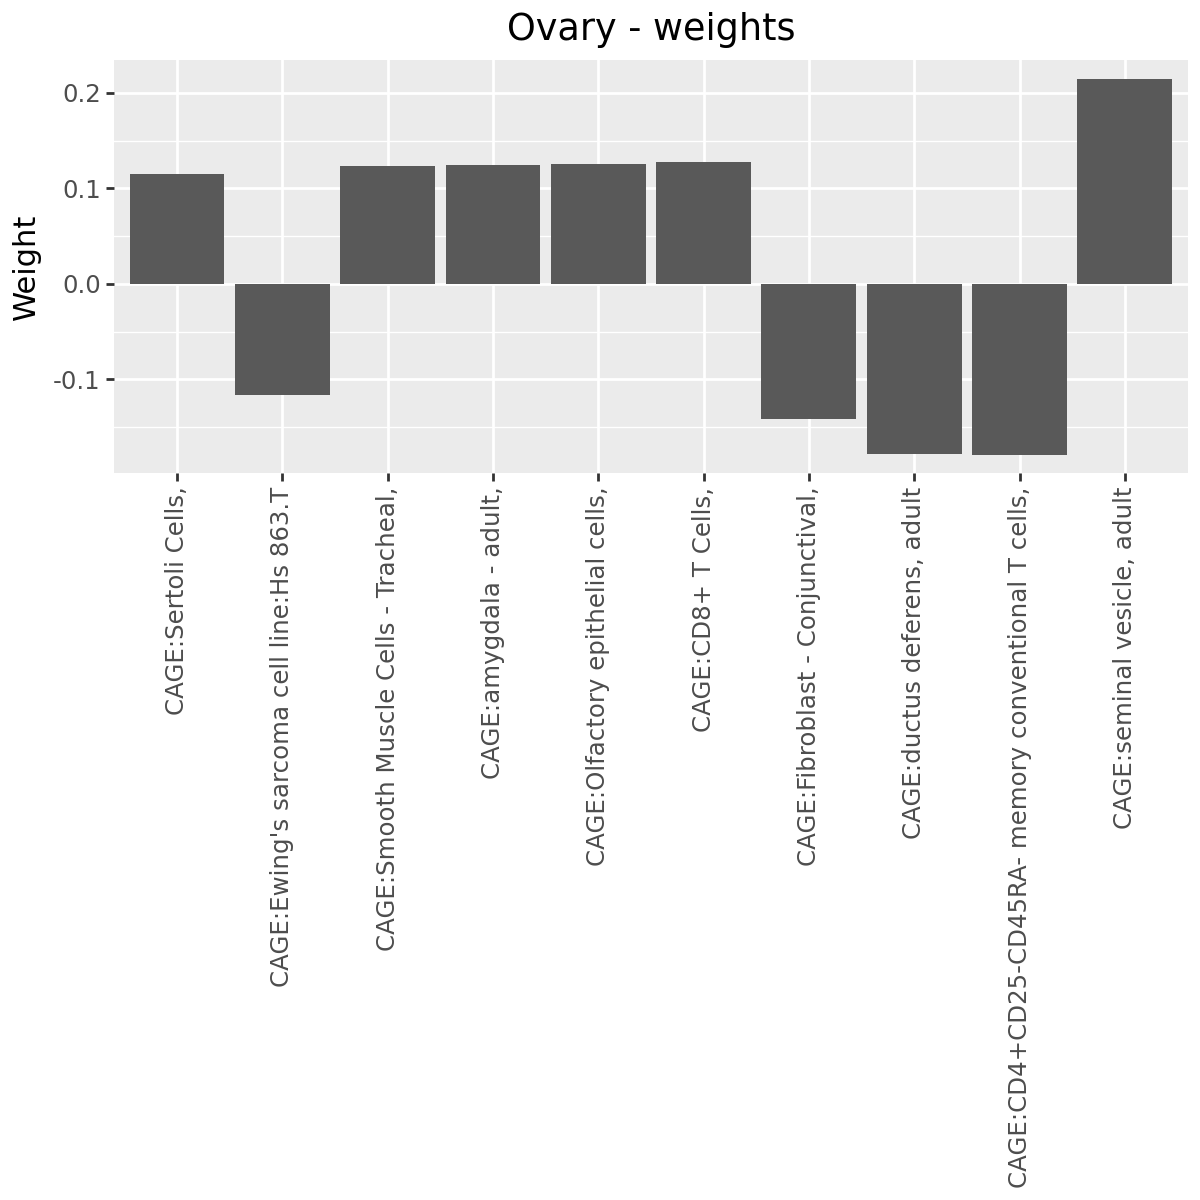

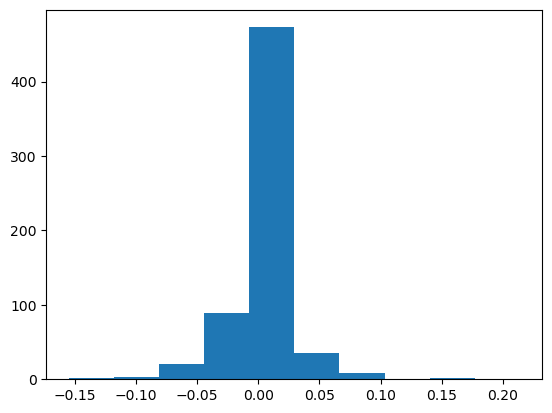

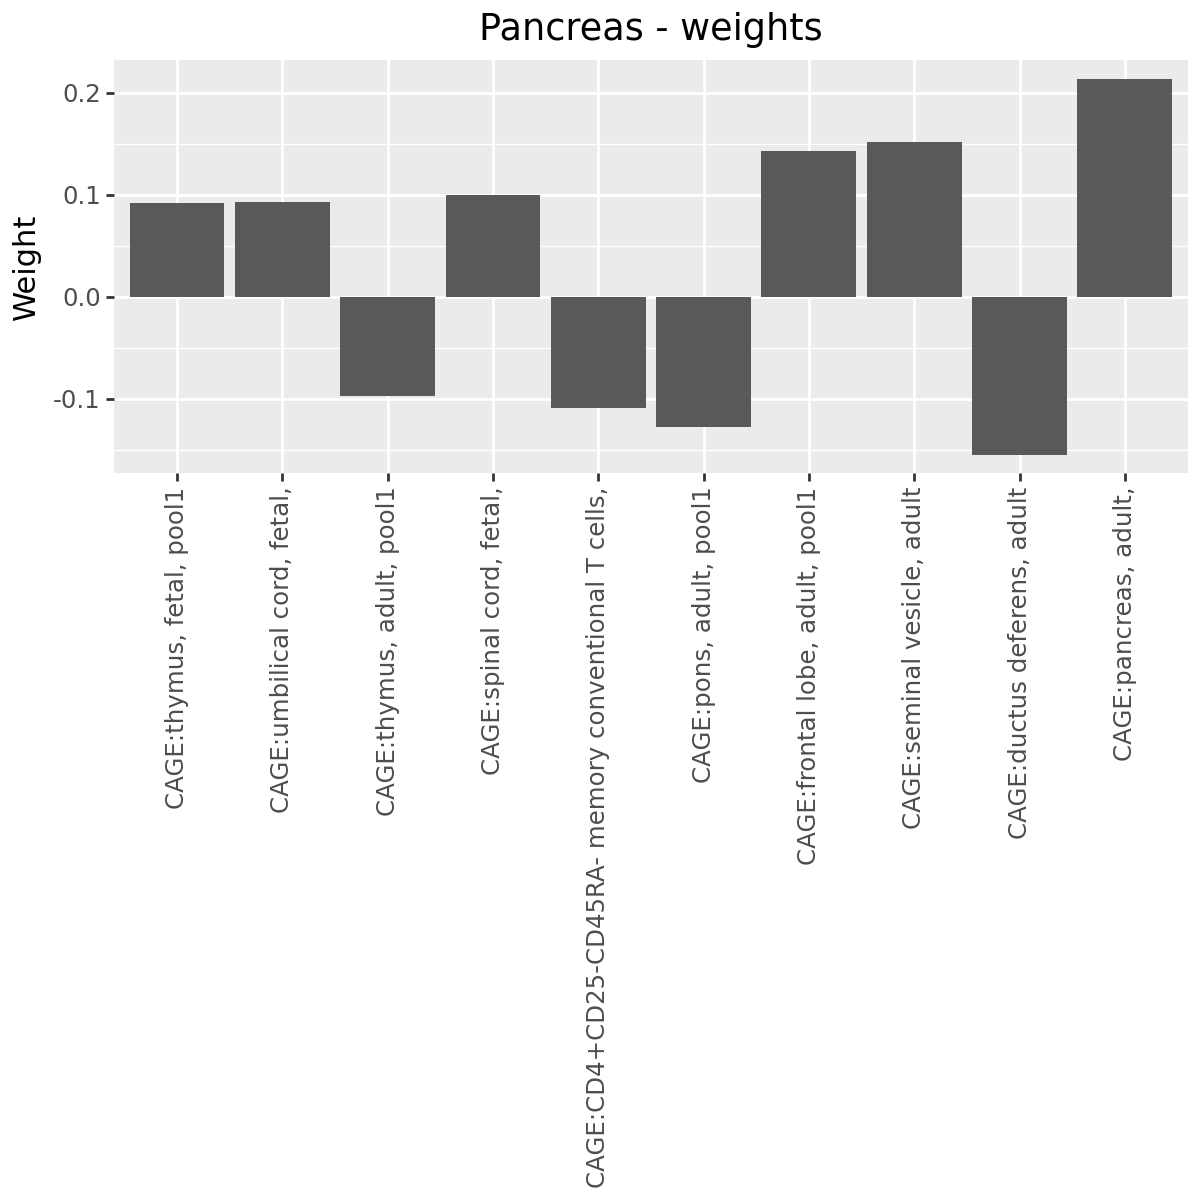

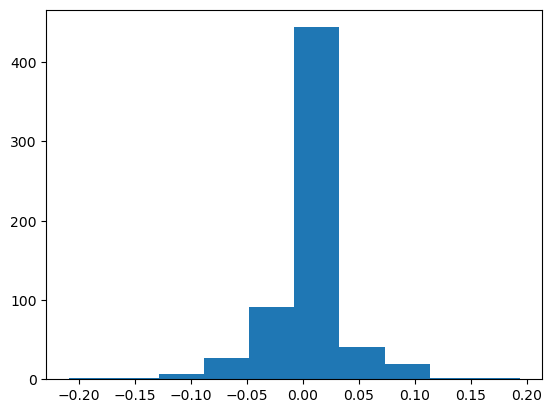

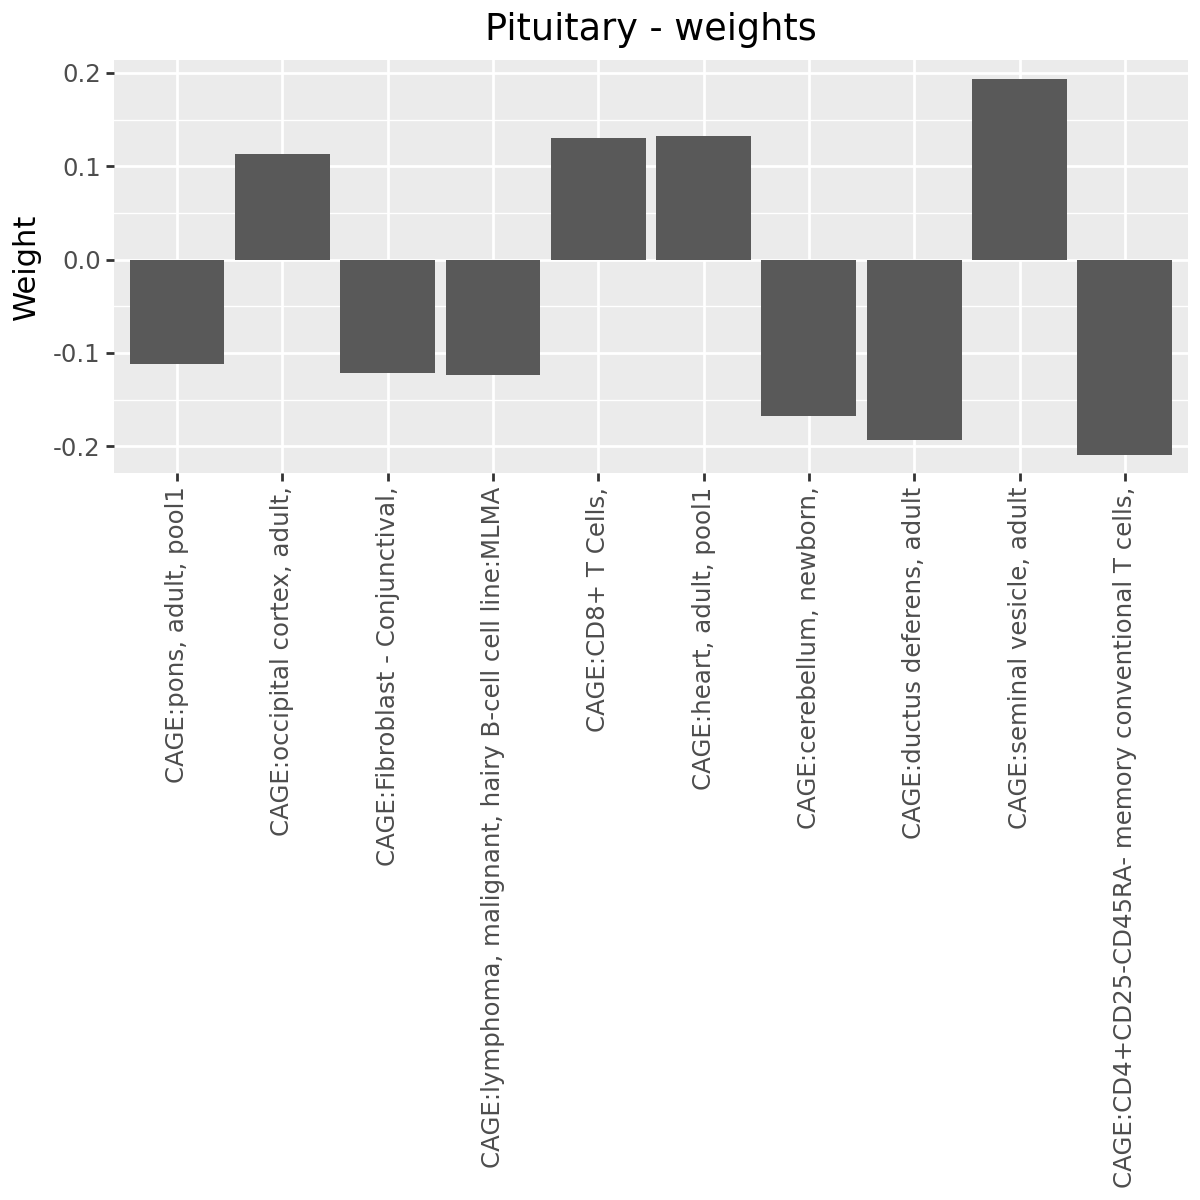

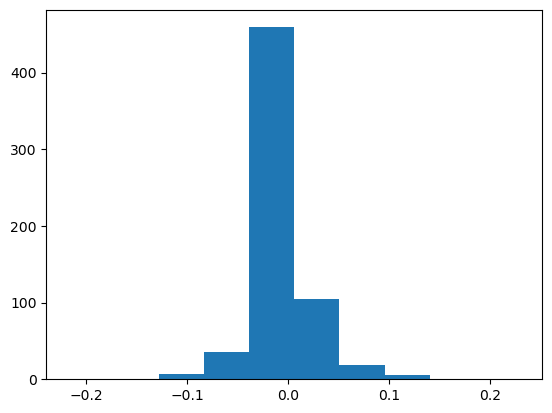

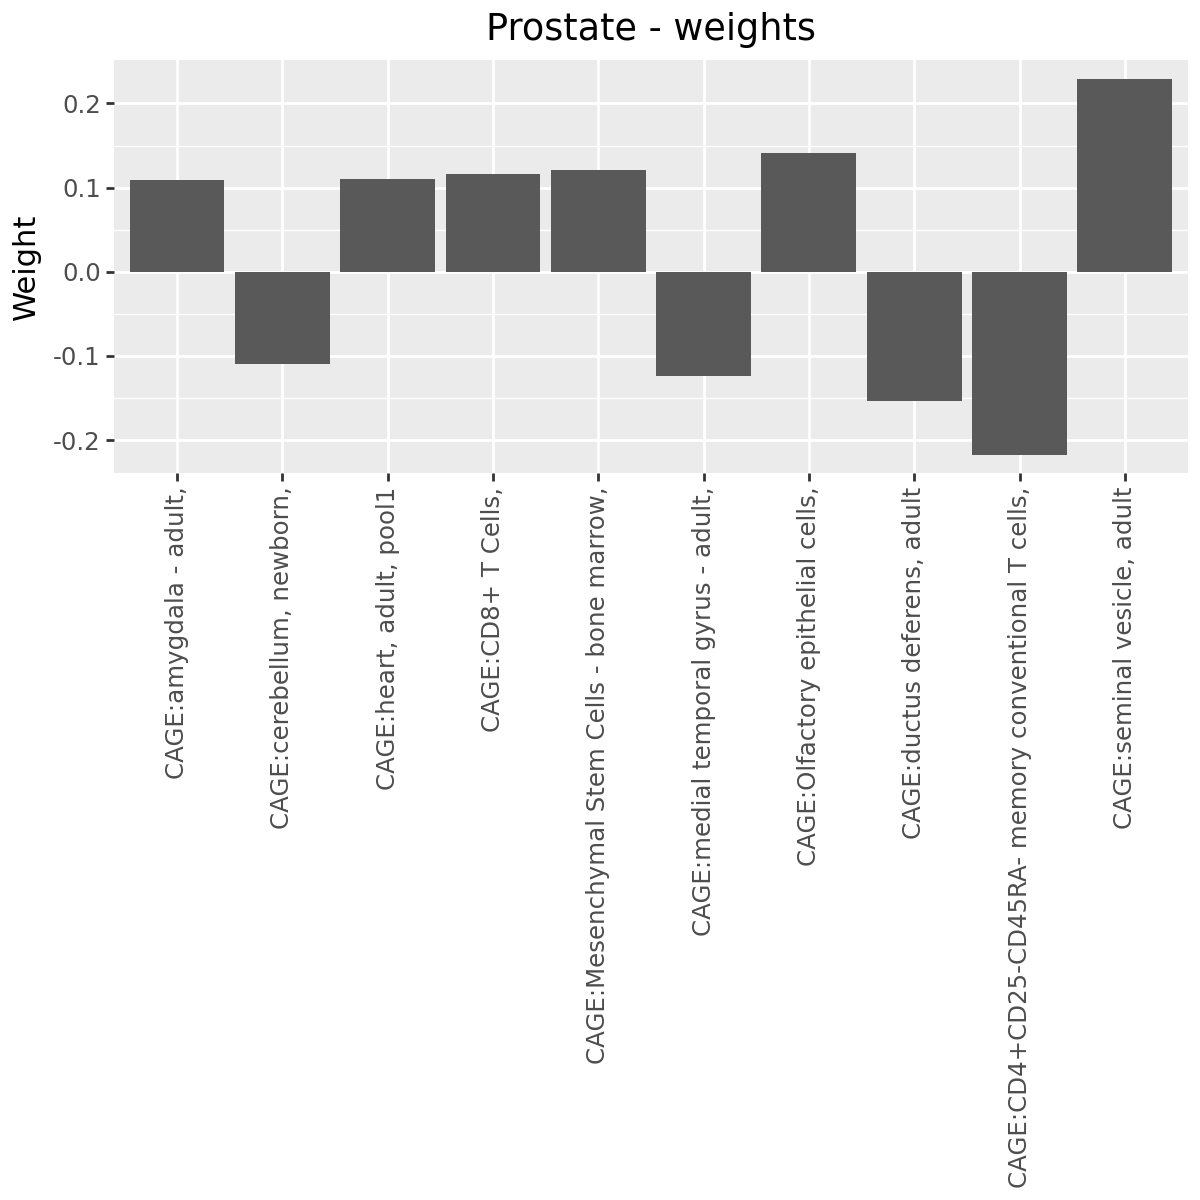

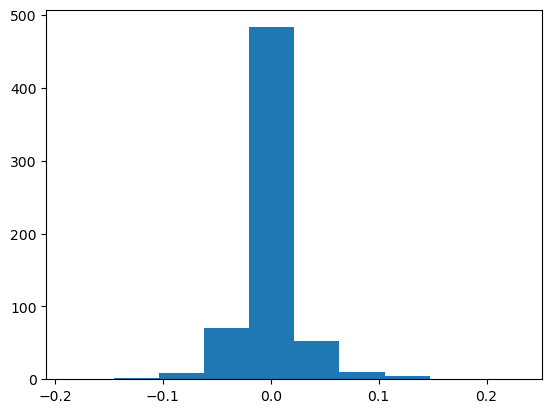

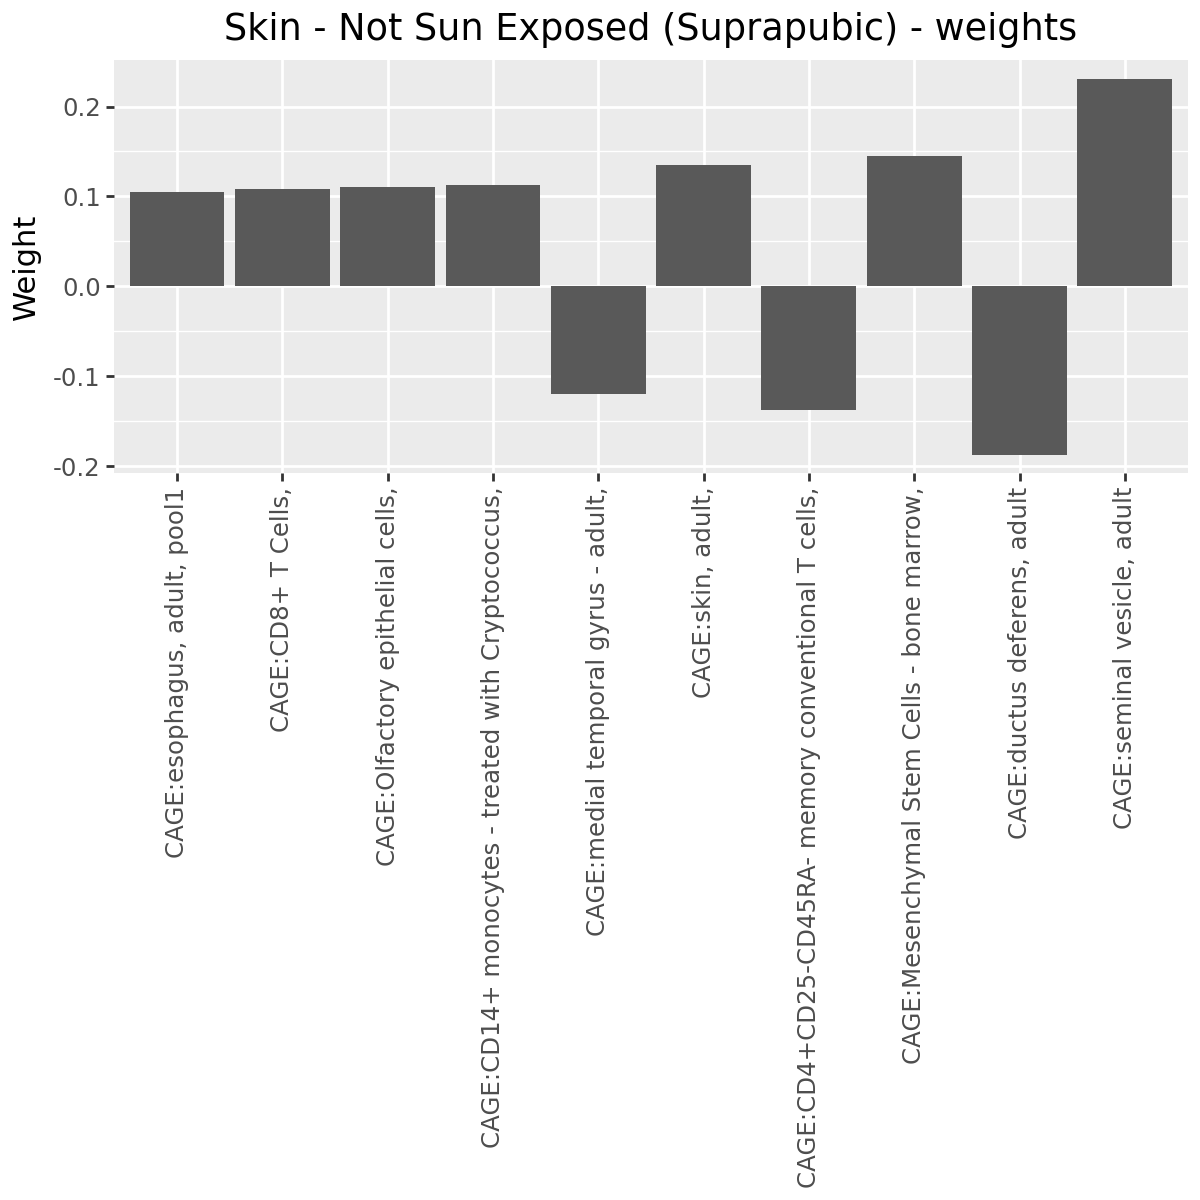

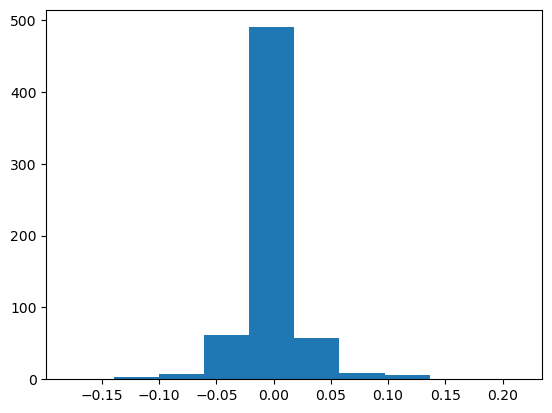

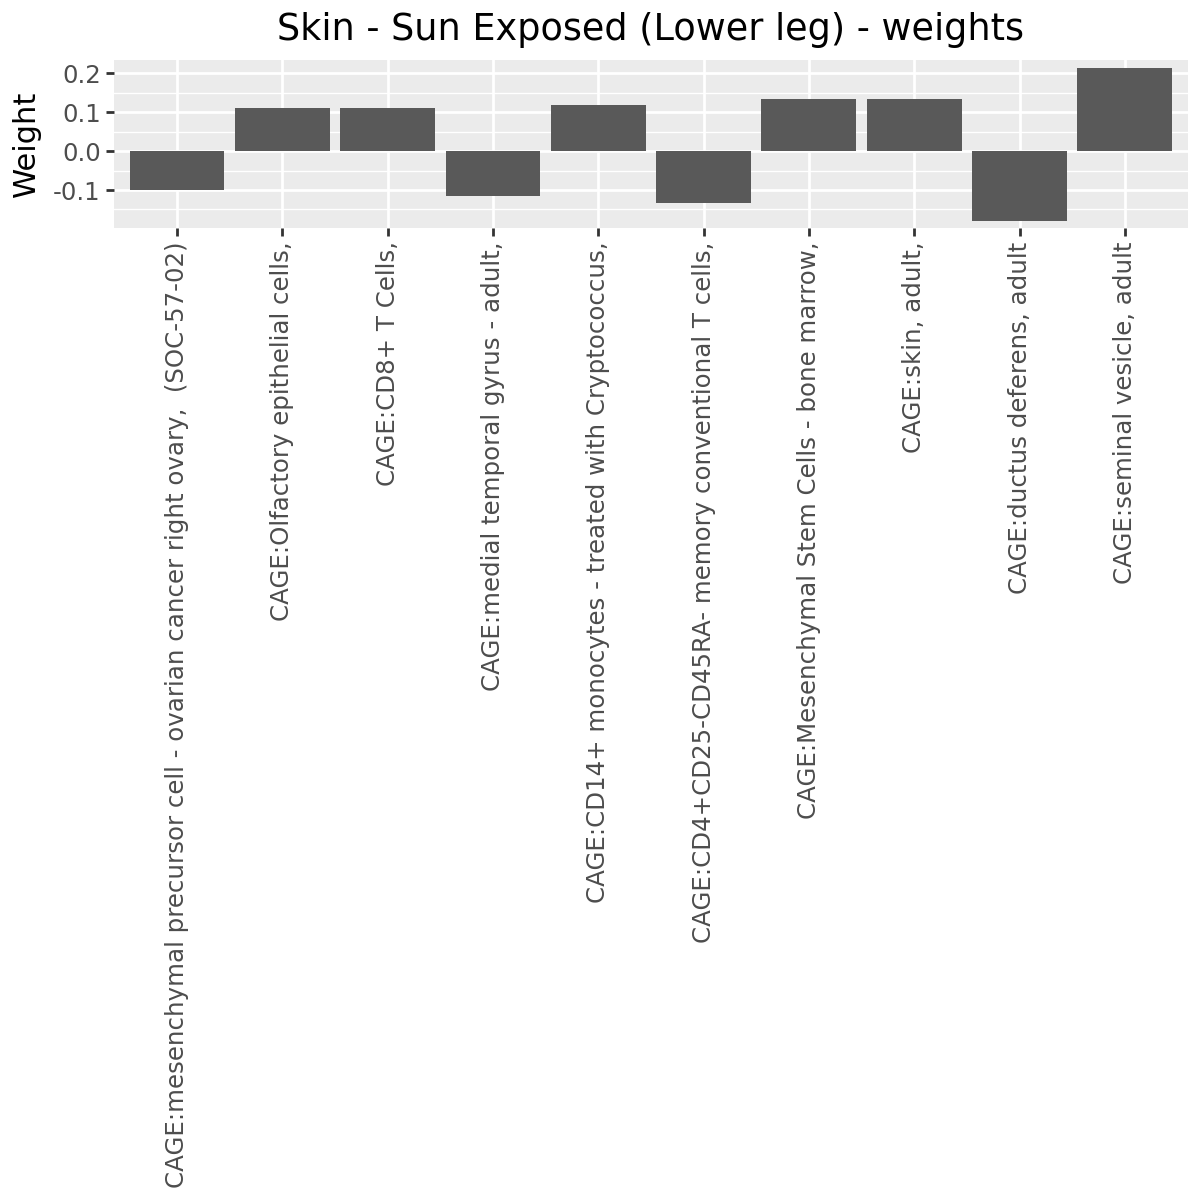

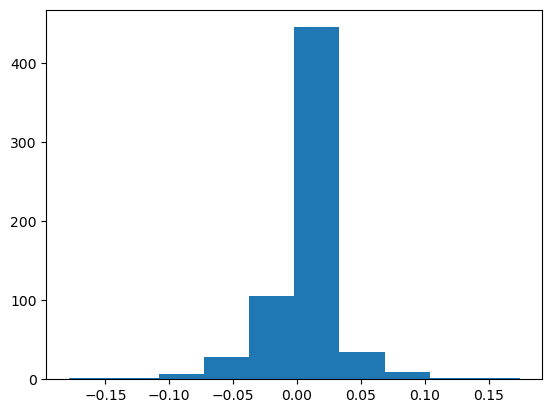

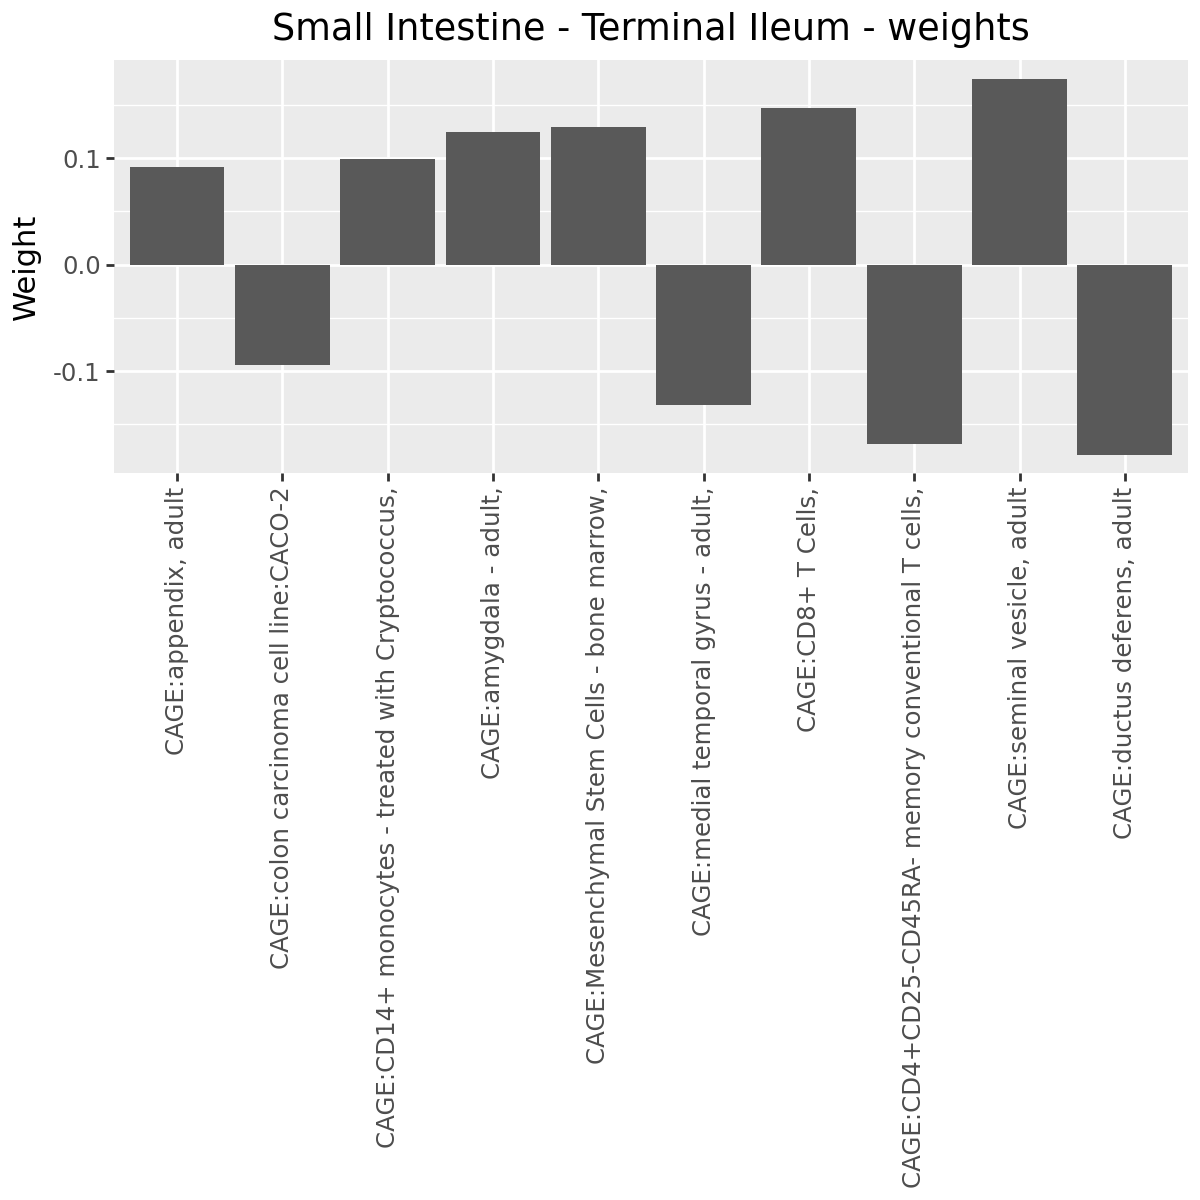

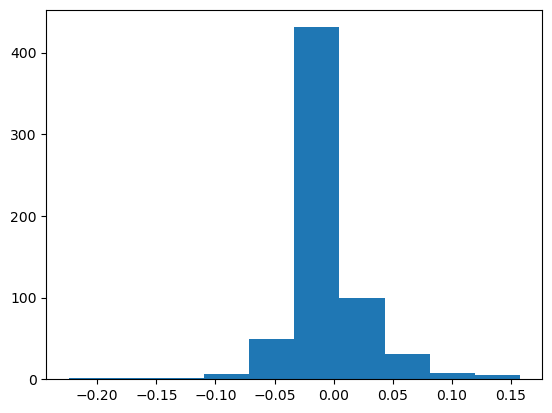

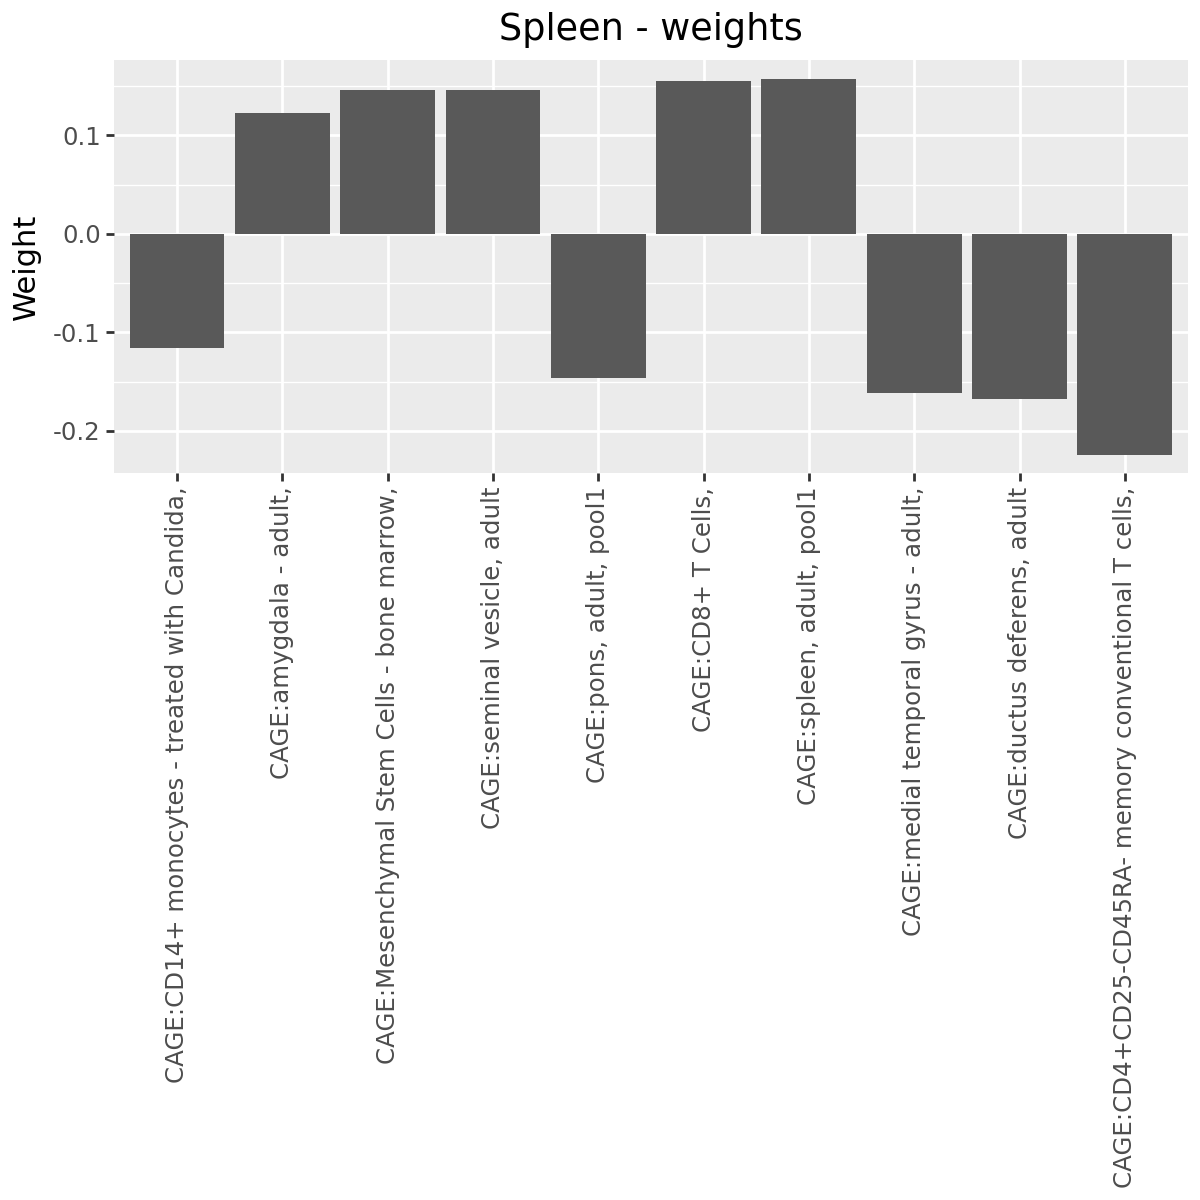

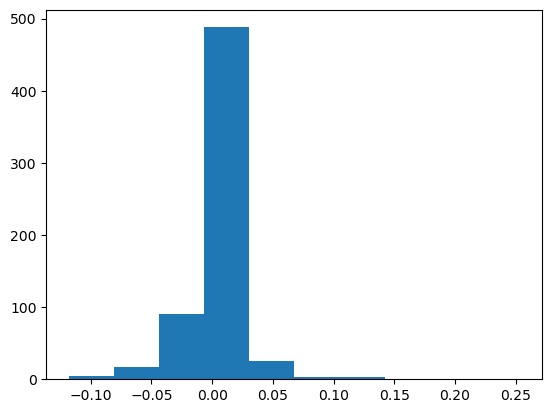

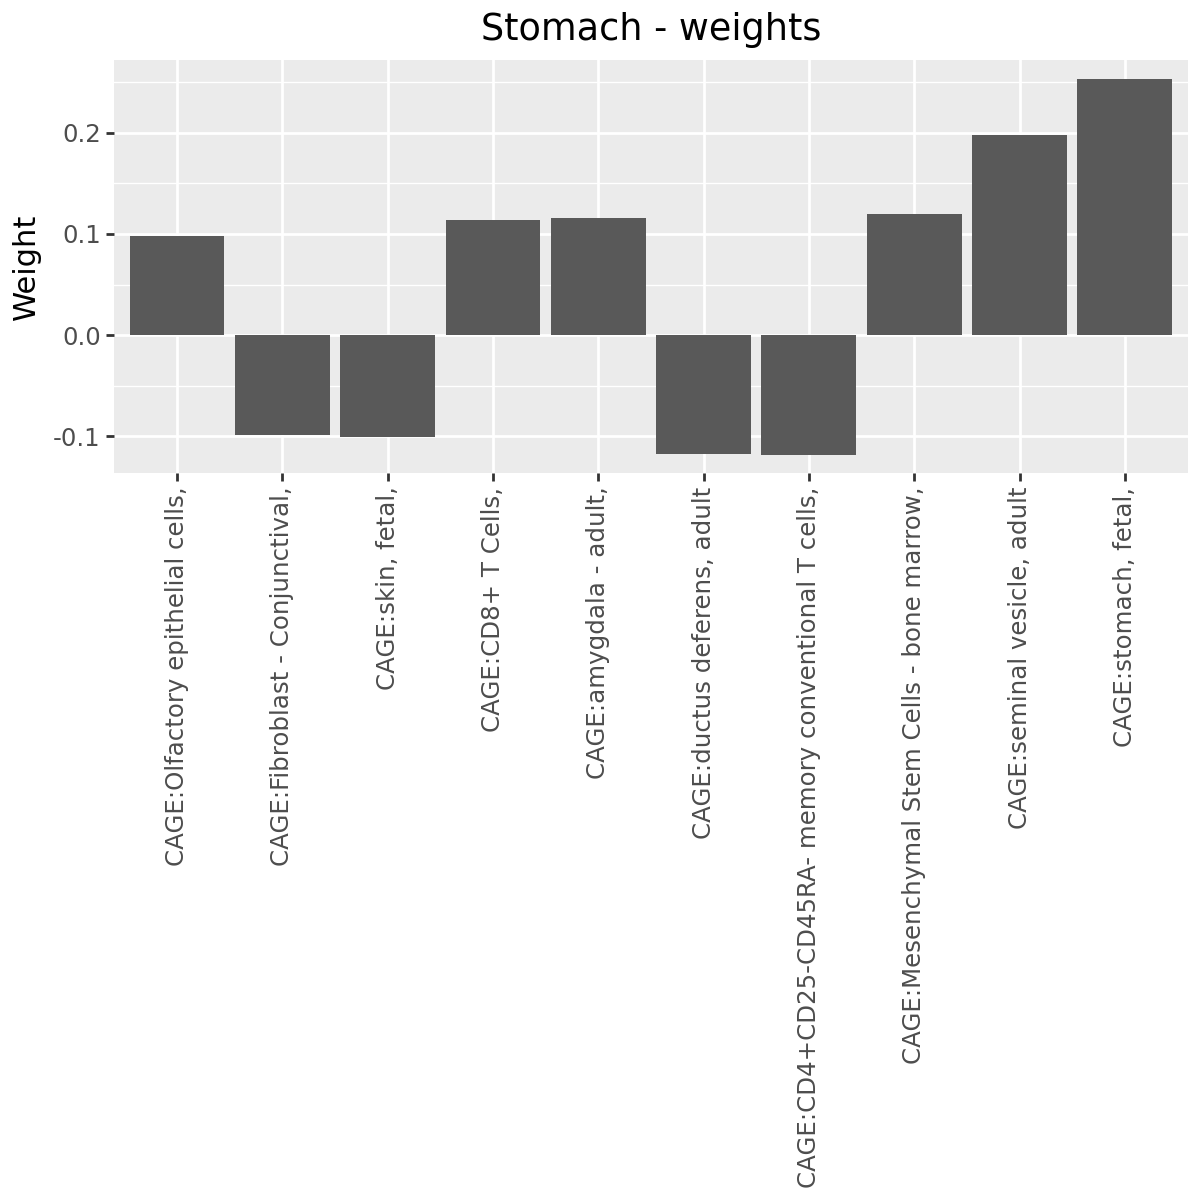

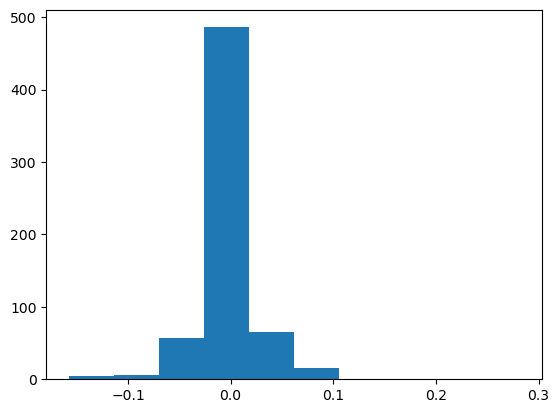

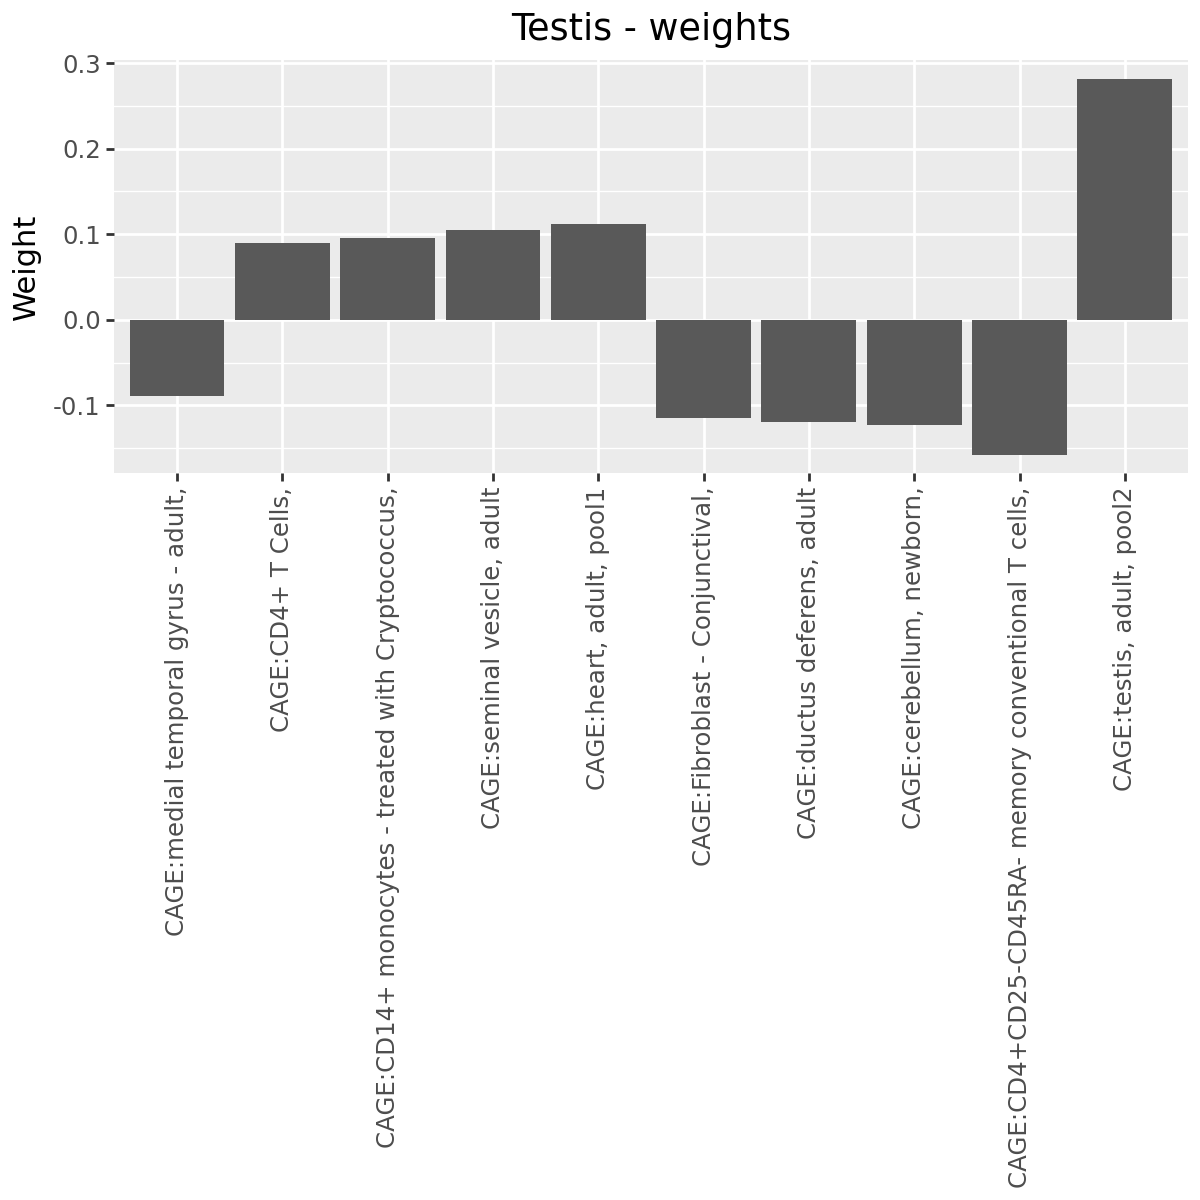

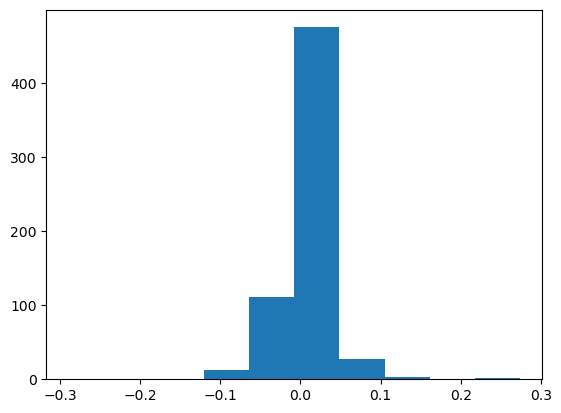

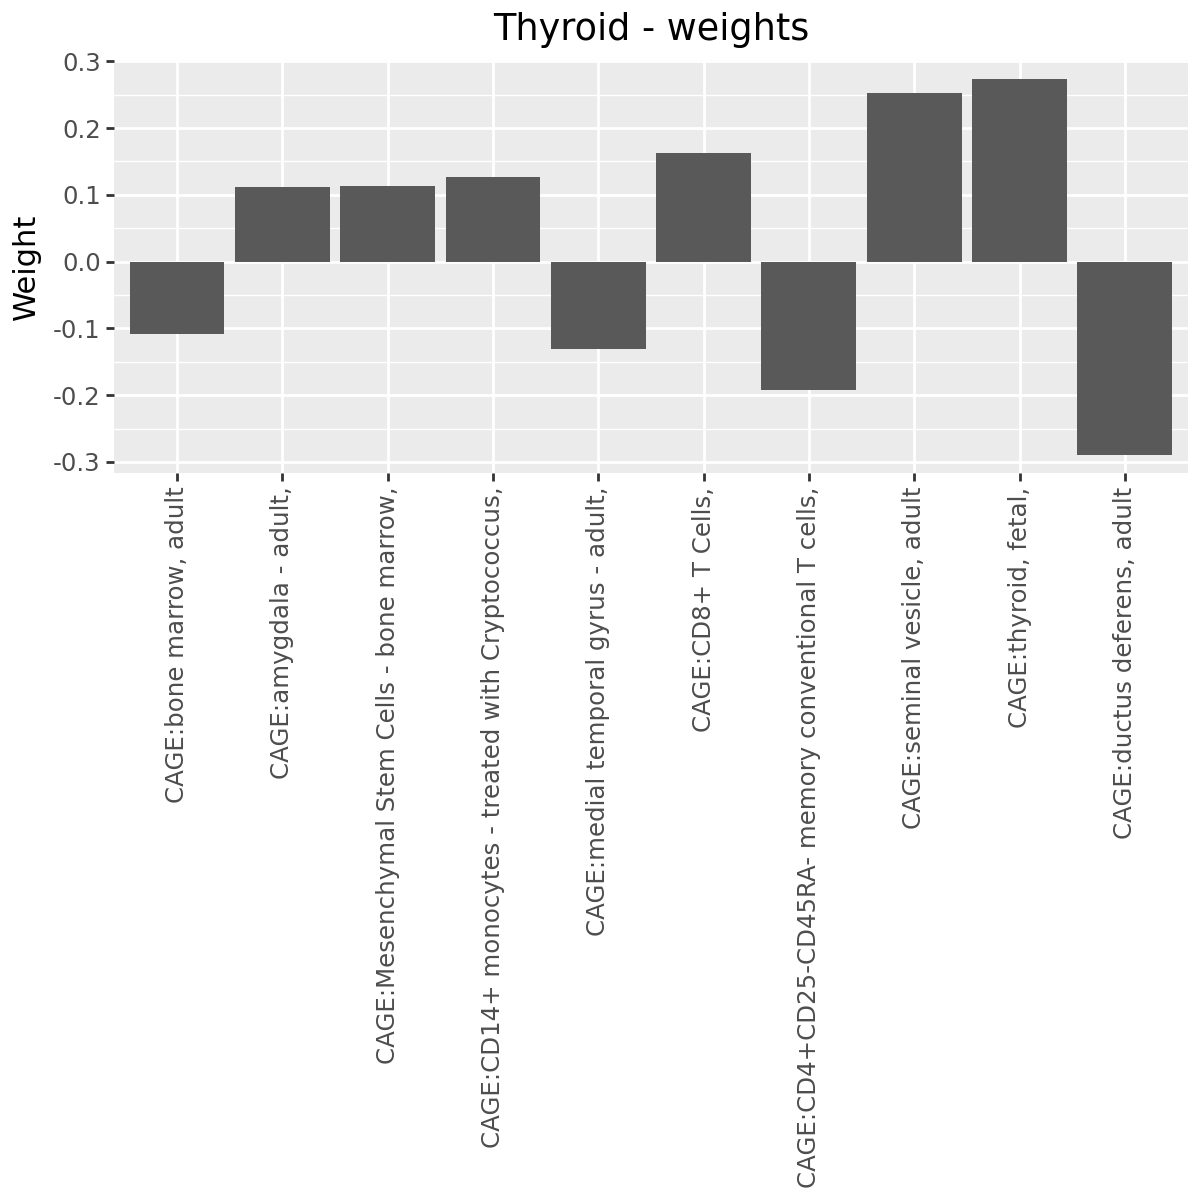

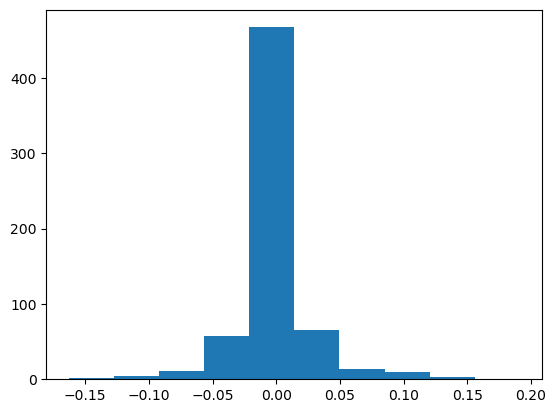

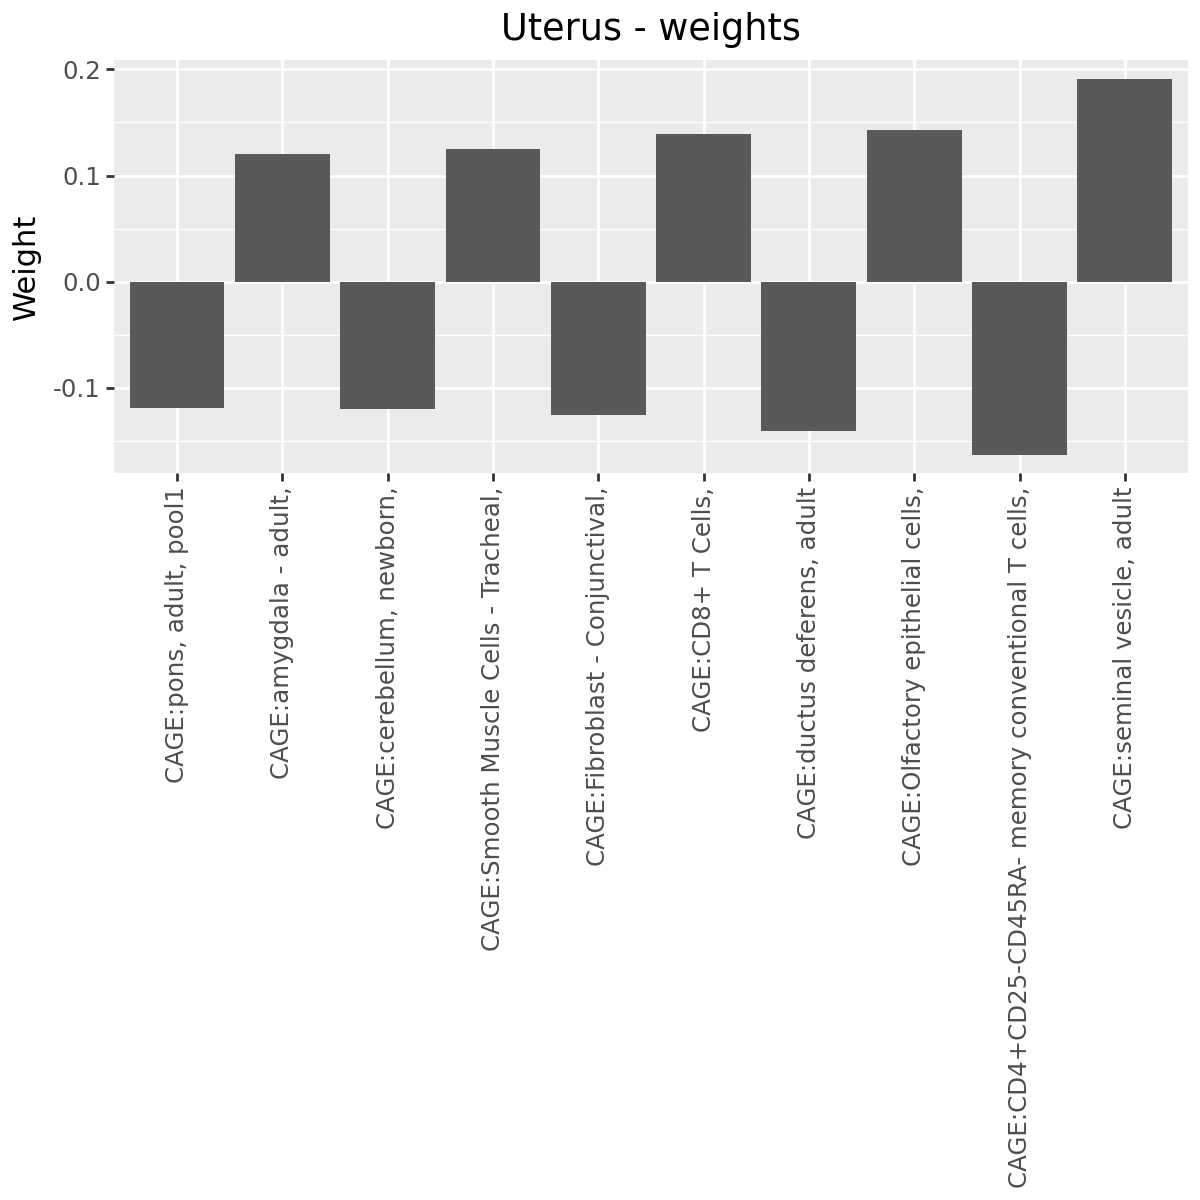

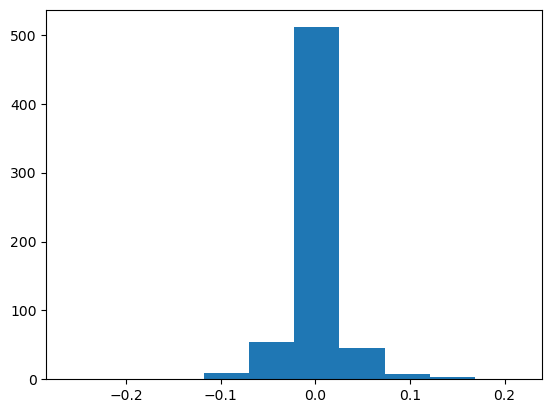

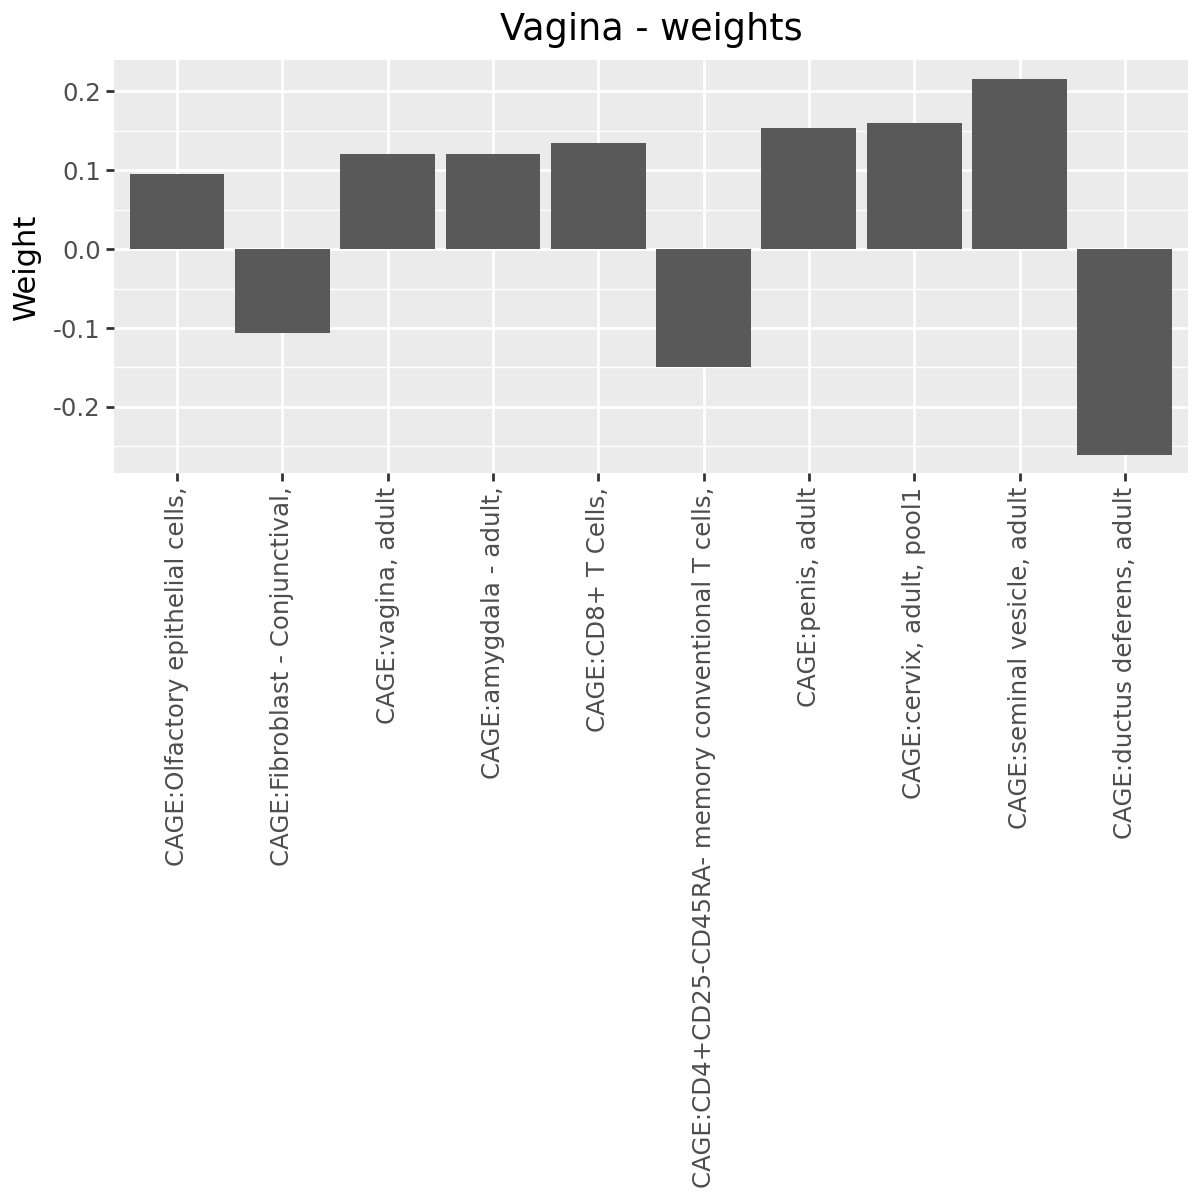

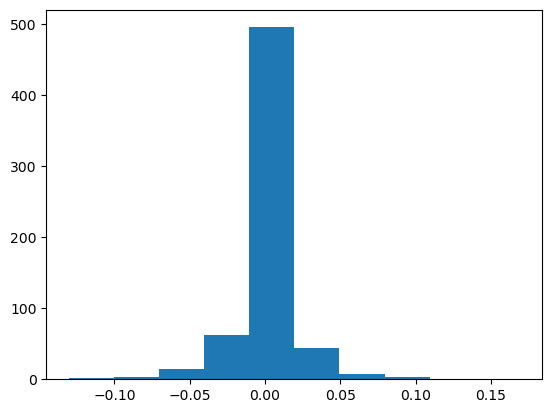

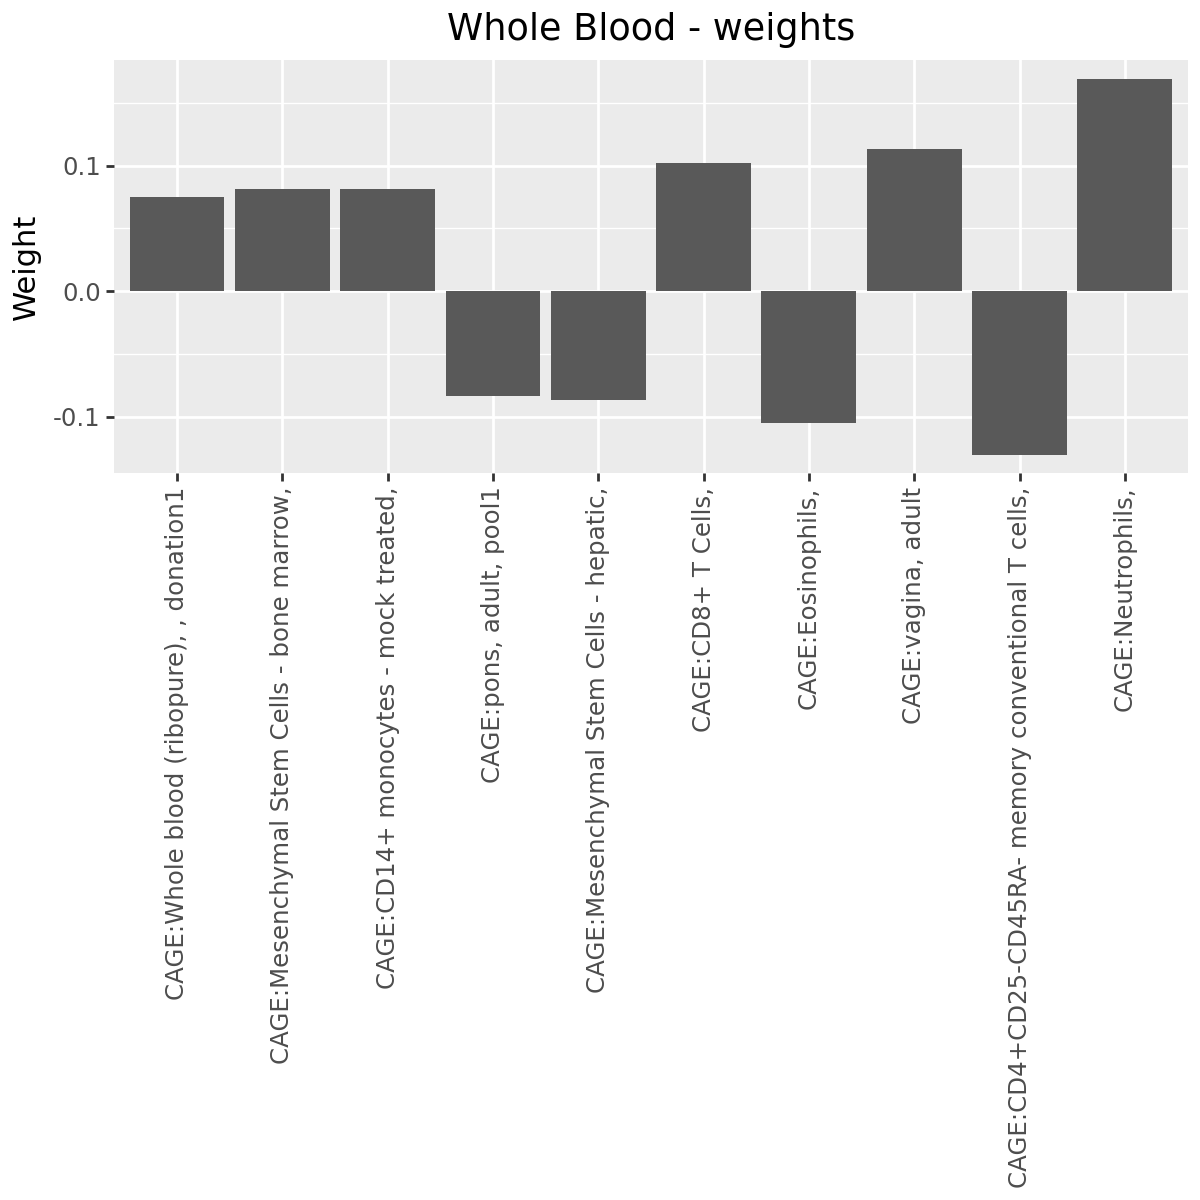

In [12]:
tracks = np.array(list(tissue_mapper.tracks_dict.keys()))
for k,v in tissue_mapper.tissue_mapper_lm_dict.items():
    coef_ = v.steps[1][1].coef_.flatten()
    plt.hist(coef_)
    plt.show()
    coef_idx_sorted = np.argsort(np.abs(coef_))
    top_tracks = tracks[coef_idx_sorted[-10:]]
    top_tracks = pd.Categorical(top_tracks, categories=top_tracks)
    top_coefs = coef_[coef_idx_sorted[-10:]]
    
    (pn.ggplot(pn.aes(x=top_tracks, y=top_coefs)) +
     pn.geom_bar(stat="identity") + 
     pn.theme(
        figure_size=(6, 6),
        axis_text_x=pn.element_text(angle=90),
        dpi=100) +
     pn.labs(
            x="", 
            y="Weight",
            title=f"{k} - weights",
        )
    ).show()
